# WebScraping job listings in the Bay Area on Monster.com


In [1]:
# load the necessary libraries
import codecs
import json
import matplotlib.pyplot as plt
import pandas as pd
import pymysql
import requests
import re
import time
import warnings
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from pandas import DataFrame
from tqdm import trange
from sqlalchemy import create_engine

### Our list of relevant job titles that we think MSBA students could apply to

In [2]:
# Potential Job Titles
sf_data_analyst_url = 'https://www.monster.com/jobs/search/Full-Time_8?q=__22Data-Analyst__22&where=Palo-Alto__2c-CA&rad=50&stpage=1&page=4'
sf_business_analyst_url = 'https://www.monster.com/jobs/search/Full-Time_8?q=__22Business-Analyst__22&where=Palo-Alto__2c-CA&rad=50&stpage=1&page=4'
sf_data_scientist_url = 'https://www.monster.com/jobs/search/Full-Time_8?q=__22Data-Scientist__22&where=Palo-Alto__2c-CA&rad=50&stpage=1&page=4'
# sf_decision_scientist_url = 'https://www.monster.com/jobs/search/Full-Time_8?q=__22Decision-Scientist__22&where=Palo-Alto__2c-CA&rad=50&stpage=1&page=4'
sf_marketing_analyst_url = 'https://www.monster.com/jobs/search/Full-Time_8?q=__22Marketing-Analyst__22&where=Palo-Alto__2c-CA&rad=50&stpage=1&page=4'
sf_product_analyst_url = 'https://www.monster.com/jobs/search/Full-Time_8?q=__22Product-Analyst__22&where=Palo-Alto__2c-CA&rad=50&stpage=1&page=4'
sf_strategy_analyst_url = 'https://www.monster.com/jobs/search/Full-Time_8?q=__22Strategy-Analyst__22&where=Palo-Alto__2c-CA&rad=50&stpage=1&page=4'
# sf_analyst = [sf_data_analyst_url, sf_business_analyst_url, sf_data_scientist_url, sf_decision_scientist_url, sf_marketing_analyst_url, sf_product_analyst_url, sf_strategy_analyst_url]
# sf_analyst

### Search Criteria: Data analyst, full time, Palo Alto, 50 miles radius

We use the Beautiful Soup library to load the page of query results

In [3]:
hdr = { 'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)' }
response = requests.get(sf_data_analyst_url, headers = hdr)
soup = BeautifulSoup(response.text, 'html.parser')

Monster.com store each job listing under a unique identifier ID. We can obtain the job titles, company name, and location as well as its url. 

In [4]:
# Retrieve section tag with unique ID attributes
all_listings = soup.find_all('section', attrs={'data-jobid': True})
ids = [item['data-jobid'] for item in all_listings]
loc_strings = list()

# Running a for loop to obtain and clean the location
for x in all_listings:
    loc_string = x.find('div', attrs={'class': 'location'}).find('span', attrs={'class': 'name'}).text.strip()
    
    if ',' in loc_string:
        city, state = [a.strip() for a in re.split(',',loc_string)]
        state = state[:2]  # two-letter state format
        loc_strings.append(', '.join([city, state]))
    else:
        loc_strings.append('')

# Save each individual job posting company to a variable
companies = [x.find('div', attrs={'class': 'company'}).find('span', attrs={'class': 'name'}).text.strip()
             for x in all_listings]

# Save each individual job title to a variable
job_titles = [x.find('h2', attrs={'class': 'title'}).find('a', href=True).string.strip() for x in all_listings]

# Save each individual job posting urls to a variable
sf_new_urls = [x.find('h2', attrs={'class': 'title'}).find('a', href=True)['href'] for x in all_listings]

print(job_titles[0])
print(companies[0])
print(loc_strings[0])
print(sf_new_urls[0])

# How many job listings?
len(job_titles)

Business and Data Analyst
Alphonso, Inc.
Mountain View, CA
https://job-openings.monster.com/business-data-analyst-mountain-view-ca-us-alphonso-inc/224572991


101

In [5]:
# Save job titles, companies and location to database
sf_job_info = list(zip(job_titles, companies, loc_strings))  
sf_job_info = pd.DataFrame(sf_job_info, columns = ['Job_Titles', 'Companies', 'Location'])
sf_job_info['Job Role']='Data Analyst'
sf_job_info

,Job_Titles,Companies,Location,Job Role
0,Business and Data Analyst,"Alphonso, Inc.","Mountain View, CA",Data Analyst
1,Cloud Data Analyst / Data Engineer,IBM,"San Jose, CA",Data Analyst
2,Senior Data Analyst,Wal-Mart,"San Bruno, CA",Data Analyst
3,"Senior Consulting Data Analyst - SAS, R, Python",Kaiser Permanente,"Oakland, CA",Data Analyst
4,Market Research Data Analyst / Engineer,BayStreet Research LLC,"OAKLAND, CA",Data Analyst
...,...,...,...,...
96,Data Analyst,"Staffigo Technical Services, LLC","Santa Clara, CA",Data Analyst
97,DATA ANALYST,Diverse Lynx,"SAN JOSE, CA",Data Analyst
98,Business Data Analyst,Enquero Inc,"Milpitas, CA",Data Analyst
99,Sr. Data Analyst,Workforce Logiq,,Data Analyst


### Loop every URL in the list and read the descriptions and salaries

In [6]:
# create new variables to store information generated in for loop 
new_job_url = dict()
sf_job_description = dict() 
sf_sal_description = dict()

# For loop to retrieve the descriptions and salaries
for x in trange(0,len(all_listings)):
    new_job_url[x] = sf_new_urls[x]
    response = requests.get(new_job_url[x])
    soup = BeautifulSoup(response.text, 'html.parser')
    
    job_body = soup.find('div', attrs={'name': 'value_description'})
    if job_body is None:
        job_body = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if job_body is None:
        job_body = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        job_body    
    job_desc = job_body.get_text(separator=' ')  # add whitespace between HTML tags
    
    value_salary = soup.find('div', attrs={'class': 'detail-row row'})
    if value_salary is None:
        value_salary = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if value_salary is None:
        value_salary = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        value_salary
    sal_desc = value_salary.get_text(separator=' ')  # add whitespace between HTML tags
    
    print(job_desc[:500] + '...')
    print(sal_desc)
    sf_job_description[x] = job_desc
    sf_sal_description[x] = sal_desc
    time.sleep(3)

  0%|          | 0/101 [00:00<?, ?it/s]

Business and Data Analyst  Company:  Alphonso, Inc. Location:  Mountain View, CA Position Type:  Full Time Experience:  See below for details Education:  See below for details Opening for Business and Data Analyst in Mountain View, CA at Alphonso Inc. Make and test modifications to database structure. Manage, query and build reports with database to understand customer behavior using big data tools. Write scripts/queries in SQL to measure performance metric such as CTR and Completion Rate. Req M...
Job Type fulltime ,  employee


  1%|          | 1/101 [00:03<05:35,  3.36s/it]

Introduction IBM Cloud Pak® for Data is a fully-integrated data and AI platform that modernizes how businesses collect, organize and analyze data to infuse AI throughout their organizations. Cloud native by design, the platform unifies market-leading services spanning the entire analytics lifecycle. From data management, DataOps, governance, business analytics and automated AI, IBM Cloud Pak for Data helps eliminate the need for costly, and often competing, point solutions while providing the in...
Job Type fulltime ,  employee


  2%|▏         | 2/101 [00:07<05:48,  3.52s/it]

Senior Data Analyst  Company:  Wal-Mart Location:  San Bruno, CA Position Type:  Full Time Experience:  See below for details Education:  See below for details Senior Data Analyst professional needed at Wal-Mart in San Bruno, CA. Master’s or equiv in Bus. Analytics, CS, Stats, Operations Research, or rel. field & 1 yr of exp in data analytics or rel. field; OR Bachelor’s or equiv in Bus. Analytics, CS, Stats, Operations Research, or rel. field & 3 yrs of exp in data analytics or rel. field. Walm...
Job Type fulltime ,  employee


  3%|▎         | 3/101 [00:10<05:48,  3.56s/it]

Description: Under general supervision, this position exists to assist the organization in making strategic data-related decisions by analyzing, manipulating, tracking, internally managing, and reporting data. This position functions both as a senior analyst and as a high-level statistical analytics programmer. Essential Functions: - Designs and enhances databases. - Designs effective and user-friendly menu systems. - Develops accurate, easy to read, and useful information reports. - Designs and...
Job Type fulltime ,  employee


  4%|▍         | 4/101 [00:14<05:45,  3.56s/it]

MARKET RESEARCH DATA ANALYST / ENGINEER We are a boutique market research firm that provides industry and investor clients with primary research on the mobile computing market. We measure, analyze, and predict smartphone, tablet and wearable sales using numerous data collection methodologies. Through our published reports and advisory services, our clients gain valuable insights into the macro and micro trends in the mobile industry. We are a small and dynamic firm with offices in the Old Oaklan...
Salary $85000  -  $100000   Per Year


  5%|▍         | 5/101 [00:18<05:46,  3.61s/it]

Description: The Digital Experience Analytics team is looking for a dynamic, data-driven Marketing Analyst with a strong blend of story-telling and technical expertise. B2B Digital Experience is an exciting, constantly evolving space that needs your skillset to drive marketing insights and generate long-term value for our client and its customers. In this role, you will be tasked with discovering and communicating customer-centric insights to your business partners by stitching together data fro...
Posted   2   days ago


  6%|▌         | 6/101 [00:22<05:48,  3.67s/it]

Responsibilities Produce content that caters to technical audience Create contents on “how to do” and ”use” analytical products to showcase for the following audience: SQL and BI developers Data Engineers Data scientists IT professionals Data Analyst Tech Evangelist Will primarily work with Data. Required skill set 3-5 years of experience with the following skill sets Python – not advanced. SQL queries Experience with Tableau, Looker, or other business intelligence software and big data analytic...
Job Type fulltime ,  employee


  7%|▋         | 7/101 [00:25<05:45,  3.67s/it]

We are seeking a highly skilled and tech-savvy lead to drive strategic data analysis and intelligence solutions across the Environmental and Supply Chain Innovation (ESCI) team. You will work closely with data analysts from various branches, fostering alignment and governance processes while analyzing data across the organization to identify trends, forecasts, and data-driven recommendations. Must Have Skills:   Strong familiarity with multiple methodologies in data analysis and insight synthesi...
Job Type fulltime ,  contract


  8%|▊         | 8/101 [00:29<05:37,  3.63s/it]

Career Opportunity:  Job Title:  Data Analyst       About  CodeForce  360  Making a career choice is amongst the most critical choices one can make, and it's important for the choice to be calculated with factors such as a company's run of success since its inception and more. But, when you come across  a company that has reputation proven with nothing but an illustrious run of success since the day it began, you don't need to think of anything else. That's precisely what some of our employees a...
Job Type fulltime ,  contract


  9%|▉         | 9/101 [00:32<05:37,  3.67s/it]

 job summary: 100% remote 
 Top skills:  Tableau, SQL, Python preferred 
 Data Analyst 
 What you'll do: •Develop data and visualization requirements in support of digital performance and metrics, including quarterly business reviews. •Analyze data and derive insights aligned to Customer Success and Renewals KPIs (key performance indicators) and goals.  "Tell the impact of digital on the business story" using the KPIs as lens. •Develop and build critical dashboards, reports, and dimensional mode...
Salary $35  -  $45   Per Hour


 10%|▉         | 10/101 [00:36<05:35,  3.69s/it]

Full Job Description Are you ready for a change? Want to join a dynamic and fast-growing company with amazing benefits then we welcome you to view our position. We are seeking an experienced Business Analyst/ Quality Analyst to work remotely! Interested in learning more? Keep reading. The primary responsibilities of the Business Analyst are to evaluate data, business processes, anticipate requirements, uncover areas for improvement, and develop and implement solutions related to data in various ...
Salary $35  -  $60   Per Hour


 11%|█         | 11/101 [00:40<05:43,  3.82s/it]

Product Stewardship Data Analyst   San Jose CA   12 Months Contract           Description:     Remote for now, but will be expected onsite once site opens. Must be local     Top 3 skills/qualifications     Preferred mathematics knowledge.   Familiarity working with large data set collection and management.   Basic understanding of chemistry     JOB SUMMARY:  The Global Regulatory Compliance Data Analyst will collect, analyze, review, chart, enter global UDI attributes, global labelling informati...
Job Type fulltime ,  employee


 12%|█▏        | 12/101 [00:44<05:35,  3.77s/it]

Awarded one of Inc's Best Workplaces 2019 and 2020 Forbes Top 10 Startup Company, we are a leader in direct-to-consumer ecommerce and has been featured in Vogue, Allure, Harper’s Bazaar, and Business Insider. This Jobot Job is hosted by: Jordan Abernathy Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: Our mission is simple: to make personalized skincare accessible and convenient for all.  We are creating the next generat...
Job Type fulltime ,  employee


 13%|█▎        | 13/101 [00:48<05:28,  3.74s/it]

Location:   San Francisco, CA Description:   Our client is currently seeking a DATA ANALYST    · BS degree required 1 year of experience · Design data visualization tools for evaluating and summarizing insights and research results · Perform exploratory data analysis and build QC pipelines. · Strong Python coding skills for data management, visualization, and basic modelling including experience with standard data science packages (NumPy, pandas, matplotlib, seaborn, Sklearn) · Knowledgeable of ...
Job Type fulltime ,  contract


 14%|█▍        | 14/101 [00:51<05:23,  3.72s/it]

Skyrocket Ventures is a recruiting firm for hundreds of high growth technology companies that range from industry leaders to top-tier startups.  This opportunity is with one of our client companies for a full-time permanent hire.  Please only apply if you are authorized to work in the U.S. Please note that even if this job is not a perfect match, we encourage you to apply as long as it is in the ballpark.  Companies are often flexible in hiring candidates who do not perfectly fit their written j...
Salary $130000  -  $200000   Per Year


 15%|█▍        | 15/101 [00:55<05:19,  3.71s/it]

Skip to main content...
Skip to main content


 16%|█▌        | 16/101 [00:58<05:08,  3.62s/it]

  Job Description Our leading client is seeking a Senior Data Governance Analyst to join their team. Requirements of the Senior Data Governance Analyst: Bachelor's degree in Finance, Accounting, Computer Science, or equivalent At least 8 years of experience in a data management, data operations, or data governance role within software, consumer goods, or financial services At least 8 years of experience with order management, revenue, accounting, planning, and/or procurement teams Working knowle...
Job Type fulltime ,  employee


 17%|█▋        | 17/101 [01:02<05:06,  3.65s/it]

As a Senior Data Analyst, you will focus on building and implementing advanced analytics solutions that drive valuable insights and create actionable health and wellness solutions to accelerate our mission of improving lives by individualizing sleep experiences. From deriving insights based on sleep patterns to building recommendation algorithms to improve sleep quality, this position will help drive engagement and retention for SleepIQ and its related applications. Y ou will leverage and enhanc...
Posted   8   days ago


 18%|█▊        | 18/101 [01:06<05:01,  3.64s/it]

Data Informatics Analyst: Generates ad hoc reports and regular datasets or report information for end-users using system tools and database or data warehouse queries and scripts. Integrates data from multiple sources to produce requested or required data elements. Programs and maintains report forms and formats, information dashboards, data generators, canned reports and other end-user information portals or resources. May create specifications for reports based on business requests. Survey Tip:...
Job Type fulltime ,  employee


 19%|█▉        | 19/101 [01:09<04:58,  3.63s/it]

Job Title:  Business  System Analyst (Data Analytic) Location:  San Francisco, CA Duration:  12 Months Required Skills: 3+ years of experience with principles and techniques of analyzing and documenting all product life cycle artifacts such as: functional requirements, business cases, project charters, communication plans, test plans, detailed functional specifications Proven track record of written and verbal communication skills, with both technical and non-technical audiences. Experience with...
Job Type fulltime ,  contract


 20%|█▉        | 20/101 [01:13<04:56,  3.66s/it]

Description: Under general supervision, this position exists to assist the organization in making strategic data-related decisions by analyzing, manipulating, tracking, internally managing, and reporting data. This position functions both as a senior analyst and as a high-level statistical analytics programmer. Essential Functions: - Designs and enhances databases. - Designs effective and user-friendly menu systems. - Develops accurate, easy to read, and useful information reports. - Designs and...
Job Type fulltime ,  employee


 21%|██        | 21/101 [01:17<04:54,  3.68s/it]

Awarded one of Inc's Best Workplaces 2019 and 2020 Forbes Top 10 Startup Company, we are a leader in direct-to-consumer ecommerce and has been featured in Vogue, Allure, Harper’s Bazaar, and Business Insider. This Jobot Job is hosted by: Jordan Abernathy Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: Our mission is simple: to make personalized skincare accessible and convenient for all.  We are creating the next generat...
Job Type fulltime ,  employee


 22%|██▏       | 22/101 [01:21<04:54,  3.72s/it]

 job summary: Business /Data Analyst candidate should have sound working knowledge of Data Warehouse/ Mart concepts and experience in creating Business Requirements Documents for multiple projects and provide requirement and design related assistance to the development team. This position documents data flows, data mappings, performs data lineage analysis as required. Should have experience working with multiple systems, databases, document the changes for data requirements. Collaborate with bus...
Salary $35  -  $56   Per Hour


 23%|██▎       | 23/101 [01:25<04:54,  3.78s/it]

Job Title:  CRM Data Analyst  Location: Remote Duration:  24 Months Pay Rate:  69.56 Job Description: Must have a good understanding of Salesforce and/or Microsoft Dynamics cloud platforms. Ability to understand the business processes, associated data structure, object model and articulate solutions by systematically approaching a problem.    Evaluate the data models and data structures to identify the gaps in conformance to the standardized data elements, and negotiate with SMEs stakeholders to...
Salary $69.56   Per Hour


 24%|██▍       | 24/101 [01:28<04:46,  3.71s/it]

Location:   Berkeley, CA Description:   Our client is currently seeking a Data Analyst (Entry)-Data Science-R&D-CH-US    DESCRIPTION Supply Chain Master Data is responsible for creating and maintaining SAP master data objects to support clinical and commercial manufacturing, designing new procedures to increase the functionality of SAP modules, and providing technical expertise to support initiatives with site-wide impact to ensure sustained business excellence. In addition, the team must mainta...
Job Type fulltime ,  contract


 25%|██▍       | 25/101 [01:32<04:41,  3.71s/it]

As a Senior Data Analyst, you will focus on building and implementing advanced analytics solutions that drive valuable insights and create actionable health and wellness solutions to accelerate our mission of improving lives by individualizing sleep experiences. From deriving insights based on sleep patterns to building recommendation algorithms to improve sleep quality, this position will help drive engagement and retention for SleepIQ and its related applications. Y ou will leverage and enhanc...
Posted   8   days ago


 26%|██▌       | 26/101 [01:35<04:34,  3.66s/it]

Description: Under close supervision, this position exists to assist the organization in making strategic data-related decisions by analyzing, manipulating, tracking, internally managing and reporting data.  This position functions both as an analyst and as a statistical analytics programmer.   Essential Functions: - Designs and enhances databases. - Designs menu systems that are effective and user-friendly. - Develops reports with accurate, easy to read, useful information. - Designs and genera...
Job Type fulltime ,  employee


 27%|██▋       | 27/101 [01:39<04:30,  3.66s/it]

 job summary: Job Description:    Core Job Duties and Responsibilities: 
 •Support IHA data submission process and ensure effective translation of technical requirements for internal and external clients •Document, implement, and continuously improve reporting and analysis. This work will include data file aggregation, validation of health plan data, analysis of clinical quality, utilization and cost data. •Support teams across the organization with clean data and insightful analysis •Clearly an...
Salary $90000  -  $100000   Per Year


 28%|██▊       | 28/101 [01:43<04:32,  3.73s/it]

Healthcare Data Analyst for a Managed Care office offering excellent benefits and career growth! This Jobot Job is hosted by: Randy Kallick Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $65,000 - $84,000 per year A bit about us: Based in San Leandro, CA we are a managed healthcare provider providing a wide range of managed services!  As a data analyst you will be responsible for data collection, management, validation, analysi...
Salary $65000  -  $84000   Per Year


 29%|██▊       | 29/101 [01:47<04:29,  3.74s/it]

As a Senior Data Analyst, you will focus on building and implementing advanced analytics solutions that drive valuable insights and create actionable health and wellness solutions to accelerate our mission of improving lives by individualizing sleep experiences. From deriving insights based on sleep patterns to building recommendation algorithms to improve sleep quality, this position will help drive engagement and retention for SleepIQ and its related applications. Y ou will leverage and enhanc...
Posted   8   days ago


 30%|██▉       | 30/101 [01:50<04:18,  3.64s/it]

A Diversant tech client is seeking an experienced Marketing Data Analyst for a long term engagement in Cupertino (post CV-19).  Description To be successful in this position, you should have a real passion for conceptualizing, documenting and deploying analytical plans to tackle business questions. You will need to be a self-starter, driven, accountable and a highly upbeat teammate.  To succeed you will need to build partnerships and work collaboratively.   We are looking for a Marketing Web Ana...
Job Type fulltime ,  contract


 31%|███       | 31/101 [01:54<04:31,  3.87s/it]

Description: Under general supervision, this position exists to assist the organization in making strategic data-related decisions by analyzing, manipulating, tracking, internally managing and reporting data. This position takes an active leadership role both as a consultant and as a high-level statistical analytics programmer. Essential Functions: - Leads, makes significant contributions, &/or provides technical leadership to high visibility projects to identify & resolve issues of strategic im...
Job Type fulltime ,  employee


 32%|███▏      | 32/101 [01:58<04:21,  3.78s/it]

Awarded one of Inc's Best Workplaces 2019 and 2020 Forbes Top 10 Startup Company, we are a leader in direct-to-consumer ecommerce and has been featured in Vogue, Allure, Harper’s Bazaar, and Business Insider. This Jobot Job is hosted by: Jordan Abernathy Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: Our mission is simple: to make personalized skincare accessible and convenient for all.  We are creating the next generat...
Job Type fulltime ,  employee


 33%|███▎      | 33/101 [02:02<04:17,  3.78s/it]

As a Senior Data Analyst, you will focus on building and implementing advanced analytics solutions that drive valuable insights and create actionable health and wellness solutions to accelerate our mission of improving lives by individualizing sleep experiences. From deriving insights based on sleep patterns to building recommendation algorithms to improve sleep quality, this position will help drive engagement and retention for SleepIQ and its related applications. Y ou will leverage and enhanc...
Posted   8   days ago


 34%|███▎      | 34/101 [02:05<04:09,  3.72s/it]

 job summary: Our client is looking for a Data Infrastructure Analyst to join the Hardware organization's Analytics Team. As a Data Infrastructure Analyst, you will be the backbone of their hardware data. Working closely with the Data Analysts on the team, you will build and 
 own the data tables and pipelines that help drive key decisions for hardware 
 engineering teams. But this role is more than just scripting. As part of your work, you 
 will develop relationships with all the teams that pr...
Salary $37  -  $45   Per Hour


 35%|███▍      | 35/101 [02:09<04:04,  3.71s/it]

Description: Under general supervision, this position exists to assist the organization in making strategic data-related decisions by analyzing, manipulating, tracking, internally managing and reporting data. This position functions both as consultant and as a high-level statistical analytics programmer. Essential Functions: - Designs and enhances databases. - Designs menu systems that are effective and user-friendly. - Develops reports with accurate, easy to read, useful information. - Designs ...
Job Type fulltime ,  employee


 36%|███▌      | 36/101 [02:13<04:04,  3.76s/it]

Awarded one of Inc's Best Workplaces 2019 and 2020 Forbes Top 10 Startup Company, we are a leader in direct-to-consumer ecommerce and has been featured in Vogue, Allure, Harper’s Bazaar, and Business Insider. This Jobot Job is hosted by: Jordan Abernathy Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: Our mission is simple: to make personalized skincare accessible and convenient for all.  We are creating the next generat...
Job Type fulltime ,  employee


 37%|███▋      | 37/101 [02:17<03:59,  3.74s/it]

As a Senior Data Analyst, you will focus on building and implementing advanced analytics solutions that drive valuable insights and create actionable health and wellness solutions to accelerate our mission of improving lives by individualizing sleep experiences. From deriving insights based on sleep patterns to building recommendation algorithms to improve sleep quality, this position will help drive engagement and retention for SleepIQ and its related applications. Y ou will leverage and enhanc...
Posted   8   days ago


 38%|███▊      | 38/101 [02:20<03:49,  3.64s/it]

Description: Includes design, testing, implementation, control and maintenance of organization's logical and relational databases across platforms and computing environments. Essential Functions: - Project Management: Manages small to medium size projects. Develops and executes project plans. Provides project reporting to project sponsor under guidance of higher level resource. - Meta Data Repository: Develops data definitions consistent with data management standards and conventions. Defines me...
Job Type fulltime ,  employee


 39%|███▊      | 39/101 [02:24<03:45,  3.64s/it]

Healthcare Data Analyst for a Managed Care office offering excellent benefits and career growth! This Jobot Job is hosted by: Randy Kallick Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $65,000 - $84,000 per year A bit about us: Based in San Leandro, CA we are a managed healthcare provider providing a wide range of managed services!  As a data analyst you will be responsible for data collection, management, validation, analysi...
Salary $65000  -  $84000   Per Year


 40%|███▉      | 40/101 [02:28<03:46,  3.71s/it]

Senior Data Scientist  -  Well-Established, Fast-Growing Geo-Location Analytics SaaS Company! This Jobot Job is hosted by: Paul Madden Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $160,000 per year A bit about us: Based in San Francisco, our geo-location analytics platform measures the way media influences people to visit places online, in real-time. We are working with massive amounts of data...a few BILLION DATA ...
Salary $140000  -  $160000   Per Year


 41%|████      | 41/101 [02:31<03:39,  3.66s/it]

Senior Data Scientist  -  Well-Established, Fast-Growing Geo-Location Analytics SaaS Company! This Jobot Job is hosted by: Paul Madden Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $160,000 per year A bit about us: Based in San Francisco, our geo-location analytics platform measures the way media influences people to visit places online, in real-time. We are working with massive amounts of data...a few BILLION DATA ...
Salary $140000  -  $160000   Per Year


 42%|████▏     | 42/101 [02:35<03:35,  3.65s/it]

As a Supply Chain Data Analyst, you will collect and analyze supply chain data to help support Arista’s business decisions. Data analysts will need to look at complex and separate sets of data to help reach conclusions and make recommendations to Arista leadership on improvements to boost performance and reduce costs. Supply chain data analysts also lead process improvement as well as working towards automating the collection and analysis of the required data to help support Arista’s business de...
Posted   4   days ago


 43%|████▎     | 43/101 [02:38<03:32,  3.67s/it]

Square is building two powerful eco systems to empower businesses and individuals financially.  Square Seller builds common business tools in unconventional ways so more people can start, run, and grow their businesses. Square has been building an entire business toolkit of both hardware and software products including Square Capital, Square Terminal, Square Payroll, and more. We’re working to find new and better ways to help businesses succeed on their own terms—and we’re looking for people lik...
Posted   9   days ago


 44%|████▎     | 44/101 [02:42<03:31,  3.71s/it]

Palo Alto Veterans Institute for Research (PAVIR)  is seeking a full-time  Data Analyst / Technical Writer  to join Team Participatory System Dynamics (Team PSD) in leading a national quality improvement program in the Veterans Health Administration. 
 ABOUT THIS ROLE: 
 As the Data Analyst / Technical Writer you will support Team PSD's efforts to change the way health care quality improvement decisions are made across all layers of the Veterans Health Administration. It is rewarding to know tha...
Posted   1   Day ago


 45%|████▍     | 45/101 [02:46<03:24,  3.65s/it]

Mackin Talent is seeking a Data Analyst with at least 2 years experience with data and analytics in businesses strategy, marketing, finance, engineering or science and 1 year or more of experience with SQL (Oracle, Vertica, Hive, MySQL, etc) or a scripting language for data analysis is required. Candidate will also need a minimum of 2 years experience with statistical analysis. Stat packages such as R, MATLAB, SPSS, SAS, Stata, etc. Duties Work closely with the PM and members of the analytics te...
Posted   1   Day ago


 46%|████▌     | 46/101 [02:49<03:20,  3.64s/it]

At Bristol Myers Squibb, we are inspired by a single vision – transforming patients’ lives through science. In oncology, hematology, immunology and cardiovascular disease – and one of the most diverse and promising pipelines in the industry – each of our passionate colleagues contribute to innovations that drive meaningful change. We bring a human touch to every treatment we pioneer. Join us and make a difference.     At Bristol Myers Squibb, we are inspired by a single vision – transforming pat...
Posted   3   days ago


 47%|████▋     | 47/101 [02:53<03:21,  3.72s/it]

Job Description: Clients Finance organization is leading a cross-functional effort to improve the efficiency and effectiveness of Clients pricing and discounting activities on a global basis. A Discounting and Value Management initiative, set up to drive these efforts, requires a Business Systems Analyst to support team members, focusing on gathering, transformation, analysis, and visualization of financial and operational data for executive and field decision making. Responsibilities Conduct en...
Posted   3   days ago


 48%|████▊     | 48/101 [02:57<03:17,  3.73s/it]

Reference # : 21-03628 Title : Data Analyst III Location : Cupertino, CA Experience Level : Start Date / End Date : 04/01/2021 / 10/30/2021   Description Title: Data Analyst Duration: 7 Months + Location: Cupertino, CA remote to start then onsite in Cupertino 12159828 Key Qualifications 5+ years of experience as a data analyst or data scientist 3+ years of experience with querying in Hadoop, e.g. Spark, Hive 3+ years of experience with a programming language, e.g. Python, Scala 3+ years of exper...
Posted   6   days ago


 49%|████▊     | 49/101 [03:01<03:10,  3.67s/it]

Our mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at our company are builders at heart. Our global teams are constantly iterating, solving...
Posted   7   days ago


 50%|████▉     | 50/101 [03:04<03:04,  3.62s/it]

Data Analyst     Sunnyvale, California, United States     New     Digital and Technology     Requisition # 21005838     Post Date Mar 10, 2021     RESPONSIBILITIES     Responsible for ensuring the business makes better decisions through collection and usage of data. Ensures business data and analysis requirements are met by properly applying data concepts, including data structures, collection and cleansing, and structured and unstructured data analysis and reporting. Ability to collect, analyze...
Posted   6   days ago


 50%|█████     | 51/101 [03:09<03:13,  3.86s/it]

The job you asked for is not available....
The job you asked for is not available.


 51%|█████▏    | 52/101 [03:12<03:06,  3.81s/it]

About Enjoy Enjoy is pioneering the next generation of Retail - Mobile Stores - by bringing the best of the store to the customer, in as fast as 15 minutes! Enjoy partners with premium brands to hand-deliver experiences to customers through an integrated platform, local logistics model and highly-trained Experts that help each customer get the most out of their new product, right from the start. Enjoy was founded in 2014 by Ron Johnson (CEO), former head of Apple Retail. We’re led by a team of r...
Posted   9   days ago


 52%|█████▏    | 53/101 [03:16<03:04,  3.83s/it]

Stanford University is seeking a Research Data Analyst 1 to Manage and analyze large amounts of information, typically technical or scientific in nature, under the direction of project researchers, investigators, or managers.     Create databases and reports, develop algorithms and statistical models, and perform statistical analyses appropriate to data and reporting requirements. Develop reports, charts, graphs and tables for use by investigators and for publication and presentation. Communicat...
Posted   10   days ago


 53%|█████▎    | 54/101 [03:20<02:58,  3.81s/it]


Job Title: Senior Business Systems Analyst 
Hours Per Week: 40 hours per week 
Duration: 6 months--depending on candidate performance and business needs, could be chance for extension 
Location: Palo Alto, CA -- Remote during COVID-19 Shelter in Place, candidate should be in Bay Area 
-Does this position offer the ability to work remotely on a regular basis or is it an on-site role? If remote opportunity exists, what exactly are the options? 
 
Answer, per the manager: Post COVID, we expect thi...
Posted   16   days ago


 54%|█████▍    | 55/101 [03:23<02:52,  3.75s/it]

Data Analyst   Location: Sunnyvale, CA   Description: As a Data Analyst, you'll support and deliver innovative solutions for the Global Security and Resilience Services (GSRS) team.   This role will perform the following work: - Gather and analyze data on security processes to measure impact, identify risks and highlight opportunities for improvement - Develop insightful solutions to address complex strategic and operational challenges - Evaluate the impact of proposed changes, pay attention to ...
Posted   17   days ago


 55%|█████▌    | 56/101 [03:27<02:45,  3.69s/it]

What do we do and why should you join us? We help people change their lives.  BetterHelp is the world’s largest counseling service. In 2013 we set out on a mission to provide everyone with easy, affordable, and private access to professional counseling - anytime, anywhere. Today, our network of over 15,000 licensed, accredited, and board-certified therapists have assisted more than a million people who face life challenges. Every month, our secure website and mobile app facilitate over five mill...
Posted   20   days ago


 56%|█████▋    | 57/101 [03:31<02:42,  3.69s/it]

What youll bring 5+ years relevant experience with a proven track record of leveraging analytics to drive significant business revenue growth Superior technical knowledge & proficiency with SQL to perform data acquisition, segmentation, and aggregation from varied data sources Experience with BI/visualization packages, preferably Tableau Knowledge of programming languages, machine learning algorithms and statistical concepts, prior Python experience preferred Exceptional analytical skills Strong...
Posted   21   days ago


 57%|█████▋    | 58/101 [03:34<02:36,  3.65s/it]

This role is locate in San Diego.  Relocation to San Diego is required.  Easy apply by email:  algo__data_annotator__34ce31f02us@ivy.greenhouse.io C ompany Overview Come join a higher calling and find a deeper purpose!    As a multi-national Artificial Intelligence Technology Company, we are at the epicenter of the Autonomous Vehicle Universe. Our breakthroughs are leading the industry in autonomous trucking.   While inventing the framework of Autonomous Driving, our current fleet of autonomous ...
Posted   21   days ago


 58%|█████▊    | 59/101 [03:38<02:33,  3.67s/it]

At Zuora, data is a key strategic pillar for operating our business.  All our teams rely on accurate, timely data to measure and improve outcomes, including building better products, improving the customer experience, optimizing the sales process, and ultimately increasing the overall value we deliver to our customers.   The Zuora Corporate Data Team drives the overall vision of a "Company Powered by Data".  The team's mission is to enable all other teams to manage and use data effectively to ma...
Posted   25   days ago


 59%|█████▉    | 60/101 [03:41<02:28,  3.63s/it]

Requisition ID:   278905   Work Area:   Software-Design and Development   Expected Travel:   0 - 10%   Career Status:   Student   Employment Type:   Intern     COMPANY DESCRIPTION     SAP started in 1972 as a team of five colleagues with a desire to do something new. Together, they changed enterprise software and reinvented how business was done. Today, as a market leader in enterprise application software, we remain true to our roots. That’s why we engineer solutions to fuel innovation, foster ...
Posted 30+ days ago


 60%|██████    | 61/101 [03:45<02:28,  3.72s/it]

Essential Duties: (This list is not exhaustive and other duties may be assigned)      Collaborate with the Talent Acquisition, People Partners, Finance, and Learning and Development to find innovative ways to deliver meaningful metrics, trends, key insights, and analysis in clear, concise stories for various stakeholders at all levels As part of the Talent Acquisition team, build a strategy and process to work across a variety of data sources and technologies, e.g., Greenhouse, Workday, Tableau ...
Posted 30+ days ago


 61%|██████▏   | 62/101 [03:49<02:27,  3.78s/it]

Nevro (NYSE: NVRO) is a global medical device company headquartered in Redwood City, California. We are focused on providing innovative products that improve the quality of life of patients suffering from debilitating chronic pain. We started with a simple mission to help more patients suffering from chronic pain. At each stage of development, our research was subject to the highest levels of scientific rigor, resulting in a new therapy that has impacted the lives of over 70,000 patients around ...
Posted 30+ days ago


 62%|██████▏   | 63/101 [03:53<02:25,  3.82s/it]

Responsibilities Essential Duties: (This list is not exhaustive and other duties may be assigned)        Collaborate with the Talent Acquisition, People Partners, Finance, and Learning and Development to find innovative ways to deliver meaningful metrics, trends, key insights, and analysis in clear, concise stories for various stakeholders at all levels   As part of the Talent Acquisition team, build a strategy and process to work across a variety of data sources and technologies, e.g., Greenhou...
Posted 30+ days ago


 63%|██████▎   | 64/101 [03:57<02:20,  3.81s/it]

Wilson Sonsini Goodrich & Rosati is the premier legal  advisor  to technology, life sciences, and other growth enterprises worldwide. We represent companies at every stage of development, from entrepreneurial start-ups to multibillion-dollar global corporations, as well as the venture firms, private equity firms, and investment banks that finance and advise them. The firm has approximately 950 attorneys in 16 offices: 11 in the U.S., three in China, and two in Europe. Our broad spectrum of pract...
Posted 30+ days ago


 64%|██████▍   | 65/101 [04:01<02:17,  3.82s/it]

Details: A Recruiting Data Analyst job in Palo Alto, CA is currently available through Belcan. To be considered for this role you will Collaborate with the Talent Acquisition, People Partners, Finance, and Learning and Development to find innovative ways to deliver meaningful metrics, trends, key insights, and analysis in clear, concise stories for various stakeholders at all levels Description: � Collaborate with the Talent Acquisition, People Partners, Finance, and Learning and Development to ...
Posted 30+ days ago


 65%|██████▌   | 66/101 [04:05<02:13,  3.81s/it]

THIS IS WHAT YOU’LL DO: · Collaborate with the Talent Acquisition, People Partners, Finance, and Learning and Development to find innovative ways to deliver meaningful metrics, trends, key insights, and analysis in clear, concise stories for various stakeholders at all levels · As part of the Talent Acquisition team, build a strategy and process to work across a variety of data sources and technologies, e.g., Greenhouse, Workday, Tableau and Excel · Consult with stakeholders and collaborate with...
Posted 30+ days ago


 66%|██████▋   | 67/101 [04:08<02:08,  3.77s/it]

We’d love to hear from you if you like:   Start-up energy working with a brilliant and passionate team   Exponential growth (5 straight quarters of 50-100%+ quarter over quarter growth)   Flat structure and access to senior leadership for continuous mentorship   Meritocracy - we promote based on performance, not tenure   Rockstar teammates. You will be working with a strong team with prior work experience at Amazon, Microsoft, NVIDIA, Alibaba, etc.   About jerry.ai: Jerry.ai is building the firs...
Posted 30+ days ago


 67%|██████▋   | 68/101 [04:12<02:03,  3.75s/it]

  Job Code:  #474959 Title:  Data Analyst Job Type:  Direct Hire Job Location:  Redwood City California Job Description: Job Title: Data Analyst Location: Redwood City Pay Range: $100,000 - $110,000/yr Internal Job ID: 474959 Data Analyst needs experience at a PE / VC firm handling capital calls, fund accounting / tax for PE investors, managing fee waterfalls, distributions, working with PE  fund administrators.   Looking for bright, energetic individuals that can step outside their accounting /...
Posted 30+ days ago


 68%|██████▊   | 69/101 [04:16<01:59,  3.74s/it]

Reference # : 21-01817 Title : Data Analyst - Mandarin Location : Cupertino, CA Position Type : Contract Experience Level : Start Date / End Date : 02/01/2021 / 06/01/2021   Description Do something big and innovative! Stretch your creative muscles and work on big issues.  Since 1989, we have developed technology environments, applications, and tools by providing experienced teams to implement, enhance, and maintain our clients’ essential systems and applications.  Come join the TechPro team!   ...
Posted 30+ days ago


 69%|██████▉   | 70/101 [04:20<01:56,  3.74s/it]

Role: Data Analyst 
 Location: Mountain View, CA 
 Type: W2 Contract (12 Months) 
  
As a Data Analyst, you will evaluate and improve client’s operations and processes. You will collaborate with a multidisciplinary team of extremely data-driven program managers, product managers, engineers and leadership on a wide range of problems.
 
 You will be responsible for updating, creating, and keeping online critical data pipelines, scripts, dashboards and visualization tools, so that the organization ...
Posted 30+ days ago


 70%|███████   | 71/101 [04:24<01:55,  3.86s/it]

Title:  Data Analyst  
 Duration: 7 Months +  
 Location: Cupertino, CA  remote to start then onsite in Cupertino 
 12159828 
 
 
 Key Qualifications  
 
 5+ years of experience as a data analyst or data scientist 
 3+ years of experience with querying in Hadoop, e.g. Spark, Hive 
 3+ years of experience with a programming language, e.g. Python, Scala 
 3+ years of experience in developing and optimizing Tableau data sources, dashboards and stories 
 Technical proficiency with SQL and relational...
Posted 30+ days ago


 71%|███████▏  | 72/101 [04:27<01:49,  3.76s/it]

The Senior Biomedical Data Analyst I is responsible for ensuring the accurate, complete, and timely collection, delivery, and tracking of data from Research, Commercial, and Manufacturing laboratories for analysis, reporting, and presentation. This person is also responsible for supporting a collaborative environment that promotes positive teamwork where all members are working for the good of Exact Sciences. The successful candidate will demonstrate outstanding analytical thinking, collaboratio...
Posted 30+ days ago


 72%|███████▏  | 73/101 [04:31<01:46,  3.80s/it]

Description: 
Client's Finance organization is leading a cross-functional effort to improve the efficiency and effectiveness of Client's pricing and discounting activities on a global basis. A Discounting and Value Management initiative, set up to drive these efforts, requires a Business Systems Analyst to support team members, focusing on gathering, transformation, analysis, and visualization of financial and operational data for executive and field decision making. 
 
Responsibilities 
• Condu...
Posted 30+ days ago


 73%|███████▎  | 74/101 [04:35<01:41,  3.76s/it]

Immediate need for a Data Analyst with French Proficiencr for our client in the Tech Industry. This is a 12 month contract opportunity with long-term potential and is located in Cupertino, CA.  Please review the below job description and contact me ASAP.
 
 As a Search & Recommendations Data Analyst, you will evaluate the quality of several of our clients Media Products search and recommendations features and algorithmic features. 
 You will work on a team of statisticians and analysts that inte...
Posted 30+ days ago


 74%|███████▍  | 75/101 [04:38<01:35,  3.68s/it]

Data Analyst 
 
Our Client's team is on a mission to transform small business lending. Imagine a world where small business (SMB's) customers can access funding in hours whenever they need it. And then, imagine a world where we help SMBs make the right decision about when to take funding, how much to take, and what type. We're working to make this a reality. Our client is adding new products to support their customers and became a SBA Paycheck Protection Program (PPP) lender. We are helping our ...
Posted 30+ days ago


 75%|███████▌  | 76/101 [04:42<01:31,  3.64s/it]

Tekfortune is a fast-growing consulting firm specialized in permanent, contract & project-based staffing services for world's leading organizations in a broad range of industries. In this quickly changing economic landscape, virtual recruiting and remote work are critical for the future of work. To support the active project demands and skills gaps, our staffing experts can help you find the best job for you.  Business / Data Analyst Location: CA Duration: 6+ months Required Skills: BA/DA, UAT(P...
Posted 30+ days ago


 76%|███████▌  | 77/101 [04:45<01:27,  3.64s/it]

Strong data and analytic skills, knowledge of excel, numbers and data modeling. Knowledge of or experience working on subscription businesses a plus. Reporting and presentation skills a must. Looking for a person who has a passion for data and numbers. The successful candidate will turn data into information and insights that will help support business decisions. Work closely with the Data Anlytics team and cross functionally in marketing to produce monthly & quarterly data driven markeitng repo...
Posted 30+ days ago


 77%|███████▋  | 78/101 [04:49<01:23,  3.61s/it]

Search & Recommendations Data Analyst - French Language Specialist: 
 
 As a Search & Recommendations Data Analyst - French Language Specialist, you will evaluate the quality of several of our clients Media Products search and recommendations features and algorithmic features. 
 You will work on a team of statisticians and analysts that interacts with a broad range of engineering teams. 
 Strong data and analytic skills, knowledge of excel, numbers and data modeling required. 
 Knowledge of or e...
Posted 30+ days ago


 78%|███████▊  | 79/101 [04:53<01:19,  3.60s/it]

We have Job Opportunity for  Data Analyst at Redwood Shores, CA  with direct client Duration:  3-6months. Contract only     Job description: ·         Interprets results using a variety of techniques, ranging from simple data aggregation via statistical analysis to complex data mining. ·         Designs, develops, implements and maintains business solutions. ·         Works directly with clients and project and business leaders to identify analytical requirements. ·         Requires a bachelor's...
Posted 30+ days ago


 79%|███████▉  | 80/101 [04:56<01:16,  3.62s/it]

With a history dating back to 1925, Alliant Insurance Services is one of the nation’s leading distributors of diversified insurance products and services. As one of the 10 largest insurance brokerage firms in the U.S., Alliant operates through a national network of offices providing property and casualty, workers’ compensation, employee benefits, surety, and financial products and services to clients nationwide. SUMMARY   Responsible for the development of financial reporting to client regarding...
Posted   3   days ago


 80%|████████  | 81/101 [05:00<01:12,  3.65s/it]

Job Title: Global Regulatory Compliance Data Analyst (Mathematics Knowledge) 
 Location: San Jose, CA 
 Duration: 12+ Months 
 Client: Medical Device Company 
 Job Category: Research & Development 
 Employment Type: Contract on W2 (Need US Citizens Or GC Holders Only) 
 No H1B’s 
Work hours: 40hr/ week 
Remote for now, but will be expected onsite once site opens. Must be local 
 
 Top 3 Skills/Qualifications 
 • Preferred mathematics knowledge. 
• Familiarity working with large data set collecti...
Posted   4   days ago


 81%|████████  | 82/101 [05:04<01:10,  3.70s/it]

Company Description When applying, please make sure you answer the 3 screening questions, attach 1 project, and submit your current college transcript or you risk losing your opportunity for consideration. Here at KIOXIA America Inc, our creative force in the world of Storage represents extraordinary talent of people with a diverse range of skill-sets, interests and backgrounds carefully orchestrated to architect and design innovative SSD solutions.   Our Culture is composed of intelligent, curi...
Posted   5   days ago


 82%|████████▏ | 83/101 [05:07<01:06,  3.70s/it]

Role : Data Analyst Location : San Jose, CA. Must have worked with Cisco before and have experience with Install base. Mid-Level resources should do   Job Description: Business & Data Analysis of Cisco Install Base Excel Skills with Pivot Tables, vLook Ups and Macros Â· 3-5 years of business experience Â· Strong interpersonal/communication skills â€“ verbal and written Â· Advanced data analysis capabilities Â· Readily masters new tools and processes Â· Positive attitude and strong work ethic Â· ...
Posted   9   days ago


 83%|████████▎ | 84/101 [05:12<01:04,  3.82s/it]


One of our direct client is urgently looking for  Data Analyst   for our Direct client requirement 
  
 TITLE: Big Data Analyst 
 LOCATION: San Mateo, CA 
 DURATION: 6+ Months 
Rate: DOE  
 
  Description:ob Duties: 
 
Analyze, document and design - data, data quality rules, and data quality tests to be landed and executed. Create resilient, and sustainable and data analysis and data quality rules. Be a product-oriented data analyst creating and experimenting with new ideas that will engage and...
Posted   10   days ago


 84%|████████▍ | 85/101 [05:15<01:00,  3.75s/it]

  Data Analytics Engineer Location- San Jose, CA LongTerm contract JD- Data visualization tools: Tableau, MicroStrategy Database: Google BigQuery, Teradata, Oracle, MySQL, PostgreSQL, Hadoop Hive, SQL Server Proficient in SQL and building data marts for Self-serve Analytics. Data Modeling for the analytics reporting. Tableau & MicroStrategy Certified. GCP (Google Cloud Platform)     Regards Venkat   SR Technical Recruiter Headway Tek Inc. Phone: 904-447-3618 Fax: 408 273 6055 venkat.g@headwaytek...
Posted   11   days ago


 85%|████████▌ | 86/101 [05:19<00:55,  3.72s/it]

The Credit Business Data Analyst will be responsible for the collection of data, and the development and preparation of reporting for the Credit Administration division of Technology Credit Union (Tech CU). The incumbent is responsible for preparing weekly and monthly scheduled reporting, expanding and enhancing reporting, and producing analysis of patterns and trends for the commercial, consumer, and residential loan portfolios.          Essential Duties Prepares monthly Asset-Liability Committ...
Posted   11   days ago


 86%|████████▌ | 87/101 [05:23<00:53,  3.81s/it]

  Data  Analyst Powering Performance Marketplaces in Digital Media QuinStreet is a pioneer in powering decentralized online   marketplaces that match searchers and “research and compare” consumers with brands . We run these virtual- and private-label marketplaces in one of the nation’s largest media networks. Our industry leading segmentation and AI-driven matching   technologies help consumers find better solutions and brands faster . They allow brands to target and reach in-market customer pro...
Posted   13   days ago


 87%|████████▋ | 88/101 [05:27<00:49,  3.84s/it]

Description As part of the Client Solutions group at Western Digital you will be working with a talented team designing the next generation personal cloud solutions. Logging and analytics are the core eco-system which we are investing heavily to look at issues with all the teams proactively both during development and production. In the role of a Principal Data Analyst you will be the lead of all the analytics across the cloud, client and device eco-system, looking at metrics and understanding d...
Posted   18   days ago


 88%|████████▊ | 89/101 [05:31<00:47,  3.97s/it]

About the Role We are looking for an enthusiastic and insightful Data Analyst! You will play a key role in being a cross-functional business partner while delivering high-quality analyses and actionable recommendations. Do you have strong business insight with the desire to go deep and understand the core drivers of member behavior? Are you passionate about our members and using data for significant business impact? If so, we want to hear from you! What You’ll Be Doing Develop frameworks that im...
Posted   18   days ago


 89%|████████▉ | 90/101 [05:35<00:42,  3.90s/it]

Company Overview Milestone Technologies, Inc. is a leading IT Managed Services and IT Professional Services solutions provider headquartered in the Bay Area and serving clients globally. Our unique approach to IT Managed Services includes Contact Center Services, Internal IT Support, Data Center Operations, Workforce Solutions, and IT Professional Services      Our seasoned professionals deliver services based on Milestone’s best practices and service delivery framework. By leveraging our vast k...
Posted   19   days ago


 90%|█████████ | 91/101 [05:39<00:39,  3.91s/it]

Working Location: CALIFORNIA, SAN JOSE; MASSACHUSETTS, SOUTHBOROUGH; PENNSYLVANIA, CENTER VALLEY     Are you looking for a company that cares about people’s lives and health, including yours? At Olympus, we help make people’s lives healthier, safer and more fulfilling, every day.     _Let’s inspire healthier lives, together._     Job Description       This position is responsible for collecting, analysing and reporting complaint data for the purposes of monitoring the health of the complaint pro...
Posted   25   days ago


 91%|█████████ | 92/101 [05:43<00:35,  3.91s/it]

WHO WE ARE: Voted one of the Top 100 Fastest Growing Companies in the Bay Area for 2020, Freedom Financial Network is a family of companies that takes a people-first approach to financial services, using technology to empower consumers to overcome debt and create a brighter financial future. The company was founded in 2002 by Brad Stroh and Andrew Housser on the belief that by staying committed to helping people, you can ensure better financial outcomes for both the customer and the business. Th...
Posted   25   days ago


 92%|█████████▏| 93/101 [05:46<00:31,  3.88s/it]

About the Role We are looking for an enthusiastic and insightful Data Analyst! You will play a key role in being a cross-functional business partner while delivering high-quality analyses and actionable recommendations. Do you have strong business insight with the desire to go deep and understand the core drivers of member behavior? Are you passionate about our members and using data for significant business impact? If so, we want to hear from you! What You’ll Be Doing Develop frameworks that im...
Posted   25   days ago


 93%|█████████▎| 94/101 [05:50<00:26,  3.83s/it]

Bachelor’s degree in Information Systems, Computer Science or related field is preferred. 6 or more years of experience as a data analyst/ report developer. Need SQL skill, data testing, business Communication Strong Communication skills...
Posted   26   days ago


 94%|█████████▍| 95/101 [05:54<00:23,  3.87s/it]

The job you asked for is not available....
The job you asked for is not available.


 95%|█████████▌| 96/101 [05:58<00:19,  3.94s/it]

Job duties Interpret data, analyze results using statistical techniques and provide ongoing reports Develop and implement databases, data collection systems, data analytics and other strategies that optimize statistical efficiency and quality Acquire data from primary or secondary data sources and maintain databases/data systems Identify, analyze, and interpret trends or patterns in complex data sets Filter and â€œcleanâ€ data by reviewing computer reports, printouts, and performance indicators ...
Posted 30+ days ago


 96%|█████████▌| 97/101 [06:02<00:15,  3.89s/it]

Title :  DATA ANALYST 
Location :  SAN JOSE, CA 
Duration :  CONTRACT 
Start Date :  ASAP 
Availability :  IMMEDIATE 
 
 SKILLS REQUIRED: 
 
 Strong data analysis experience 
 8+ years’ experience in Data Analysis. 
 Good to have MDM background (Not a Must-have) 
 More importantly,
  
 Should be a good story teller (verbally and through digital presentation) 
 should have experience engaging Enterprise stakeholders, socializing capability roadmap, getting feedback, enabling adoption 
 
 
 Cisco ...
Posted 30+ days ago


 97%|█████████▋| 98/101 [06:06<00:11,  3.91s/it]

We are the Gen-Next technology solution provider, solving complex business problems. We assist our happy customers across all spectrum to reimagine their business processes and navigate their digital journey. Our out-of-the-box solutions continue to bridge the gap between ideas and reality, delivering impact through connected data, architecture and experience.     WE ARE ENQUERO - DIGITALLY TRANSFORMING businesses since 2014!      Excellence with Enquero    We are a vibrant and a ridiculously no...
Posted 30+ days ago


 98%|█████████▊| 99/101 [06:10<00:07,  3.92s/it]

Looking for:  Analytical individual with a proven track record of expert level ability in analytical techniques, model development and deployment and high-velocity transactional data A communicator with strong interpersonal skills, ability to work effectively with all levels of the organization. A Self-motivator who is highly organized, and able to prioritize and manage multiple projects simultaneously. Responsibilities : Your focus will be generating customer insights the improve online and off...
Posted 30+ days ago


 99%|█████████▉| 100/101 [06:13<00:03,  3.83s/it]

At Edelman Financial Engines, we believe every hardworking American deserves to move their financial life forward, and we’re growing our team so we can help more clients every day.  As a Data Analyst on the Data & Analytics team, your work, whether it is tracking performance metrics or modelling business scenarios, is used by our leaders to make strategic company decisions. We are looking for someone with a highly quantitative and inquisitive bent of mind to help us achieve operational and execu...
Posted 30+ days ago


100%|██████████| 101/101 [06:17<00:00,  3.74s/it]


In [7]:
# take a look at the job description
sf_job_description

{0: 'Business and Data Analyst  Company:  Alphonso, Inc. Location:  Mountain View, CA Position Type:  Full Time Experience:  See below for details Education:  See below for details Opening for Business and Data Analyst in Mountain View, CA at Alphonso Inc. Make and test modifications to database structure. Manage, query and build reports with database to understand customer behavior using big data tools. Write scripts/queries in SQL to measure performance metric such as CTR and Completion Rate. Req MS degree in CS, Mgt Information System or related; exp in software development and SQL Server. 2yr exps in Database Administrator, Technologist, or related. Send resume to hr@alphonso.tv.',
 1: "Introduction IBM Cloud Pak® for Data is a fully-integrated data and AI platform that modernizes how businesses collect, organize and analyze data to infuse AI throughout their organizations. Cloud native by design, the platform unifies market-leading services spanning the entire analytics lifecycle.

In [8]:
# converts a Python object into a json string
sf_job_description_da = json.dumps(sf_job_description) 
sf_job_description_da

'{"0": "Business and Data Analyst  Company:  Alphonso, Inc. Location:  Mountain View, CA Position Type:  Full Time Experience:  See below for details Education:  See below for details Opening for Business and Data Analyst in Mountain View, CA at Alphonso Inc. Make and test modifications to database structure. Manage, query and build reports with database to understand customer behavior using big data tools. Write scripts/queries in SQL to measure performance metric such as CTR and Completion Rate. Req MS degree in CS, Mgt Information System or related; exp in software development and SQL Server. 2yr exps in Database Administrator, Technologist, or related. Send resume to hr@alphonso.tv.", "1": "Introduction IBM Cloud Pak\\u00ae for Data is a fully-integrated data and AI platform that modernizes how businesses collect, organize and analyze data to infuse AI throughout their organizations. Cloud native by design, the platform unifies market-leading services spanning the entire analytics 

In [9]:
# Create a dataframe that contain Job Description
sf_job_df = pd.DataFrame.from_dict(sf_job_description, orient='index', columns=['Job_Description'])

# Create a dataframe that contain Salary
sf_sal_df = pd.DataFrame.from_dict(sf_sal_description, orient='index', columns=['Salary'])

# Create a dataframe that contain URL
sf_url_df = DataFrame(sf_new_urls,columns=['URL'])

# Combine all information together
df_sf_da = pd.concat([sf_job_info, sf_job_df, sf_sal_df, sf_url_df], axis=1)

# Clean Unicode in Job_Description
def remove_non_ascii(text): 
    return ''.join(i for i in text if ord(i)<128) 

df_sf_da['Job_Description'] = df_sf_da['Job_Description'].apply(remove_non_ascii)
df_sf_da

,Job_Titles,Companies,Location,Job Role,Job_Description,Salary,URL
0,Business and Data Analyst,"Alphonso, Inc.","Mountain View, CA",Data Analyst,"Business and Data Analyst Company: Alphonso,...","Job Type fulltime , employee",https://job-openings.monster.com/business-data...
1,Cloud Data Analyst / Data Engineer,IBM,"San Jose, CA",Data Analyst,Introduction IBM Cloud Pak for Data is a fully...,"Job Type fulltime , employee",https://job-openings.monster.com/cloud-data-an...
2,Senior Data Analyst,Wal-Mart,"San Bruno, CA",Data Analyst,Senior Data Analyst Company: Wal-Mart Locati...,"Job Type fulltime , employee",https://job-openings.monster.com/senior-data-a...
3,"Senior Consulting Data Analyst - SAS, R, Python",Kaiser Permanente,"Oakland, CA",Data Analyst,"Description: Under general supervision, this p...","Job Type fulltime , employee",https://job-openings.monster.com/senior-consul...
4,Market Research Data Analyst / Engineer,BayStreet Research LLC,"OAKLAND, CA",Data Analyst,MARKET RESEARCH DATA ANALYST / ENGINEER We are...,Salary $85000 - $100000 Per Year,https://job-openings.monster.com/market-resear...
...,...,...,...,...,...,...,...
96,Data Analyst,"Staffigo Technical Services, LLC","Santa Clara, CA",Data Analyst,"Job duties Interpret data, analyze results usi...",Posted 30+ days ago,https://job-openings.monster.com/data-analyst-...
97,DATA ANALYST,Diverse Lynx,"SAN JOSE, CA",Data Analyst,"Title : DATA ANALYST \nLocation : SAN JOSE, ...",Posted 30+ days ago,https://job-openings.monster.com/data-analyst-...
98,Business Data Analyst,Enquero Inc,"Milpitas, CA",Data Analyst,"We aretheGen-Next technologysolution provider,...",Posted 30+ days ago,https://job-openings.monster.com/business-data...
99,Sr. Data Analyst,Workforce Logiq,,Data Analyst,Looking for: Analytical individual with a prov...,Posted 30+ days ago,https://job-openings.monster.com/sr-data-analy...


## Save to MySQL

In [10]:
# save information of items into a single table named 'bay_area_da' in 'monster'.
SQL_DB = "monster"
SQL_TABLE = "bay_area_da"
SQL_TABLE_DEF = "(" + \
        "Job_Titles VARCHAR(100)" + \
        ",Companies VARCHAR(100)" + \
        ",Location VARCHAR(100)" + \
        ",Job_Description VARCHAR(10000)" + \
        ",Salary VARCHAR(100)" + \
        ")"

conn = pymysql.connect(host='localhost', user = 'root', password = '')
cursor = conn.cursor()

query = "CREATE DATABASE IF NOT EXISTS " + SQL_DB
print(query)
cursor.execute(query);

query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE + " " + SQL_TABLE_DEF + ";";
print(query)
cursor.execute(query);
cursor.close()
conn.close()

engine = create_engine('mysql://root:@localhost/monster')
df_sf_da.to_sql('bay_area_da', con=engine, if_exists='replace')

CREATE DATABASE IF NOT EXISTS monster
CREATE TABLE IF NOT EXISTS monster.bay_area_da (Job_Titles VARCHAR(100),Companies VARCHAR(100),Location VARCHAR(100),Job_Description VARCHAR(10000),Salary VARCHAR(100));


In [11]:
# All job listings with information
engine.execute("SELECT * FROM bay_area_da").fetchall()

[(0, 'Business and Data Analyst', 'Alphonso, Inc.', 'Mountain View, CA', 'Data Analyst', 'Business and Data Analyst  Company:  Alphonso, Inc. Location:  Mountain View, CA Position Type:  Full Time Experience:  See below for details Educati ... (389 characters truncated) ...  or related; exp in software development and SQL Server. 2yr exps in Database Administrator, Technologist, or related. Send resume to hr@alphonso.tv.', 'Job Type fulltime ,  employee', 'https://job-openings.monster.com/business-data-analyst-mountain-view-ca-us-alphonso-inc/224572991'),
 (1, 'Cloud Data Analyst / Data Engineer', 'IBM', 'San Jose, CA', 'Data Analyst', "Introduction IBM Cloud Pak for Data is a fully-integrated data and AI platform that modernizes how businesses collect, organize and analyze data to i ... (6843 characters truncated) ... tatus, or other characteristics. IBM is also committed to compliance with all fair employment practices regarding citizenship and immigration status.", 'Job Type fulltim

### Search Criteria: Business Analyst, full time, Palo Alto, 50 miles radius

In [12]:
hdr = { 'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)' }
response = requests.get(sf_business_analyst_url, headers = hdr)
soup = BeautifulSoup(response.text, 'html.parser')

In [13]:
# Retrieve section tag with unique ID attributes
all_listings = soup.find_all('section', attrs={'data-jobid': True})
ids = [item['data-jobid'] for item in all_listings]
loc_strings = list()

# Running a for loop to obtain and clean the location
for x in all_listings:
    loc_string = x.find('div', attrs={'class': 'location'}).find('span', attrs={'class': 'name'}).text.strip()
    
    if ',' in loc_string:
        city, state = [a.strip() for a in re.split(',',loc_string)]
        state = state[:2]  # two-letter state format
        loc_strings.append(', '.join([city, state]))
    else:
        loc_strings.append('')

# Save each individual job posting company to a variable
companies = [x.find('div', attrs={'class': 'company'}).find('span', attrs={'class': 'name'}).text.strip()
             for x in all_listings]

# Save each individual job title to a variable
job_titles = [x.find('h2', attrs={'class': 'title'}).find('a', href=True).string.strip() for x in all_listings]

# Save each individual job posting urls to a variable
sf_new_urls = [x.find('h2', attrs={'class': 'title'}).find('a', href=True)['href'] for x in all_listings]

print(job_titles[0])
print(companies[0])
print(loc_strings[0])
print(sf_new_urls[0])

# How many job listings?
len(job_titles)

VEEVA Business Analyst
LS SOLUTIONS, INC
Palo Alto, CA
https://job-openings.monster.com/veeva-business-analyst-palo-alto-ca-us-ls-solutions-inc/216951448


102

In [14]:
# Save job titles, companies and location to database
sf_job_info = list(zip(job_titles, companies, loc_strings))  
sf_job_info = pd.DataFrame(sf_job_info, columns = ['Job_Titles', 'Companies', 'Location'])
sf_job_info['Job Role']='Business Analyst'
sf_job_info

,Job_Titles,Companies,Location,Job Role
0,VEEVA Business Analyst,"LS SOLUTIONS, INC","Palo Alto, CA",Business Analyst
1,Sr Business Analyst (SBA-GSN),"Intuitive Surgical Operations, Inc.","Sunnyvale, CA",Business Analyst
2,Salesforce CPQ Business Analyst--REMOTE,CyberCoders,"Santa Clara, CA",Business Analyst
3,Senior Salesforce Business Analyst,"Wilco Source, LLC","Santa Clara, CA",Business Analyst
4,Senior Business Analyst Specialist Consultant ...,Kaiser Permanente,"Oakland, CA",Business Analyst
...,...,...,...,...
97,Business Analyst II,Tellus Solutions,"Remote, CA",Business Analyst
98,Business Analyst I,APN Software Services Inc.,"Redwood City, CA",Business Analyst
99,Business Analyst,Collab USA,"Redwood City, CA",Business Analyst
100,Business Analyst,BFA,,Business Analyst


In [15]:
# create new variables to store information generated in for loop 
new_job_url = dict()
sf_job_description = dict() 
sf_sal_description = dict()

# For loop to retrieve the descriptions and salaries
for x in trange(0,len(all_listings)):
    new_job_url[x] = sf_new_urls[x]
    response = requests.get(new_job_url[x])
    soup = BeautifulSoup(response.text, 'html.parser')
    
    job_body = soup.find('div', attrs={'name': 'value_description'})
    if job_body is None:
        job_body = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if job_body is None:
        job_body = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        job_body    
    job_desc = job_body.get_text(separator=' ')  # add whitespace between HTML tags
    
    value_salary = soup.find('div', attrs={'class': 'detail-row row'})
    if value_salary is None:
        value_salary = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if value_salary is None:
        value_salary = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        value_salary
    sal_desc = value_salary.get_text(separator=' ')  # add whitespace between HTML tags
    
    print(job_desc[:500] + '...')
    print(sal_desc)
    sf_job_description[x] = job_desc
    sf_sal_description[x] = sal_desc
    time.sleep(3)

  0%|          | 0/102 [00:00<?, ?it/s]

Hi, This is Sai Girish and I am a Staffing Specialist at LS Solutions, Inc. Kindly take a moment to review the details of the position Veeva Admin/ Consultant Contract Position (Remote) Duration: 6 months+ (chance of extensions) We have an immediate need for a  Veeva Systems Owner/ Consultant. Strong expertise in  Veeva, RIM, QMS, QualityDocs Understands and advises on best practices Analytical/ Technical professional background in the  Life Sciences  industry Serve as the technical and function...
Job Type fulltime ,  employee


  1%|          | 1/102 [00:03<05:36,  3.33s/it]

Sr Business Analyst:  
	Operate as trusted advisor for worldwide Service Logistics business constituents for technology enabled business solutions. BS+6. Will accept BS equiv based on edu+exp combo. Send resumes to Intuitive Surgical Operations, Inc., Attn: Hien Nguyen, 1020 Kifer Rd, Sunnyvale, CA 94086. Must ref title & code. 
  ...
Job Type fulltime ,  employee


  2%|▏         | 2/102 [00:06<05:41,  3.42s/it]

If you are a Salesforce CPQ Business Analyst with experience, please read on! What You Will Be Doing -Work closely with Solution Architects in configuring CPQ and gathering requirements for enterprise level clients -Leveraging Salesforce CPQ to generate income for end clients 
-Work on large scale implementations for Salesforce orgs that have up to 100,000 users What You Need for this Position - SalesForce - Apex 
- lightning 
- CPQ 
- zoura 
- Apttus 
- Steelbrick So, if you are a Salesforce CP...
Salary $100000  -  $130000   Per Year


  3%|▎         | 3/102 [00:10<05:37,  3.40s/it]

Position : Senior  Salesforce Business Analyst Location: Santa Clara, CA / Scottsdale, AZ / Remote Mode: Full Time   Job Description: The Senior Business Analyst is a technical resource that serves as a liaison between the business and development team. The ideal candidate will demonstrate strong communication skills both verbally and written. They will have the ability to analyze and distill complex business needs into business requirements. They will work closely with the Project Manager/Scrum...
Salary $100000  -  $140000   Per Year


  4%|▍         | 4/102 [00:13<05:39,  3.46s/it]

Description: Responsible for identifying and documenting business processes through interviewing clients and reviewing and analyzing existing systems and processes. Articulates interrelationships and recasts business flow into system specifications. Conducts gap analyses to document discrepancies between business requirements and system capabilities. May develop project plans and ensure plan adherence. As system development progresses, may have input into reporting requirements/report developmen...
Job Type fulltime ,  employee


  5%|▍         | 5/102 [00:17<05:42,  3.53s/it]

  Under general direction, the IS Business Analyst participates in the systems development lifecycle, including project planning and management, as well as business process redesign. Specifically, the incumbent will be responsible for managing or assisting with the management of web and / or mobile development projects. The incumbent will collaborate with select programs to identify business needs and business processes that will either be introduced or modified for their assigned projects. The ...
Salary $92794  -  $116714   Per Year


  6%|▌         | 6/102 [00:21<05:42,  3.57s/it]

iZeal, Inc is seeking a mid-level Business Analyst with experience Oracle ERP Financials to support a large Oracle environment. Job Duties:  This role will have responsibility for requirements gathering, gap analysis, configuration, and support of Procure-to-Pay workflow within Oracle eBusiness Suite (ERP) Financial applications and ongoing business needs. Gather business requirements and documentation. Communicate business requirements to IT teams. Research and analyze the data using SQL Script...
Job Type fulltime ,  employee


  7%|▋         | 7/102 [00:25<05:46,  3.65s/it]

Part of your life. Part of tomorrow. We make life easier, safer and greener - with technology that achieves more, consumes less and is accessible to everyone. Microelectronics from Infineon is the key to a better future. Efficient use of energy, environmentally-friendly mobility and security in a connected world - we solve some of the most critical challenges that our society faces while taking a conscientious approach to the use of natural resources. Infineon Technologies Americas Corp. is an e...
Job Type fulltime ,  employee


  8%|▊         | 8/102 [00:28<05:43,  3.65s/it]

As a Sr. Business Analyst for vCom, you will work with different business units to gather requirements for the Development Team. You will also work closely with business sponsors, stake holders, developers, and QA personnel to help deliver solutions that fully align with business objectives. 
 Your attention to detail is impeccable, you learn quickly, and you have excellent communication skills. You have enthusiasm for and a great sense of pride in your work and strive to contribute to the overa...
Posted   13   days ago


  9%|▉         | 9/102 [00:32<05:44,  3.70s/it]

Hi,   Sr. Business Systems Analyst, SAP FICO The Senior IT Business Systems Analyst will understand strategic drivers and tactical needs to ensure that the team can provide solutions that meet the business need with the necessary stability, usability, and scalability. This position reports to the Team Head for SAP Finance to Pay North America who is based in South San Francisco, CA. In order to support the user community, this role requires some flexibility in work hours and the ability to trave...
Job Type fulltime ,  contract


 10%|▉         | 10/102 [00:36<05:41,  3.72s/it]

Full Job Description Are you ready for a change? Want to join a dynamic and fast-growing company with amazing benefits then we welcome you to view our position. We are seeking an experienced Business Analyst/ Quality Analyst to work remotely! Interested in learning more? Keep reading. The primary responsibilities of the Business Analyst are to evaluate data, business processes, anticipate requirements, uncover areas for improvement, and develop and implement solutions related to data in various ...
Salary $35  -  $60   Per Hour


 11%|█         | 11/102 [00:40<05:53,  3.89s/it]

Are you a Business Analyst? If so, let’s talk! Our client is seeking a Business Analyst. This is a 6-month contract position.  The Business Analyst is the functional business lead that is responsible for the business functionality of the overall business area solution and as such works closely with the Business User/Requester, BRM, Project Manager, Solution Designer, and QA to ensure the successful delivery of the system from a functional perspective. This role is responsible for capturing end t...
Job Type fulltime ,  employee


 12%|█▏        | 12/102 [00:44<05:52,  3.91s/it]

Description We work with companies that sell technology solutions into: Food manufacturers Food processors Nutraceutical manufacturers Dietary supplement manufacturers Beverage manufacturers Pharmaceutical manufacturers Our clients are some of the leading SaaS(software as a service) and PaaS(platform as a service) companies that provide cloud-based solutions that help process manufacturers optimize their business processes.   Some of the solutions include PLM(product lifecycle management) softwa...
Posted 30+ days ago


 13%|█▎        | 13/102 [00:47<05:34,  3.76s/it]

W2 Only Description: Business Analyst    The Global Security organization protects people, assets and reputation by building and providing security products and services. Global Security Strategic Initiatives (GSSI) develops global programs to optimize processes, mitigate risk, and drive strategic results to support the mission of and Global Security. The Global Security Strategic Business Insights (SBI) team partners across Global Security to provide timely, actionable, data informed insights t...
Posted   1   Day ago


 14%|█▎        | 14/102 [00:51<05:24,  3.69s/it]

About Zensar Technologies:   Zensar is a leading digital solutions and technology services company partnering with global organizations on their digital transformation journey. A technology partner of choice, with strong track- record of innovation, credible investment in digital solutions and assertion of commitment to client’s success, Zensar’s comprehensive range of services and solutions enable clients achieve new thresholds of performance. Part of the $40 billion APAX Partners’ portfolio of...
Job Type fulltime ,  contract


 15%|█▍        | 15/102 [00:55<05:15,  3.63s/it]

  Job Description Are you a results-driven Business Analyst with a penchant for quickly learning complex business processes? If so, we may have the ideal role for you with our industry-leading client in San Jose. Requirements of the Business Analyst: Solid experience and aptitude as a Business Analyst Demonstrated experience creating effective business requirements and user stories Experience with a range of software development methodologies: Agile, Waterfall, Spiral Ability to leverage data, a...
Job Type fulltime ,  employee


 16%|█▌        | 16/102 [00:58<05:11,  3.63s/it]

We are as invested in your career as you are.  As you navigate through these uncertain times, know that Pinkerton has been a stable, thriving corporation for over 170 years. As recognized leaders around the globe in the corporate risk management industry, you can rest assured that joining us now means moving to a future-looking company. We are here today, will be here tomorrow, and are a thriving community of over 2,000 risk management professionals.  This is just one of the several exciting car...
Posted   12   days ago


 17%|█▋        | 17/102 [01:02<05:11,  3.66s/it]

Top Skill: FIS IBS core banking conversion experience Jira (with X-Ray testing plug-in) Ability to lead a team in end-to-end testing Write user stories, epics, and scripts in Jira Experience in one of these areas: Deposits, Teller, Cards, Treasury Management, Retail Loans, G/L, Digital, or BSA/AML.    Job Title:  BA/Test Lead Job Description: This position requires in-depth business and project process analyses focused on understanding how software capabilities map to business processes. A succe...
Salary $75  -  $80   Per Hour


 18%|█▊        | 18/102 [01:05<05:06,  3.65s/it]

TECHNOLOGY  
	VMware, Inc. has multiple openings at various professional levels in Palo Alto, CA. The following software engineering positions develop and/or execute software testing and validation procedures, programming and docu-mentation: Sr. Member of Technical Staff  Software Engineer. Staff Engineer  Software Engineering to architect, design, develop and implement new cloud native applications for VMware's customers (up to 100% travel req'd). Sr. Member of Technical Staff  Quality Engineer...
Job Type fulltime ,  employee


 19%|█▊        | 19/102 [01:09<05:04,  3.67s/it]

Business and Data Analyst  Company:  Alphonso, Inc. Location:  Mountain View, CA Position Type:  Full Time Experience:  See below for details Education:  See below for details Opening for Business and Data Analyst in Mountain View, CA at Alphonso Inc. Make and test modifications to database structure. Manage, query and build reports with database to understand customer behavior using big data tools. Write scripts/queries in SQL to measure performance metric such as CTR and Completion Rate. Req M...
Job Type fulltime ,  employee


 20%|█▉        | 20/102 [01:13<04:59,  3.66s/it]

Job Summary Train and supervise daily activities of ramp agents and clerks to ensure that all assigned duties are accomplished safely and timely.  Supervisors typically work Monday through Friday: however, weekend work may be required based upon the location and business needs.  Part-time management employees are generally expected to work 5 1/2 hours per day and are paid semi-monthly.  Medical, dental, and vision benefits are offered to employees and their eligible dependents.  Additional benef...
Posted   4   days ago


 21%|██        | 21/102 [01:16<04:50,  3.59s/it]

The ideal candidate would possess an unusual blend of technical, business, and people skills to play a vital role as a domain expert and technical consultant throughout the project life cycle. We seek a candidate who will be self-motivated, have excellent attention to detail, strong analytical skills with an ability to research and problem solve. The candidate should also have a proven interest in revenue accounting, reporting, and systems. The primary role would be to drive process and system i...
Posted   11   days ago


 22%|██▏       | 22/102 [01:20<04:50,  3.64s/it]

Job Details Department Description Success Cloud Adoption & Growth is a Global team who works in concert with our cross-functional partners across Salesforce to provide ALL our customers with a seamless personalized success experience built to deliver results, reduce time to value, help customers maximize their Salesforce investment and secure the renewal.  We drive innovation as ONE CSG by listening to our customers, leveraging data-driven insights and building best in class success programs.  ...
Posted   4   days ago


 23%|██▎       | 23/102 [01:23<04:40,  3.56s/it]

Business Operations Project Coordinator  Opportunity!! Apex Systems is currently looking to hire a  Business Operations Project Coordinator  for a large tech company. Please email an updated resume to  eengelen@apexsystems.com  if you are interested. Thank you! Business Operations Project Coordinator  JOB DETAILS                                                                             Location:  Menlo Park, CA 94025 (Remote) Shifts / Hours:  Standard business hours M-F Rate:  Competitive base...
Job Type fulltime ,  employee


 24%|██▎       | 24/102 [01:27<04:41,  3.61s/it]

Diversant has an immediate need for an Invoicing Specialist that will bring their experience to our multinational technology company headquartered in Cupertino.  This is a 6-month + contract opportunity and will work 100% remote.  Qualified candidates should apply immediately Responsibilities:    Approve CapEx Tooling invoices based on complex rules.    Maintain records related to approved invoices and participate in quarterly audits conducted by Finance on such records.   Interface with vendors...
Salary $34   Per Hour


 25%|██▍       | 25/102 [01:31<04:42,  3.66s/it]

  Responsibilities :   1. Support our weekly forecasting process for the Industry Partnerships business including tracking status of key deals, promotions, NPI and run rate business trends that may influence our outlook 2. Support ordering and allocation processes for Industry Partnerships 3. Regular running of key reports for the team, ensuring data accuracy and finding key insights in the data to share with the team •Work with the sales team as needed to keep our Opportunity pipeline up to dat...
Salary $60  -  $80   Per Hour


 25%|██▌       | 26/102 [01:35<04:39,  3.68s/it]

  
	•Bachelor's degree in business management, economics, finance, accounting or relevant field required 	•This role will be onsite once work from home is lifted. 	•4-5 years of experience required 	•Top 3 Skill Sets: Process driven, problem solving, and ability to work under pressure 	•Top 3 Nice to Have Skill Sets? Managing ambiguity, thinking conceptually and practically, and collaboration with all job levels 
 Responsibilities • Review the documentation of business processes with legal and p...
Salary $48  -  $53   Per Hour


 26%|██▋       | 27/102 [01:38<04:35,  3.68s/it]

Location:   Sunnyvale, CA Description:   Our client is currently seeking a Business Analyst I   Title:  Business Analyst I Duration: 12+ months Location: Sunnyvale, CA   Project Overview   Top 3 Daily Responsibilities: Monthly forecast and      close support, including spreadsheet preparation, purchase order (PO) deep      dives and forecast v. actual variance analysis  Manage SQL tables and      queries making updates to SQL scripts as needed based on business changes.       Develop new scripts...
Job Type fulltime ,  contract


 27%|██▋       | 28/102 [01:42<04:42,  3.82s/it]

SGF Global is looking for a  Business Analyst  in  Foster City, CA Description: Specific Job Requirements • Works independently under the general guidance of the manager • Assists in creating process documents and standard operating procedures for Medical Affairs systems • Assists in the development of onboarding process for acquired companies • Assists in processes alignment via a global lens that create efficiencies for Medical Affairs • Assists in the development of technical solutions to com...
Salary $38.73   Per Hour


 28%|██▊       | 29/102 [01:46<04:38,  3.81s/it]

Pardot Marketing Operations Business Analyst will be responsible for managing business requirements, performance maintenance, and system maintenance with regards to sales and marketing platforms.    This person must have extensive Pardot experience with strong working knowledge of Salesforce Lead Flow and Reporting.    He /she will handle all administrative functions, manage marketing automation and lead request inquiries, and work with the management team to establish suitable processes to driv...
Job Type fulltime


 29%|██▉       | 30/102 [01:50<04:31,  3.78s/it]

            About USDM         USDM Life Sciences is a premier consulting company with 20+ years of experience assisting heavily regulated biotech, medical device, and pharmaceutical companies with their GxP technologies to accelerate growth. Our deep domain knowledge and technology expertise in life sciences business processes are what sets us apart. From strategy to implementation and adoption, we have delivered thousands of GxP projects globally.       As part of the USDM team, you have the o...
Job Type fulltime ,  employee


 30%|███       | 31/102 [01:54<04:26,  3.75s/it]

Business Analyst PayRate: $51.47/HR Summary: The Application Analyst II is primarily responsible for providing subject matter expertise to support, manage, and enhance the applications primarily in Finance. Qualifications: Bachelor’s degree or higher in CS, CIS, MIS or equivalent. PeopleSoft Financials Techno-Functional experience preferably with version 9.2 Must have experience in Requirement gathering, Design, Configuration, Development & Testing in FSCM modules like General Ledger, Accounts P...
Salary 51.47  -  51.47   Per Hour


 31%|███▏      | 32/102 [01:57<04:22,  3.75s/it]

Please contact Meera Makam at 925 627 4935 or email mmakam@ascentsg.com for any questions Job Title: Business Process Analyst III / RPA BA Looking for strong business process analyst using UiPath ecosystem of products preferably in a financial services setting. The RPA team is focused on enhancing our ability to delivery efficient financial operations and client services to our internal teams and customers. The RPA team is a dynamic team with professionals of varying backgrounds from business do...
Job Type fulltime ,  employee


 32%|███▏      | 33/102 [02:01<04:14,  3.69s/it]

 job summary: The Sr. Business Analyst, HRIS plays a lead role in the implementation, management, support, and maintenance of our HR systems and processes. This position requires a highly driven individual with strong emotional intelligence, a true self-starter with demonstrated experience in high growth, fast-paced organizations. The successful candidate will have the ability not to just drive consensus and provide direction but will be seen as a hands-on subject matter expert capable of delive...
Salary $65  -  $78   Per Hour


 33%|███▎      | 34/102 [02:05<04:13,  3.72s/it]

Genesis10 is currently seeking an Analyst III with our client in the SEO industry in their Redwood City, CA location. This is a 12 month + contract position. Description:   Seeking an Analyst III   The Customer Solutions (GCS) Vendor Management team is responsible for setting the vision and strategy and managing operations across the outsourced lines of business in GCS. As a central team, we provide business critical insights to shape the engagement strategy of our global vendor salesforce and e...
Job Type fulltime ,  contract


 34%|███▍      | 35/102 [02:08<04:07,  3.70s/it]

LOCATION: San Francisco/Remote We are looking for a skilled and passionate IT project management professional with a broad spectrum of experience working in large and small companies in a high-tempo fast paced environment. Youll have the opportunity to work cross-functionally with other teams including IT Business applications,  IT Operations and Business Operation teams globally across App Annie. Our environment is 100% SaaS. We find agility, speed and innovation in operating in a loosely coupl...
Posted   12   days ago


 35%|███▌      | 36/102 [02:12<04:02,  3.67s/it]

Understanding of finance systems, business process flows, billing and revenue transactional flow, accounting, systems implementation, software development lifecycle process understanding and experience Responsible for the analysis, adjustment and restructuring of different aspects of a business. Responsibility to ensure that a business’s structure is meeting top output efficiency. Work closely with individuals at all levels of employment to see what is and isn't working in the most efficient man...
Job Type fulltime ,  employee


 36%|███▋      | 37/102 [02:16<04:01,  3.71s/it]

Your Opportunity Charles Schwab Asset Management Solutions (SAMS) is responsible for building and managing Schwab mutual funds, Schwab ETFs and other manages accounts, with assets over $500 billion dollars in money market, equity, and fixed income products. The objective of the SAMS Business Analyst is to gain in-depth business knowledge to successfully represent the business community in helping build technology solutions and in the day-to-day support of SAMS applications. The SAMS business ana...
Posted   21   days ago


 37%|███▋      | 38/102 [02:20<03:58,  3.72s/it]

What youll bring 5+ years relevant experience with a proven track record of leveraging analytics to drive significant business revenue growth Superior technical knowledge & proficiency with SQL to perform data acquisition, segmentation, and aggregation from varied data sources Experience with BI/visualization packages, preferably Tableau Knowledge of programming languages, machine learning algorithms and statistical concepts, prior Python experience preferred Exceptional analytical skills Strong...
Posted   21   days ago


 38%|███▊      | 39/102 [02:23<03:53,  3.71s/it]

Square builds common business tools in unconventional ways so more people can start, run, and grow their businesses. When Square started, it was difficult and expensive (or just plain impossible) for some businesses to take credit cards. Square made credit card payments possible for all by turning a mobile phone into a credit card reader. Since then Square has been building an entire business toolkit of both hardware and software products including Square Capital, Square Terminal, Square Payroll...
Posted   9   days ago


 39%|███▉      | 40/102 [02:27<03:49,  3.70s/it]

As leader for People Technology Solutions you will: Set the vision for the overall HR enterprise architecture for our HR processes and technology stack (both Workday and 3rd party).  Guide, develop, and mentor a team of highly capable business analysts. Our B.A.s function as designers, user experience stewards, process experts, project managers, and operational execution experts - all rolled into one.  Partner with HR professionals, business leaders, and external vendors to assess, design, and i...
Posted   21   days ago


 40%|████      | 41/102 [02:31<03:46,  3.71s/it]

The Associate Director will partner with leaders and understand business needs of the commercial organization for IT solutions and assets. This individual will also ensure delivery of information technology solutions that generate business value. The role will play a key interface role with other IT and business units to ensure successful alignment and enablement of business objectives. The Associate Director well be also accountable for the overall business relationship management, strategic te...
Posted   21   days ago


 41%|████      | 42/102 [02:34<03:45,  3.76s/it]

Senior Enterprise Risk Analyst This Jobot Job is hosted by: Brett Tolmie Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: Our client is a very well-established and one of the oldest and locally owned banks in the Bay Area. They were founded over 50 years ago and they offer a wide range of services including personal and business banking, SBA, construction, multifamily, lines of credit and commercial loans. They also handl...
Job Type fulltime ,  employee


 42%|████▏     | 43/102 [02:38<03:41,  3.75s/it]

Description: Responsible for identifying and documenting business processes through interviewing clients and reviewing and analyzing existing systems and processes. Articulates interrelationships and recasts business flow into system specifications. Conducts gap analyses to document discrepancies between business requirements and system capabilities. May develop project plans and ensure plan adherence. As system development progresses, may have input into reporting requirements/report developmen...
Job Type fulltime ,  employee


 43%|████▎     | 44/102 [02:42<03:34,  3.70s/it]

If you are a Sr. Business Analyst with experience, please read on! 
We are a Digital Marketing company that was recently acquired for $52 Million.  Our woman-founded company holds a roster of big name companies such as Microsoft, Azure Cloud, Xbox, Amazon, and more!  Our work is always fast-paced and interesting - no two projects are the same! We strive for strong entrepreneurial and communication skills to give our customers the best results. 
  
We currently are in need of a Sr. Business Analy...
Salary $110000  -  $120000   Per Year


 44%|████▍     | 45/102 [02:45<03:28,  3.66s/it]

Apex Systems has a client with an immediate opening for a Legal Operations Analyst for a 12 Month Contract based in Menlo Park CA. If you are interested in learning more about this opportunity please reach out directly to Brian McCann at bmccann@apexsystems.com with a copy of your most up to date resume.  Position: Legal Operations Analyst Location: Menlo Park, CA Length: 12 Month Contract Responsibilities:   Become the subject matter expert on the e-billing system (Legal Tracker) and other tool...
Job Type fulltime ,  employee


 45%|████▌     | 46/102 [02:50<03:34,  3.83s/it]

  ** This is a Remote Position ** **8 months long project with possible extension** Specific Job Requirements: • Works independently under the general guidance of the manager • Assists in creating process documents and standard operating procedures for Medical Affairs systems • Assists in the development of onboarding process for acquired companies • Assists in processes alignment via a global lens that create efficiencies for Medical Affairs • Assists in the development of technical solutions t...
Salary $35  -  $38   Per Hour


 46%|████▌     | 47/102 [02:53<03:26,  3.75s/it]

                        USDM Life Sciences Overview       USDM Life Sciences provides a variety of IT and compliance solutions to help life sciences companies streamline laboratory, clinical and manufacturing operations while staying in compliance with FDA regulations. USDM disrupts convention and delivers compliance with proficiency, simplicity, and efficiency to achieve better results for our customers that are in the business of saving lives. It’s a place where you can make an impact in the w...
Job Type fulltime ,  employee


 47%|████▋     | 48/102 [02:57<03:23,  3.77s/it]

 job summary: Technical Business Analyst with API Experience 
  Web Services/API 1. Experienced with Web Services and API interfaces. 2. Ability to data map to web services and API's. 3. Ability to identify and document business and data transformation rules. 4.understanding of JSON format 5. Solid understanding of RESTful APIs 6. Experience using API testing tools such as Postman, SOAPUI 7. High attention to detail and visual presentation 8. 2+ years of designing or programming APIs File Mappin...
Salary $59.58  -  $62   Per Hour


 48%|████▊     | 49/102 [03:01<03:19,  3.76s/it]

Please contact Meera Makam at 925 627 4935 or email mmakam@ascentsg.com for any questions Business Analyst - Banking This is a W2 contract -7-10 years of BA experience -Experience with Commerical Banking Understaing of B2B Platform -Elicit, capture, analyze, refine and document business requirements and user stories -Agile/Scrum experience desired Please contact Meera Makam at 925 627 4935 or email mmakam@ascentsg.com for any questions...
Job Type fulltime ,  employee


 49%|████▉     | 50/102 [03:04<03:11,  3.69s/it]

DIVERSANT,  LLC (“ DIVERSANT ’) has an immediate need for a talented Business Analyst that will bring their  Digital Payments  experience to our client in the  Financial Services  Industry. This is a  24-month  contract opportunity located in  San Francisco.   We are currently interviewing to fill this and other similar contract positions.  Qualified candidates should apply NOW for immediate consideration W2 ONLY - Must be able to work on Diversant's payroll Job Details: Position functions as Bu...
Salary $59.77   Per Hour


 50%|█████     | 51/102 [03:08<03:08,  3.70s/it]

What youll bring 5 - 7 years of FP&A experience or equivalent tenure from related positions in highly dynamic finance roles (Global experience preferred) Strong understanding of investment management and resource planning (preferably in a Technology company) Advanced Excel financial modeling, analytical and problem solving skills Additional experience leading strategic or business performance initiatives and/or organizational change initiatives as a part of prior responsibilities Self-starter wi...
Posted   21   days ago


 51%|█████     | 52/102 [03:12<03:04,  3.68s/it]

Location:   Walnut Creek, CA Description:   Our client is currently seeking a  Enterprise Resource Planning Analyst   Location: Walnut Creek, CA Duration: Contractual on W2/C2C What are the top 5-10 responsibilities for this position?   1. Kronos (Cloud) application support including Kronos clock support (4500, In Touch & DX clocks). 2. Kronos Advanced Scheduling knowledge to troubleshoot issues related to staffing schedules. 3. Kronos timecard knowledge to support time tracking and punch issues...
Job Type fulltime ,  contract


 52%|█████▏    | 53/102 [03:15<03:02,  3.73s/it]

Senior Enterprise Risk Analyst This Jobot Job is hosted by: Brett Tolmie Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: Our client is a very well-established and one of the oldest and locally owned banks in the Bay Area. They were founded over 50 years ago and they offer a wide range of services including personal and business banking, SBA, construction, multifamily, lines of credit and commercial loans. They also handl...
Job Type fulltime ,  employee


 53%|█████▎    | 54/102 [03:19<03:01,  3.78s/it]

Description: Supports of the laboratory information computer system primarily from the perspective of the local facilities, including medical office buildings. Operates as a scientific systems analyst as well as a business analyst, works with local medical, administrative, laboratory and network resources to diagnose, fixes and improves the operation of this wide-area network and maximizes interrelationships with other local region-wide existing networked systems. Essential Functions: - In coord...
Job Type fulltime ,  employee


 54%|█████▍    | 55/102 [03:23<02:56,  3.75s/it]

    About USDM               USDM Life Sciences is a premier consulting company with 20+ years of experience assisting heavily regulated biotech, medical device, and pharmaceutical companies with their GxP technologies to accelerate growth. Our deep domain knowledge and technology expertise in life sciences business processes are what sets us apart. From strategy to implementation and adoption, we have delivered thousands of GxP projects globally.               As part of the USDM team, you have...
Job Type fulltime ,  employee


 55%|█████▍    | 56/102 [03:27<02:53,  3.78s/it]

 job summary: The Residential Loan Origination Support Business Analyst will report directly to the Product Technology Manager and will be responsible for delivery and rollout of enhancements to the Residential Loan Origination System and processes. The BA will analyze and document system functionality and process workflows, using this information to partner with stakeholders and subject matter experts to define and prioritize business requirements. The BA is responsible for ownership of end-to-...
Salary $80000  -  $130000   Per Year


 56%|█████▌    | 57/102 [03:30<02:47,  3.73s/it]

Supply Chain Business Analyst Location: 100% Remote in California Duration: 6+ month contract    Perform audit of supply chain suppliers - questionnaire, tracking, follow up   Update contract language for Supplier contracts   Update on the contracts for Suppliers impacted   Update processes for supplier onboarding, identification, reporting, and monitoring Requirements:   5-7 years of experience   Supply chain management experience   Project management experience   Contracts experience   Reporti...
Job Type fulltime ,  employee


 57%|█████▋    | 58/102 [03:34<02:42,  3.68s/it]

Our healthcare client is looking for a Business Analyst to join their team. This position would be a contract on Apex Systems W2. If you are interested in growing into a role with our large healthcare organization, please apply! Ideal candidates will have at least 5 years experience. Resource Type: Business Analyst  - Oakland, CA - Contract Description:  This resource will perform activities that are critical to the successful development of content management and delivery projects for the websi...
Job Type fulltime ,  employee


 58%|█████▊    | 59/102 [03:38<02:37,  3.66s/it]

What youll bring Bachelor’s Degree, or equivalent work experience, in Quantitative field or commensurate experience (Statistics, Applied Math, Econometrics, Operations Research). Master’s degreepreferred. 10+ years’ professional experience with data and statistical analysis, with a deep understanding of explanatory power and hypothesis-driven analyses. Data mining algorithms and statistical modeling techniques such as clustering, classification, regression, decision trees, neural nets, support v...
Posted   21   days ago


 59%|█████▉    | 60/102 [03:41<02:34,  3.67s/it]

Digital Business Analyst Oakland, CA *If interested, please apply directly by sending your resume to Callie Olson at colson@apexsystems.com*   Description: This resource will perform activities that are critical to the successful development and delivery of projects for The Department. The key responsibilities include analysis, documentation, testing, training and level 2 support. Previous experience working with software development and delivery systems is highly preferable.   Analysis and docu...
Job Type fulltime ,  employee


 60%|█████▉    | 61/102 [03:45<02:29,  3.64s/it]

        About USDM               USDM Life Sciences is a premier consulting company with 20+ years of experience assisting heavily regulated biotech, medical device, and pharmaceutical companies with their GxP technologies to accelerate growth. Our deep domain knowledge and technology expertise in life sciences business processes are what sets us apart. From strategy to implementation and adoption, we have delivered thousands of GxP projects globally.               As part of the USDM team, you ...
Job Type fulltime ,  employee


 61%|██████    | 62/102 [03:49<02:28,  3.72s/it]

 job summary: Position Description 
 •The Google Customer Solutions (GCS) Vendor Management team is responsible for setting the vision and strategy and managing operations across the outsourced lines of business in GCS. •As a central team, we provide business critical insights to shape the engagement strategy of our global vendor salesforce and ensure alignment of goals and execution as we grow the business. •Team members are experts in business strategy and operations, analytical and strategic,...
Salary $20  -  $35   Per Hour


 62%|██████▏   | 63/102 [03:53<02:27,  3.78s/it]

Please contact Meera Makam at 925 627 4935 or email mmakam@ascentsg.com for any questions Required Skills (top 3 to 5/ non-negotiables):  1. Reporting development and maintenance 2. Stakeholder management requirements gathering, cross-functional coordination 3. Oracle Business Intelligence or comparable tools 4. MS Excel 5 Experience in Tableau  Skills/Education Requirements: Bachelor's Degree and/or 5+ years of experience in development and maintenance of report writing and/or database manageme...
Job Type fulltime ,  employee


 63%|██████▎   | 64/102 [03:56<02:21,  3.72s/it]

 job summary: Description: 
 Collect data through interviews, surveys, web search, database search, or other methods.Partner with various teams to identify key information gaps and plan to provide that information.Synthesize and analyze information from various sources to identify trends, opportunities, and dangers. 5 years of experience are required. 
 - Candidates must meet the minimum requirements outlined. 
 - Minimum Requirements: ("Must have" Qualifications) 
 1. Proficient with Excel 
 2....
Salary $35  -  $35   Per Hour


 64%|██████▎   | 65/102 [04:00<02:17,  3.72s/it]

    About USDM       USDM Life Sciences is a premier consulting company with 20+ years of experience assisting heavily regulated biotech, medical device, and pharmaceutical companies with their GxP technologies to accelerate growth. Our deep domain knowledge and technology expertise in life sciences business processes are what sets us apart. From strategy to implementation and adoption, we have delivered thousands of GxP projects globally.       As part of the USDM team, you have the opportunity...
Job Type fulltime ,  employee


 65%|██████▍   | 66/102 [04:04<02:15,  3.75s/it]

 job summary: Business /Data Analyst candidate should have sound working knowledge of Data Warehouse/ Mart concepts and experience in creating Business Requirements Documents for multiple projects and provide requirement and design related assistance to the development team. This position documents data flows, data mappings, performs data lineage analysis as required. Should have experience working with multiple systems, databases, document the changes for data requirements. Collaborate with bus...
Salary $35  -  $56   Per Hour


 66%|██████▌   | 67/102 [04:08<02:12,  3.78s/it]

Job Description: Roles will be initially remote but will eventually be expected to report onsite. 2 roles open. Looking for local candidates to the below locations: Redwood City, CA San Francisco, CA San Diego, CA Lawrenceville, NJ Cambridge, MA The Business Analyst position we are seeking to fill will specifically support a team developing enterprise inventory management solutions for biological materials. A strong background in sample management, biologics workflows, and previous project docum...
Posted   1   Day ago


 67%|██████▋   | 68/102 [04:11<02:07,  3.75s/it]

I'm a recruiting consultant with Artech and I'm hoping I can help you find the perfect next opportunity for your career goals. You very well could be happy in your present role, but might be looking for a more challenging project or maybe you want to explore opportunities outside your comfort zone.  I am currently recruiting for a  BUSINESS ANALYST / PROCESS MODELER  for one of the largest  Pharmaceutical   companies in the US.  Below are the specs for the role: 
 
 Job Description 
 Job Title :...
Posted   1   Day ago


 68%|██████▊   | 69/102 [04:15<02:03,  3.75s/it]

Sr. Business Analyst (Data Center experience) Equinix is the world’s digital infrastructure company, operating 200+ data centers across the globe and providing interconnections to all the key clouds and networks.  B usinesses need one place to simplify and bring together fragmented, complex infrastructure that spans private and public cloud environments. Our global platform allows customers to place infrastructure wherever they need it and connect it to everything they need to succeed. We are a ...
Posted   1   Day ago


 69%|██████▊   | 70/102 [04:19<02:00,  3.75s/it]

Job Responsibilities: • Translate business problems into manageable analytics projects and lead execution across cross-functional teams. • Create a project charter to plan and coordinate project activities • Develop a detailed project requirements document and have it signed off by all key stakeholders • Identify the anticipated project risks and develop mitigation plans • Develop and implement applicable analytical dashboards based on business needs • Develop and implement applicable supply cha...
Posted   1   Day ago


 70%|██████▉   | 71/102 [04:23<01:56,  3.75s/it]

SUMMARY: A Business Analyst conducts research, monitors, maintains, and optimizes business solutions. Knowledge of business processes and Microsoft Dynamics NAV within a specific area(s) of responsibility, defined by the position. Support users and corporate processes in the assigned area and seeks help proactively from the team as needed. Researches gaps in functionality, gathers requirements of users and presents recommendations to the functional architect prior to reviewing the solution with ...
Posted   4   days ago


 71%|███████   | 72/102 [04:27<01:57,  3.91s/it]

SUMMARY:     A Business Analyst conducts research, monitors, maintains, and optimizes business solutions.     Knowledge of business processes and Microsoft Dynamics NAV within a specific area(s) of responsibility, defined by the position. Support users and corporate processes in the assigned area and seeks help proactively from the team as needed.     Researches gaps in functionality, gathers requirements of users and presents recommendations to the functional architect prior to reviewing the so...
Posted   3   days ago


 72%|███████▏  | 73/102 [04:30<01:50,  3.81s/it]

Hi,  I have an urgent role for  CPQ Business Analyst _ Palo Alto, CA.  Please share your Resume if you're interested. Title: CPQ Business Analyst (1 role) Location: Palo Alto, CA (Remote for now) Rate: 150-155K+Benefits Full Time Role Webex Video Interview Responsibilities: Understand Salesforce CPQ capabilities and limitations and can clearly communicate those to customers. Lead discovery workshops, which includes the facilitation of large audiences, solution presentations, and prototype demons...
Posted   4   days ago


 73%|███████▎  | 74/102 [04:34<01:46,  3.80s/it]

Innovation Consulting Inc. is looking for a Business Analyst to join our team. The Business Analyst will facilitate and manage projects by serving as the liaison for users and developers. This role is responsible for communicating goals and evaluating results as requested.   The ideal candidate has a curious mind and enjoys taking a challenging problem, breaking it down into sections, reviewing the information, and asking the right questions. This person must have exceptional people skills as we...
Posted   9   days ago


 74%|███████▎  | 75/102 [04:38<01:42,  3.79s/it]

Sr. Business Analyst (Data Center experience) Equinix is the world’s digital infrastructure company, operating 200+ data centers across the globe and providing interconnections to all the key clouds and networks. Businesses need one place to simplify and bring together fragmented, complex infrastructure that spans private and public cloud environments. Our global platform allows customers to place infrastructure wherever they need it and connect it to everything they need to succeed. We are a fa...
Posted   10   days ago


 75%|███████▍  | 76/102 [04:42<01:39,  3.83s/it]


One of our direct client is urgently looking for  Business Analyst  at Sunnyvale, CA 
  
 TITLE: Business Analyst  
 LOCATION: Sunnyvale, CA 
 DURATION: 6 Months  
 Rate: DOE 
  Description 
Define and promote the re engineering and improvement of IT Service Management (ITSM) processes; particularly in the context of Agile Service Management. 
Align key service management process with best practice to enable agility and ensure continual improvement and value creation. Promote consistency and st...
Posted   10   days ago


 75%|███████▌  | 77/102 [04:46<01:35,  3.81s/it]

Business Analyst II Location: Palo Alto, CA Duration: 12 months Description:   You will provide strategic, analytical and technical support for the Business Intelligence activities for your team.    You will use your business acumen and technical knowledge to develop and deliver Business Intelligence solutions for your internal customers.    You will work with the business in understanding their evolving requirements. You will also work closely with Engineering to deliver practical solutions of ...
Posted   12   days ago


 76%|███████▋  | 78/102 [04:49<01:29,  3.72s/it]

Job Description Due to COVID-19 and its impact on the market, this role will start remotely though anticipates returning onsite in person as the restrictions are lifted. We are seeking an analytical, process/detail-oriented Business Analyst who can partner effectively with partner managers and business stakeholders. The Partner Solutions Analyst will work cross-functionally with several teams, with the objective of enabling the team to make effective, analytically driven, and strategic decisions...
Posted   11   days ago


 77%|███████▋  | 79/102 [04:53<01:25,  3.71s/it]

Company Description Root liquids software’s is a web and mobile application development company. Our purpose is to help businesses and professionals excel in the technology environment through strategic, efficient and effective solutions catering to their unique needs. We provide professional development and consulting services in web and mobile applications development. Our service reaches out to web based solutions including website designing, eCommerce solutions and integration solutions as w...
Posted   15   days ago


 78%|███████▊  | 80/102 [04:57<01:22,  3.74s/it]

Business Analyst IV     job details:     + location:Palo Alto, CA   + salary:$48 - $53 per hour   + date posted:Wednesday, February 24, 2021   + experience:Experienced   + job type:Temporary   + reference:AB_3578226   + questions:hemant.baradwaz@randstadusa.com646-710-3262     job description     Business Analyst IV     + Bachelor's degree in business management, economics, finance, accounting or relevant field required   + This role will be onsite once work from home is lifted.   + 4-5 years of...
Posted   25   days ago


 79%|███████▉  | 81/102 [05:00<01:18,  3.72s/it]

OUR VISION: THE WORLD. SUBSCRIBED. Customers have changed. They’re looking for new ways to engage with businesses. Consumers today have a new set of expectations. They want outcomes, not ownership. Customization, not generalization. Constant improvement, not planned obsolescence.   In the old world (let’s call it the Product Economy) it was all about things. Acquiring new customers, shipping commodities, billing for one-time transactions. But in today’s new era, it’s all about relationships. Mor...
Posted   27   days ago


 80%|████████  | 82/102 [05:04<01:15,  3.80s/it]

Duties: Business Systems Analyst will analyze, plan, design, and launch efficient business, financial, and operations systems in support of core organizational functions and business processes. This role includes gathering and analyzing data in support of business cases, proposed projects, and systems requirements. The Business Systems Analyst is also responsible for generating and compiling reports based on findings, complete with probable causes and possible solutions to systems issues. This i...
Posted 30+ days ago


 81%|████████▏ | 83/102 [05:08<01:09,  3.68s/it]

Reference # : 21-07410 Title : Business Solutions ? Business Analyst (Data Validation & Master Data) Location : Cupertino, CA Position Type : SOW Experience Level : Start Date / End Date : 03/01/2021 / 09/01/2021   Description Business Solutions – Business Analyst (Data Validation & Master Data) Key Qualifications Strong working knowledge of Microsoft Excel, be proficient with pivot table, Excel formula is a must. VBA macro skills is required. Knowing how to use formulas in Excel is required. On...
Posted 30+ days ago


 82%|████████▏ | 84/102 [05:12<01:08,  3.78s/it]

 This role is currently work-from-home and will move to the office environment after the COVID-19 restrictions are lifted.  
 
 Roles will be initially remote but will eventually be expected to report onsite.  
 
 Looking for local candidates to the below locations: 
 
 Redwood City, CA 
 San Francisco, CA 
 San Diego, CA 
 Lawrenceville, NJ 
 Cambridge, MA 
 
 Job Description: 
The Business Analyst position we are seeking to fill will specifically support a team developing enterprise inventory ...
Posted 30+ days ago


 83%|████████▎ | 85/102 [05:15<01:03,  3.74s/it]

Title :  Business Analyst  Product Master Specialist 
 Location : Palo Alto, CA 
 Duration : Contract/Fulltime 
 Start Date : ASAP 
 Availability : Immediate 
 No of position : 1 
 Experience Level : 9 Years 
 
 Skills Required: 
 
 Please look for product MDM experience. Good knowledge on product catalogues, SAP hybris, eCommerce, price configuration, bundling etc. 
 Must Have: 
 
 9+ years of experience in Data Management Practices and methodologies 
 Experience with  Product Master  or knowle...
Posted 30+ days ago


 84%|████████▍ | 86/102 [05:19<01:00,  3.80s/it]

Nevro (NYSE: NVRO) is a global medical device company headquartered in Redwood City, California. We are focused on providing innovative products that improve the quality of life of patients suffering from debilitating chronic pain. We started with a simple mission to help more patients suffering from chronic pain. At each stage of development, our research was subject to the highest levels of scientific rigor, resulting in a new therapy that has impacted the lives of over 70,000 patients around ...
Posted 30+ days ago


 85%|████████▌ | 87/102 [05:23<00:57,  3.81s/it]

Business Analyst 
Redwood City, CA 
12 months 
 
Overview: 
 
 The Vendor Management team is responsible for setting the vision and strategy and managing operations across the outsourced lines of business. 
 As a central team, we provide business critical insights to shape the engagement strategy of our global vendor salesforce and ensure alignment of goals and execution as we grow the business. 
 Team members are experts in business strategy and operations, analytical and strategic, yet highly ...
Posted 30+ days ago


 86%|████████▋ | 88/102 [05:27<00:53,  3.82s/it]

KAYGEN is an emerging leader in providing top talent for technology based staffing services. We specialize in providing high-volume contingent staffing, direct hire staffing and project based solutions to companies worldwide ranging from startups to Fortune 500 and Managed Service Providers (MSP) across a wide variety of industries 
 
Insert Full Job Description. 
 REQUIRED 
 
 9 + years of Experience in Enterprise Data Management Practices and methodologies 
 Experience in Entitlement Systems i...
Posted 30+ days ago


 87%|████████▋ | 89/102 [05:31<00:48,  3.75s/it]

Job Title:  BUSINESS ANALYST / PROCESS MODELER 
 Job Location:  Redwood City, CA 
 Duration:  11 Months 
 
 Job Description: 
Roles will be initially remote but will eventually be expected to report onsite. 2 roles open. 
Looking for local candidates to the below locations: 
Redwood City, CA 
San Francisco, CA 
San Diego, CA 
Lawrenceville, NJ 
Cambridge, MA 
 
The Business Analyst position we are seeking to fill will specifically support a team developing enterprise inventory management solutio...
Posted 30+ days ago


 88%|████████▊ | 90/102 [05:34<00:44,  3.68s/it]

Responsibilties : 
The candidate must work well in collaborative environments with minimal formal structure and be comfortable in uncertain environments with competing priorities. 
The candidate must possess solid business acumen, a strong quantitative / technical background, natural curiosity, and the ability to effectively shift between communications styles based on the audience (technical peer review through leadership update). Key Qualifications 
Experience applying analytical techniques to...
Posted 30+ days ago


 89%|████████▉ | 91/102 [05:38<00:40,  3.68s/it]

Buyer/Purchasing Agent I  
 Detailed Job Title: Buyer/Procurement Analyst [Watch & iPad] 
 Business Operations Buyer/ Analyst (Procurement)   Cupertino, CA 
 Duration: 10 Months +  
Imagine what you could do here. At Client, new ideas have a way of becoming extraordinary products, services, and customer experiences very quickly. Bring passion and dedication to your job and there's no telling what you could accomplish. 
 Summary: 
The Business Operations team is positioned at the interface betwee...
Posted 30+ days ago


 90%|█████████ | 92/102 [05:42<00:36,  3.67s/it]

JOB PURPOSE:  
This role reports to the ServiceNow Business Operations Manager, will be part of the tier 2 ServiceNow support team and will provide consultation to customers on the ServiceNow platform. 
  
CORE DUTIES:  
         Assists in supporting the ServiceNow platform. Takes escalated issues, performs problem analysis, and resolves or refers to specialized expert as needed  
         Assists in gathering of business and system requirements for ServiceNow requests and building or updating ...
Posted 30+ days ago


 91%|█████████ | 93/102 [05:45<00:32,  3.64s/it]

Reference # : 20-14223 Title : Business Analyst I Location : Cupertino, CA Experience Level : Start Date / End Date : 01/04/2021 / 10/04/2021   Description Buyer/Purchasing Agent I Detailed Job Title: Buyer/Procurement Analyst [Watch & iPad] Business Operations Buyer/ Analyst (Procurement) ? Cupertino, CA Duration: 10 Months + Imagine what you could do here. At Client, new ideas have a way of becoming extraordinary products, services, and customer experiences very quickly. Bring passion and dedi...
Posted 30+ days ago


 92%|█████████▏| 94/102 [05:49<00:29,  3.66s/it]

  Responsibilities:  
 ·   Partner with internal business teams to define business processes and associated system requirements. 
 ·   Participate in systems implementation projects (i.e. requirements documentation, systems configuration, test documentation and execution, issue identification and resolution). 
 ·   Plan, prioritize, and deliver systems enhancements. 
 ·   Support and upgrade implemented systems. 
 ·   Develop and test financial reports and reporting solutions using sql and googl...
Posted 30+ days ago


 93%|█████████▎| 95/102 [05:53<00:25,  3.68s/it]

  JOB ROLE: Business Analyst Needed for Payments Platform  
 LOCATION: Sunnyvale CA 
 POSITION: Contract  
Our Reporting team needs a Business Analyst for Payments Platform 
Below are more details about the role and requirements.  
Priority would, of course, be for us to find someone with previous Google experience, but if that is not possible we're happy to review resumes of folks who are outside of Google as well. Although we still strongly prefer folks who have been Business Analysts within G...
Posted 30+ days ago


 94%|█████████▍| 96/102 [05:56<00:21,  3.61s/it]

Job Title: Business Analyst IV (Supply Chain) Location: Menlo Park, CA Pay Rate: Based on Experience Contract: November 2020—May 2021 (with possibility of extension or conversion)   This is an excellent opportunity to join the world's largest social media network who enables over a billion users to openly connect with friends and family, share content, and Client the world.   Please note: Applicants must be authorized to work in the United States. Unfortunately, we are unable to provide VISA spo...
Posted 30+ days ago


 95%|█████████▌| 97/102 [06:00<00:18,  3.76s/it]

100% Remote Role Quick JD:   Self driven problem solver   Takes initiative to proactively figure out next steps and execute   Able to manage multiple operational tasks at same time   Excellent x-functional coordination and collaboration skills   Manage, host, and moderate weekly BU all hands and other calls   Provide operational support to BU leadership and teams   Strong communicator with emphasis on timely responses   Excel under pressure Operations Manager Job Description   The overarching go...
Posted 30+ days ago


 96%|█████████▌| 98/102 [06:04<00:14,  3.71s/it]

Title: Business Analyst I Location: Redwood City, CA Duration: 12 months Job Description:  Reviews, analyzes, and evaluates business systems or practices and user needs. Documents requirements, defines scope and objectives, and formulates systems to parallel overall business strategies. May require an associate's degree in a related area and 0-2 years of experience in the field or in a related area. Has knowledge of commonly-used concepts, practices, and procedures within a particular field. Rel...
Posted 30+ days ago


 97%|█████████▋| 99/102 [06:07<00:11,  3.67s/it]

Job Description: IT Business Process Analyst for Discovery Biologics & I/O Research We seek a proficient Business Analyst with an agile mindset and a good knowledge of Biologics Discovery and methods used in Immuno-Oncology research to support our Redwood City, CA Team. Key Responsibilities: Develop solid business cases to drive value creation through alignment to business objectives and priorities, business process analysis, and information flow analysis. Elicit and translate complex business r...
Posted 30+ days ago


 98%|█████████▊| 100/102 [06:11<00:07,  3.67s/it]

About the Role : We are looking for a Business Analyst to join our operations team and support BFA’s monthly subscription shipping and logistics program. In this role, the analyst will work to plan, review, and improve our monthly shipment distribution. They will also work with internal and external partners to enhance the customer experience, coordinate the execution of our fulfillment program, and further develop internal review and reporting processes. This is a highly collaborative role, whe...
Posted   3   days ago


 99%|█████████▉| 101/102 [06:14<00:03,  3.63s/it]

Business Analyst Who You Are Business analysts improve processes and increase effectiveness through technology, strategy, and analytic solutions. With organizational and project goals guiding the way, business analysts are meticulous in their documentation and evaluation of potential solutions—always working to bridge the gap among departments to identify improved efficiencies, productivity, and return on investment. What you’ll do: * Provide operational and analytical support to employee progra...
Posted   2   days ago


100%|██████████| 102/102 [06:18<00:00,  3.71s/it]


In [16]:
# converts the job description Python object into a json string for further use
sf_job_description_ba = json.dumps(sf_job_description) 

# Create a dataframe that contain Job Description
sf_job_df = pd.DataFrame.from_dict(sf_job_description, orient='index', columns=['Job_Description'])

# Create a dataframe that contain Salary
sf_sal_df = pd.DataFrame.from_dict(sf_sal_description, orient='index', columns=['Salary'])

# Create a dataframe that contain URL
sf_url_df = DataFrame(sf_new_urls,columns=['URL'])

# Combine all information together
df_sf_ba = pd.concat([sf_job_info, sf_job_df, sf_sal_df, sf_url_df], axis=1)

# Clean Unicode in Job_Description
def remove_non_ascii(text): 
    return ''.join(i for i in text if ord(i)<128) 

df_sf_ba['Job_Description'] = df_sf_ba['Job_Description'].apply(remove_non_ascii)
df_sf_ba

,Job_Titles,Companies,Location,Job Role,Job_Description,Salary,URL
0,VEEVA Business Analyst,"LS SOLUTIONS, INC","Palo Alto, CA",Business Analyst,"Hi, This is Sai Girish and I am a Staffing Spe...","Job Type fulltime , employee",https://job-openings.monster.com/veeva-busines...
1,Sr Business Analyst (SBA-GSN),"Intuitive Surgical Operations, Inc.","Sunnyvale, CA",Business Analyst,Sr Business Analyst: \n\tOperate as trusted a...,"Job Type fulltime , employee",https://job-openings.monster.com/sr-business-a...
2,Salesforce CPQ Business Analyst--REMOTE,CyberCoders,"Santa Clara, CA",Business Analyst,If you are a Salesforce CPQ Business Analyst w...,Salary $100000 - $130000 Per Year,https://job-openings.monster.com/salesforce-cp...
3,Senior Salesforce Business Analyst,"Wilco Source, LLC","Santa Clara, CA",Business Analyst,Position : Senior Salesforce Business Analyst...,Salary $100000 - $140000 Per Year,https://job-openings.monster.com/senior-salesf...
4,Senior Business Analyst Specialist Consultant ...,Kaiser Permanente,"Oakland, CA",Business Analyst,Description: Responsible for identifying and d...,"Job Type fulltime , employee",https://job-openings.monster.com/senior-busine...
...,...,...,...,...,...,...,...
97,Business Analyst II,Tellus Solutions,"Remote, CA",Business Analyst,100% Remote Role Quick JD: Self driven probl...,Posted 30+ days ago,https://job-openings.monster.com/business-anal...
98,Business Analyst I,APN Software Services Inc.,"Redwood City, CA",Business Analyst,Title: Business Analyst I Location: Redwood Ci...,Posted 30+ days ago,https://job-openings.monster.com/business-anal...
99,Business Analyst,Collab USA,"Redwood City, CA",Business Analyst,Job Description: IT Business Process Analyst f...,Posted 30+ days ago,https://job-openings.monster.com/business-anal...
100,Business Analyst,BFA,,Business Analyst,About the Role : We are looking for a Business...,Posted 3 days ago,https://job-openings.monster.com/business-anal...


In [17]:
# save information of items into a single table named 'bay_area_ba' in 'monster'.
SQL_DB = "monster"
SQL_TABLE = "bay_area_ba"
SQL_TABLE_DEF = "(" + \
        "Job_Titles VARCHAR(100)" + \
        ",Companies VARCHAR(100)" + \
        ",Location VARCHAR(100)" + \
        ",Job_Description VARCHAR(10000)" + \
        ",Salary VARCHAR(100)" + \
        ")"

conn = pymysql.connect(host='localhost', user = 'root', password = '')
cursor = conn.cursor()

query = "CREATE DATABASE IF NOT EXISTS " + SQL_DB
print(query)
cursor.execute(query);

query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE + " " + SQL_TABLE_DEF + ";";
print(query)
cursor.execute(query);
cursor.close()
conn.close()

engine = create_engine('mysql://root:@localhost/monster')
df_sf_ba.to_sql('bay_area_ba', con=engine, if_exists='replace')

CREATE DATABASE IF NOT EXISTS monster
CREATE TABLE IF NOT EXISTS monster.bay_area_ba (Job_Titles VARCHAR(100),Companies VARCHAR(100),Location VARCHAR(100),Job_Description VARCHAR(10000),Salary VARCHAR(100));


In [18]:
# All job listings with information
engine.execute("SELECT * FROM bay_area_ba").fetchall()

[(0, 'VEEVA Business Analyst', 'LS SOLUTIONS, INC', 'Palo Alto, CA', 'Business Analyst', 'Hi, This is Sai Girish and I am a Staffing Specialist at LS Solutions, Inc. Kindly take a moment to review the details of the position Veeva Admin/ C ... (2225 characters truncated) ... nvironment. Regards, Sai Sr. Talent Acquisition Specialist LS Solutions, Inc. Greater New York City Area Direct: (609) 639-9609 / Fax: (609) 228-4034', 'Job Type fulltime ,  employee', 'https://job-openings.monster.com/veeva-business-analyst-palo-alto-ca-us-ls-solutions-inc/216951448'),
 (1, 'Sr Business Analyst (SBA-GSN)', 'Intuitive Surgical Operations, Inc.', 'Sunnyvale, CA', 'Business Analyst', 'Sr Business Analyst:  \n\tOperate as trusted advisor for worldwide Service Logistics business constituents for technology enabled business solutions. ... (38 characters truncated) ... du+exp combo. Send resumes to Intuitive Surgical Operations, Inc., Attn: Hien Nguyen, 1020 Kifer Rd, Sunnyvale, CA 94086. Must ref title 

### Search Criteria: Data Scientist, full time, Palo Alto, 50 miles radius

In [19]:
hdr = { 'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)' }
response = requests.get(sf_data_scientist_url, headers = hdr)
soup = BeautifulSoup(response.text, 'html.parser')

In [20]:
# Retrieve section tag with unique ID attributes
all_listings = soup.find_all('section', attrs={'data-jobid': True})
ids = [item['data-jobid'] for item in all_listings]
loc_strings = list()

# Running a for loop to obtain and clean the location
for x in all_listings:
    loc_string = x.find('div', attrs={'class': 'location'}).find('span', attrs={'class': 'name'}).text.strip()
    
    if ',' in loc_string:
        city, state = [a.strip() for a in re.split(',',loc_string)]
        state = state[:2]  # two-letter state format
        loc_strings.append(', '.join([city, state]))
    else:
        loc_strings.append('')

# Save each individual job posting company to a variable
companies = [x.find('div', attrs={'class': 'company'}).find('span', attrs={'class': 'name'}).text.strip()
             for x in all_listings]

# Save each individual job title to a variable
job_titles = [x.find('h2', attrs={'class': 'title'}).find('a', href=True).string.strip() for x in all_listings]

# Save each individual job posting urls to a variable
sf_new_urls = [x.find('h2', attrs={'class': 'title'}).find('a', href=True)['href'] for x in all_listings]

print(job_titles[0])
print(companies[0])
print(loc_strings[0])
print(sf_new_urls[0])

# How many job listings?
len(job_titles)

Lead Data Scientist
Kaiser Permanente
Oakland, CA
https://job-openings.monster.com/lead-data-scientist-oakland-ca-us-kaiser-permanente/225452034


100

In [21]:
# Save job titles, companies and location to database
sf_job_info = list(zip(job_titles, companies, loc_strings))  
sf_job_info = pd.DataFrame(sf_job_info, columns = ['Job_Titles', 'Companies', 'Location'])
sf_job_info['Job Role']='Data Scientist'
sf_job_info

,Job_Titles,Companies,Location,Job Role
0,Lead Data Scientist,Kaiser Permanente,"Oakland, CA",Data Scientist
1,Data Scientist,"Vungle, Inc.","San Francisco, CA",Data Scientist
2,Data Scientist - Streaming Video Product,Skyrocket Ventures,"San Francisco, CA",Data Scientist
3,Genomic Data Scientist,"Yoh, A Day & Zimmermann Company","San Mateo, CA",Data Scientist
4,Data Scientist,Eliassen Group,"San Francisco, CA",Data Scientist
...,...,...,...,...
95,"Data Scientist, Sensor Analytics",Xerox,"Palo Alto, CA",Data Scientist
96,Data Scientist / Senior Data Scientist - Produ...,Uber,"Palo Alto, CA",Data Scientist
97,Sr. Data Scientist,Randstad,"Redwood City, CA",Data Scientist
98,Data Scientist,Jerry,"Palo Alto, CA",Data Scientist


In [22]:
# create new variables to store information generated in for loop 
new_job_url = dict()
sf_job_description = dict() 
sf_sal_description = dict()

# For loop to retrieve the descriptions and salaries
for x in trange(0,len(all_listings)):
    new_job_url[x] = sf_new_urls[x]
    response = requests.get(new_job_url[x])
    soup = BeautifulSoup(response.text, 'html.parser')
    
    job_body = soup.find('div', attrs={'name': 'value_description'})
    if job_body is None:
        job_body = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if job_body is None:
        job_body = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        job_body    
    job_desc = job_body.get_text(separator=' ')  # add whitespace between HTML tags
    
    value_salary = soup.find('div', attrs={'class': 'detail-row row'})
    if value_salary is None:
        value_salary = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if value_salary is None:
        value_salary = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        value_salary
    sal_desc = value_salary.get_text(separator=' ')  # add whitespace between HTML tags
    
    print(job_desc[:500] + '...')
    print(sal_desc)
    sf_job_description[x] = job_desc
    sf_sal_description[x] = sal_desc
    time.sleep(3)

  0%|          | 0/100 [00:00<?, ?it/s]

Description: Performs advanced data design and analysis using the Electronic Medical Record (EMR) to create new knowledge useful to KP and outside organizations. Extracts and cleans large volumes of healthcare data across dozens of sources. Applies expert statistical methodologies to clinical outcomes. Partners effectively with physicians, other clinicians, software engineers and business managers to communicate findings using data visualization techniques.   Essential Responsibilities: Works wi...
Job Type fulltime ,  employee


  1%|          | 1/100 [00:03<05:59,  3.64s/it]

Data Scientist Company:  Vungle, Inc. Location:  San Francisco, CA Position Type:  Full Time Experience:  See below for details Education:  See below for details Collaborate with business partners to identify strategic opportunities for applying innovative algorithms to help developers & publishers maximize monetization engagement of users & enable all participants in marketplace to operate efficiently. Min Reqs: Masters degree or US equiv in Comp Sci, Stats, Math, Data Sci, Analytics, Engin, or...
Job Type fulltime ,  employee


  2%|▏         | 2/100 [00:07<05:56,  3.64s/it]

Skyrocket Ventures is a recruiting firm for hundreds of high growth technology companies that range from industry leaders to top-tier startups.  This opportunity is with one of our client companies for a full-time permanent hire.  Please only apply if you are authorized to work in the U.S. Please note that even if this job is not a perfect match, we encourage you to apply as long as it is in the ballpark.  Companies are often flexible in hiring candidates who do not perfectly fit their written j...
Salary $130000  -  $200000   Per Year


  3%|▎         | 3/100 [00:10<05:51,  3.62s/it]

Yoh is a seeking a  Genomic Data Scientist  to support a San Francisco Bay Area based startup company in the biotechnology industry. You will have the opportunity to help develop the new age of regenerative medicine.    Title : Genomic Data Scientist Location : San Francisco Bay Area Type : Permanent Industry:  Biotechnology Pay:  Competitive, depends on experience Responsibilities Analyze data from experiments including CRISPR pooled screens, scRNA-seq, scATAC-seq, Perturb-seq type screens, amo...
Posted Today


  4%|▍         | 4/100 [00:14<05:48,  3.63s/it]

  Job Description   **100% remote, 6 month contract opportunity; qualified applicants will be willing and able to support PST hours.   Are you someone who possesses a deep understanding of advanced data modeling, machine learning algorithms, and data science techniques?  Do you like to design and build state-of-the-art machine learning models to predict patterns and behavior?  Do you have experience working for or partnering with an Enterprise Software sales organization?  If you answered yes to...
Job Type fulltime ,  employee


  5%|▌         | 5/100 [00:18<05:48,  3.67s/it]

We’re looking for a talented data scientist to join the Data Science team to help us better understand our users, build better products, and optimize our operation. If you are data curious, excited about deriving insights from data, and motivated by having impact on the business, we want to hear from you. In this role, you will: Act as an embedded partner to the Risk Operations team, helping them to identify and answer questions with data and modeling Build and improve data ETL pipeline to colle...
Posted   21   days ago


  6%|▌         | 6/100 [00:21<05:45,  3.67s/it]

MULTIPLE JOB OPPORTUNITIES  Company:  Cloudwick Technologies, Inc. Location:  Newark, CA Position Type:  NA Experience:  See below for details Education:  See below for details Cloudwick Technologies, Inc. has multiple job opportunities available for each of the following titles in its Newark, CA office: Machine Learning Engineer:  Design cloud based service which can be fully integrated with the newest cloud technologies. Design and code highly scalable, machine learning applications processing...
Job Type fulltime ,  employee


  7%|▋         | 7/100 [00:25<05:47,  3.74s/it]

Introduction IBM Cloud Pak® for Data is a fully-integrated data and AI platform that modernizes how businesses collect, organize and analyze data to infuse AI throughout their organizations. Cloud native by design, the platform unifies market-leading services spanning the entire analytics lifecycle. From data management, DataOps, governance, business analytics and automated AI, IBM Cloud Pak for Data helps eliminate the need for costly, and often competing, point solutions while providing the in...
Job Type fulltime ,  employee


  8%|▊         | 8/100 [00:29<05:48,  3.79s/it]

DATA SCIENTISTS   
	sought by Growing AI dvlpmt co to build machine learn models, extract info from unstructrd data, run semantic analys. Need Python, Java. Inhouse FT great compens /benefits. Send resume to AppZen, San Jose, CA: 46@AppZen.com 
  ...
Job Type fulltime ,  employee


  9%|▉         | 9/100 [00:33<05:42,  3.76s/it]

MULTIPLE OPENINGS Company:  Airbnb, Inc. Location:  San Francisco, CA Position Type:  Full Time Experience:  Unspecified Education:  Unspecified Airbnb, Inc. has the following openings with positions in San Francisco, CA. Software Engineer (#SWE4)(multiple); Senior Data Scientist (#SDS); Data Scientist (#DS4)(multiple); Engineering Manager, CI Infrastructure (#EMCI); Lead Qualitative Insights Researcher (#LQIR); Software Engineer, Frontend (#SWEF). Resumes can be sent to Attn: Johnathan (Job Cod...
Job Type fulltime ,  employee


 10%|█         | 10/100 [00:37<05:35,  3.72s/it]

MULTIPLE OPENINGS Company:  Lyft, Inc. Location:  San Francisco, CA Position Type:  Full Time Experience:  Unspecified Education:  Unspecified Lyft, Inc. has the following openings (Multiple) in San Francisco, CA.  Software Engineer (#SWE-L)(Multiple); Engineering Manager (#EM-L); Head of IT & Internal Productivity (#HIIP-L); Software Engineer (#SWE12-L)(Multiple); Product Manager (#PM2-L)(Multiple); Engineering Manager (#EM12-L); Data Scientist (#DS)(Multiple); Systems Engineer (#SE2-L). Resume...
Job Type fulltime ,  employee


 11%|█         | 11/100 [00:40<05:30,  3.71s/it]

Deliver data and analytics products that will be core to how Rivian operates, monitors, and debugs issues in our factories Develop “analytics as code” in the form of sophisticated data apps (built primarily with R + shiny) Work with stakeholders to do ad-hoc exploratory data analysis on high-priority/high-visibility issues Partner with Manufacturing Engineers to develop data integrations enabling visibility into manufacturing production, equipment, processes, and product tests Create and maintai...
Posted   9   days ago


 12%|█▏        | 12/100 [00:44<05:25,  3.70s/it]

Extract actionable insights from broad, open-ended questions Design and evaluate experiments to measure the impact of product changes Analyze data from across the product to uncover the root causes of metric movements Communicate results to cross-functional stakeholders to inform product decisions Develop tools to scale and automate analyses, improving productivity across the company Improve the work of other data scientists through mentorship and by bringing industry best practices to the team ...
Posted   17   days ago


 13%|█▎        | 13/100 [00:47<05:18,  3.66s/it]

Work on state-of-the-art large-scale data analytics and machine learning projects Design and develop data science pipeline using PySprak, Scala, SQL for parallel processing. Drive predictive analytics from billions of time series data points Help define the analytical direction and influence the direction of the associated engineering and infrastructure work. Articulate business questions and use mathematical techniques to arrive at an answer using data. Translate analysis results into business ...
Posted   21   days ago


 14%|█▍        | 14/100 [00:51<05:12,  3.64s/it]

What youll bring BS, MS, or PhD in an appropriate technology field (Computer Science, Statistics, Applied Math, Operations Research, etc.) 1+ years of industry experience with data science 1+ years of experience in modern advanced analytical tools and programming languages such as R or Python with scikit-learn Efficient in SQL, Hive, or SparkSQL, etc. Comfortable in Linux environment 1+ years of experience in data mining algorithms and statistical modeling techniques such as clustering, classifi...
Posted   21   days ago


 15%|█▌        | 15/100 [00:55<05:14,  3.69s/it]

The Data Scientist is one of the most demanding roles at Zoom; it requires the hybrid of a data geek, a business leader, and a project manager that the right person is difficult to find. We are looking for such a rock-star to join our team to focus on Sales analytics! Dialed in on scaling Zoom’s go-to-market engine in a period of hyper growth, you will be directly working cross-functionally with teams of Sales professionals, FP&A analysts, and marketers on some of the most critical projects in t...
Posted   11   days ago


 16%|█▌        | 16/100 [00:58<05:06,  3.65s/it]

As part of the Enterprise Data team, the Data Scientist will support the development of next-generation data platforms by employing data analytics and various data science capabilities (i.e. machine learning). Incumbents will be part of an innovative and energetic team that develops capabilities which will influence our business model and help our customer build a next-generation data platform. The Data Scientist will have access to the vast amount of data stored in heterogeneous formats, is sup...
Posted   2   days ago


 17%|█▋        | 17/100 [01:02<05:01,  3.64s/it]

Partner with product, marketing, and sales teams to help drive insights, identify opportunities, and understand behavior and long-term trends. Take a leading role in producing new datasets that unlock business opportunities. Manage the design and analysis of experiments; develop and socialize a rigorous culture of experimentation throughout the entire company. Play a foundational role in building a data culture at Airtable through reproducible work, improved processes, and better tooling. Develo...
Posted   6   days ago


 18%|█▊        | 18/100 [01:06<05:06,  3.74s/it]

Square builds common business tools in unconventional ways so more people can start, run, and grow their businesses. When Square started, it was difficult and expensive (or just plain impossible) for some businesses to take credit cards. Square made credit card payments possible for all by turning a mobile phone into a credit card reader. Since then Square has been building an entire business toolkit of both hardware and software products including Square Capital, Square Terminal, Square Payroll...
Posted   8   days ago


 19%|█▉        | 19/100 [01:10<05:01,  3.72s/it]

App Annie is always looking for extraordinary candidates with Mobile, SaaS, analytics background and wed love to get to know you! We do not have any current openings for a Sr. Data Scientist, however, in the event that a position opens up, wed love for you to be the first person to know! Below is what we traditionally look for: The Role: We are seeking an outstanding data scientist interested in working in the hot space of app store data and analytics to join the rapidly growing Data Science tea...
Posted   11   days ago


 20%|██        | 20/100 [01:13<04:58,  3.74s/it]

Design and execute experiments, collect and analyze data to characterize our product Architect and deploy machine learning systems to production Design and implement metrics that align with company goals Analyze a wide variety of data structured and unstructured, observational and experimental Advise engineering and product teams on sound statistical practices Must-Have  Qualifications If you dont think you meet all of the criteria below but still are interested in the job, please apply. Nobody ...
Posted   13   days ago


 21%|██        | 21/100 [01:17<04:49,  3.67s/it]

Partner directly with a Cash App product team, working closely with product managers, engineers, and designers Analyze large datasets using SQL and scripting languages to surface meaningful/actionable insights and opportunities to the product team and other key stakeholders Approach problems from first principles, using a variety of statistical and mathematical modeling techniques to research and understand customer behavior Design and analyze A/B experiments to evaluate the impact of changes we...
Posted   18   days ago


 22%|██▏       | 22/100 [01:21<04:42,  3.62s/it]

We are seeking a unicorn to join our industry leading technology team co-founded by the former CTO of salesforce.com. We are looking for passionate data scientists in hotel and revenue management space. Responsibilities Work alongside Data/ML Engineers and product management to identify patterns and trends in datasets to optimize Duetto’s dynamic pricing and forecasting service. Conduct research to develop custom data models and algorithms to improve the effectiveness and accuracy of pricing and...
Posted   21   days ago


 23%|██▎       | 23/100 [01:24<04:46,  3.72s/it]

 job summary: The ideal candidate will have a track record of accomplishments in academia or in the life sciences/pharmaceutical/biotechnology industry. The successful candidate is likely to have a background in computer science, bioinformatics, molecular biology, or biochemistry with 5 years' experience working with data in the life sciences. This role requires superior skills in programs including Python or R, as well as a highly collaborative work ethic. 
    location: Redwood City, Californi...
Salary $155000  -  $165000   Per Year


 24%|██▍       | 24/100 [01:28<04:42,  3.72s/it]

Come build next generation AI healthcare tool. Competitive base salary + incentives This Jobot Job is hosted by: Eric O'Neil Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: We are an AI-driven healthcare company. Our mission is to improve the lives of our patients by saving them time and giving clear them answers. We are a team comprised of experienced healthcare clinicians, technologists, business leaders, and, above al...
Job Type fulltime ,  employee


 25%|██▌       | 25/100 [01:32<04:35,  3.67s/it]

Location:   San Francisco, CA Description:   Our client is currently seeking a  DATA SCIENTIST in  St. Louis, MO or SFO, CA or Chicago, IL or Seattle, WA / Remote until site re-opens JOB DESCRIPTION-  What You Will Do:  Explore and munge large and diverse agronomic datasets as part of building models Design, prototype, and test predictive models using diverse techniques that include, but are not limited to, machine learning and statistical modeling Select the most appropriate modeling techniques...
Job Type fulltime ,  contract


 26%|██▌       | 26/100 [01:35<04:28,  3.63s/it]

Duties: The department of Structural Biology is seeking a data scientist with experience in developing, deploying, maintaining and applying machine learning techniques in the context of large and small molecule drug discovery. We are looking for an engineer with a scientific passion who will help researchers maximize the effectiveness of their data. We value communication and collaboration skills, flexibility and a drive to learn and Client. In addition to strong technical skills, you should hav...
Job Type fulltime ,  employee


 27%|██▋       | 27/100 [01:39<04:23,  3.61s/it]

We call our club's vision, mission, values, and supporting pillars "Our House" because they are the foundation for all that we do. We're working to transform AAA for the next century with a mission to create Members for life by unleashing the innovative spirit of our Team Members.  At A3 Labs we come to work to dream, design and define how we will live and move into the future. We exist to harness these forces for the benefit of Members and future generations, humanizing disruptive change for th...
Posted Today


 28%|██▊       | 28/100 [01:42<04:18,  3.59s/it]

Where you can make an impact  Expand the Data Science roadmap & impact You will own the roadmap for the Data Science & ML team, working with business leaders in Marketing, Product, Content, and Strategy to identify where DS/ML can drive impact. You will evangelize data science.  Build healthy, productive teams You will own the health of the Data Science & Machine Learning team, ensuring that they are challenged and growing. You set bold goals and a coherent vision for your team. You also maximiz...
Posted   21   days ago


 29%|██▉       | 29/100 [01:46<04:16,  3.62s/it]

Yoh is a seeking a  Genomic Data Scientist  to support a San Francisco Bay Area based startup company in the biotechnology industry. You will have the opportunity to help develop the new age of regenerative medicine.    
 Title : Genomic Data Scientist 
 Location : San Francisco Bay Area 
 Type : Permanent 
 Industry:  Biotechnology 
 Pay:  Competitive, depends on experience 
 Responsibilities 
 
 Analyze data from experiments including CRISPR pooled screens, scRNA-seq, scATAC-seq, Perturb-seq t...
Posted   2   days ago


 30%|███       | 30/100 [01:50<04:11,  3.59s/it]

Extract actionable insights from broad, open-ended questions Design and evaluate experiments to measure the impact of product changes Analyze data from across the product to uncover the root causes of metric movements Communicate results to cross-functional stakeholders to inform product decisions Develop tools to scale and automate analyses, improving productivity across the company Improve the work of other data scientists through mentorship and by bringing industry best practices to the team ...
Posted   17   days ago


 31%|███       | 31/100 [01:53<04:06,  3.57s/it]

Work on state-of-the-art large-scale data analytics and machine learning projects around preventive maintenance topics Partner with internal stakeholders to identify opportunities to predict and prevent problems in the vehicle and in various other business domains Shape the strategy for data engineering, data science and data infrastructure Design and develop data science pipelines for scalable parallel processing, for instance using PySpark, Scala, SQL Drive solutions from rapid prototype devel...
Posted   21   days ago


 32%|███▏      | 32/100 [01:57<04:03,  3.59s/it]

Partner with Marketing leadership to help drive insights, identify opportunities, and understand behavior and long-term trends, working with other teams across the company in the process Take a leading role in producing new datasets that unlock growth and business opportunities Manage the design and analysis of marketing insights; develop and socialize a rigorous culture of data-driven decision making Play a foundational role in building a data culture at Airtable through reproducible work, impr...
Posted   7   days ago


 33%|███▎      | 33/100 [02:00<03:59,  3.57s/it]

Square builds common business tools in unconventional ways so more people can start, run, and grow their businesses. When Square started, it was difficult and expensive (or just plain impossible) for some businesses to take credit cards. Square made credit card payments possible for all by turning a mobile phone into a credit card reader. Since then Square has been building an entire business toolkit of both hardware and software products including Square Capital, Square Terminal, Square Payroll...
Posted   8   days ago


 34%|███▍      | 34/100 [02:04<03:58,  3.61s/it]

We are seeking an outstanding data scientist interested in working in the hot space of app store data and analytics to join the rapidly growing Data Science team at App Annie. App Annie is the gold standard for the mobile app market and first party data, leveraging a variety of datasources, machine learning, artificial intelligence, and data science to create market estimates and other KPI’s for mobile apps and publishers. We need self-driven and motivated performers to join our stellar team. Yo...
Posted   12   days ago


 35%|███▌      | 35/100 [02:08<03:57,  3.65s/it]

We’re looking for data scientists to join the Data Science team who are excited about applying their analytical skills to understand our users and influence decision making. If you are naturally data curious, excited about deriving insights from data, and motivated by having impact on the business, we want to hear from you. In this role, you will have the opportunity to rethink our sales forecasting pipeline. You’ll evaluate and implement time series models to forecast our newest users’ growth, ...
Posted   21   days ago


 36%|███▌      | 36/100 [02:11<03:49,  3.59s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 37%|███▋      | 37/100 [02:15<03:46,  3.59s/it]

 job summary: Minimum Qualifications 
 •Master's degree in statistics, economics, operations research, engineering, or related field •4+ years of experience in MMM, measurement, A/B testing, marketing strategy & analytics •Proficient coding skills (Python/SQL) and database knowledge •Extensive experience with predictive modeling algorithms •strong project management skills •Communicate technical material to a range of audiences and to 'tell a story' that provides insight into the business •You h...
Salary $40  -  $62   Per Hour


 38%|███▊      | 38/100 [02:18<03:44,  3.62s/it]

Location:   San Francisco, CA Description:   Our client is currently seeking a  DATA SCIENTIST - INTERMEDIATE  What You Will Do: - Manipulate, transform, and perform exploratory analysis on large and diverse agronomic datasets as part of building models. - Build and validate predictive models using diverse techniques that include but are not limited to statistical modeling, Bayesian modeling, and machine learning. - Write robust, well-documented and well-tested research code and code libraries t...
Job Type fulltime ,  contract


 39%|███▉      | 39/100 [02:22<03:40,  3.61s/it]

We call our club's vision, mission, values, and supporting pillars "Our House" because they are the foundation for all that we do. We're working to transform AAA for the next century with a mission to create Members for life by unleashing the innovative spirit of our Team Members.  At A3 Labs we come to work to dream, design and define how we will live and move into the future. We exist to harness these forces for the benefit of Members and future generations, humanizing disruptive change for th...
Posted Today


 40%|████      | 40/100 [02:26<03:36,  3.61s/it]

The role of an ML Engineer is an intersection of Data Scientist, Data Engineer, and DevOps Engineer. Youll be working in a team of ML engineers that takes on a wide array of responsibilities that encompass building of all the infrastructure necessary to take a trained ML Model and making it consumable by the client. Theyre also a line of defense against threats to the health of models (such as emerging issues with data and poor performance against new trends), as well as a team that provides sup...
Posted   2   days ago


 41%|████      | 41/100 [02:29<03:31,  3.58s/it]

Work on state-of-the-art large-scale data analytics and machine learning projects Derive insights from in-vehicle measured signals, understand and model electric vehicle efficiency, including energy consumption, transformation, and losses Drive data driven predictive analytics, fault detection, and optimization of electric vehicle components from billions of measurements Adapt machine learning and data mining algorithms to solve problems across several teams Design and develop data science pipel...
Posted   21   days ago


 42%|████▏     | 42/100 [02:33<03:25,  3.55s/it]

Cash App is the fastest growing financial brand in the world. Initially built to take the pain out of peer-to-peer payments, Cash App has gone from a simple product with a single purpose to a dynamic app with over 30 million monthly active users. We are bringing a better way to send, spend, invest, and save to anyone who has ever sought an alternative to the traditional banking system.  Loved by customers and pop culture, we’ve consistently held the top spot for finance in the App Store for many...
Posted   9   days ago


 43%|████▎     | 43/100 [02:36<03:24,  3.59s/it]

We are looking for a data scientist to partner with our Money Movement engineering team to understand and optimize all of the funds handled by Stripe. The Money Movement team is building the platform to abstract the complexity of the global financial system for Stripe’s users. Data Scientists and engineers work closely to ensure that Stripe can move funds safely and efficiently at massive scale. In this role you will have the opportunity to solve complex modeling and optimization problems that a...
Posted   21   days ago


 44%|████▍     | 44/100 [02:40<03:21,  3.60s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 45%|████▌     | 45/100 [02:44<03:18,  3.60s/it]

 job summary: Minimum Qualifications 
 •Master's degree in statistics, economics, operations research, engineering, or related field •6+ years of experience in MMM, measurement, A/B testing, marketing strategy & analytics •Proficient coding skills (Python/SQL) and database knowledge •Extensive experience with predictive modeling algorithms •strong project management skills •Communicate technical material to a range of audiences and to 'tell a story' that provides insight into the business •You h...
Salary $45  -  $69   Per Hour


 46%|████▌     | 46/100 [02:48<03:21,  3.72s/it]

Work on state-of-the-art large-scale data analytics and machine learning projects Design and develop data science pipelines using PySpark, Scala, SQL for parallel processing Drive predictive analytics from billions of time series data points Help define the direction of Lucid’s safety analytics and influence the direction of the associated engineering and infrastructure work Articulate business questions and use mathematical techniques to arrive at an answer using data. Translate analysis result...
Posted   21   days ago


 47%|████▋     | 47/100 [02:52<03:22,  3.82s/it]

We’re looking for an experienced data scientist to partner with the Credit Risk team as well as our Merchant Intelligence team to drive the use of data and modeling to measure and limit our credit risk, ensure high-quality decisions, and point towards future opportunities. The ideal candidate has experience in credit risk modeling, thinks creatively about measurement that leads to actionable outcomes, and values rigor in experimentation and modeling.  You will: Develop statistical and machine le...
Posted   21   days ago


 48%|████▊     | 48/100 [02:55<03:16,  3.79s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 49%|████▉     | 49/100 [02:59<03:10,  3.73s/it]

 job summary: Minimum Qualifications 
 •Master's degree in statistics, economics, operations research, engineering, or related field •4+ years of experience in MMM, measurement, A/B testing, marketing strategy & analytics •Proficient coding skills (Python/SQL) and database knowledge •Extensive experience with predictive modeling algorithms •strong project management skills •Communicate technical material to a range of audiences and to 'tell a story' that provides insight into the business •You h...
Salary $40  -  $62   Per Hour


 50%|█████     | 50/100 [03:03<03:06,  3.73s/it]

Square builds common business tools in unconventional ways so more people can start, run, and grow their businesses. When Square started, it was difficult and expensive (or just plain impossible) for some businesses to take credit cards. Square made credit card payments possible for all by turning a mobile phone into a credit card reader. Since then Square has been building an entire business toolkit of both hardware and software products including Square Capital, Square Terminal, Square Payroll...
Posted   6   days ago


 51%|█████     | 51/100 [03:06<03:03,  3.74s/it]

You’ll be working with the Revenue and Reporting team to build and optimize a suite of holistic revenue management products for ambitious internet businesses, including subscriptions, invoice generation and reconciliation, business analytics, reporting and integration with third-party accounting systems—a robust set of building blocks which may be combined in creative ways to run almost any type of business on Stripe. In this role, you’ll partner closely with Product, Engineering, UX Research, M...
Posted   21   days ago


 52%|█████▏    | 52/100 [03:10<02:59,  3.73s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 53%|█████▎    | 53/100 [03:14<02:53,  3.68s/it]

 job summary: Minimum Qualifications 
 •Master's degree in statistics, economics, operations research, engineering, or related field •4+ years of experience in MMM, measurement, A/B testing, marketing strategy & analytics •Proficient coding skills (Python/SQL) and database knowledge •Extensive experience with predictive modeling algorithms •strong project management skills •Communicate technical material to a range of audiences and to 'tell a story' that provides insight into the business •You h...
Salary $40  -  $62   Per Hour


 54%|█████▍    | 54/100 [03:17<02:50,  3.70s/it]

Stripe’s goal is to make payments dead simple for our users. Internally, we operate a complex network of systems which interact with all parts of the financial system. We build infrastructure for charging credit cards (or other payment methods, like bank transfers or Alipay), integrations with our banking partners to send transfers to our users across the globe, systems that collect Stripe’s revenue and estimate cost, and more. Collectively, these systems power all payments products at Stripe, a...
Posted   21   days ago


 55%|█████▌    | 55/100 [03:21<02:47,  3.71s/it]

Come build next generation AI healthcare tool. Competitive base salary + incentives This Jobot Job is hosted by: Eric O'Neil Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: We are an AI-driven healthcare company. Our mission is to improve the lives of our patients by saving them time and giving clear them answers. We are a team comprised of experienced healthcare clinicians, technologists, business leaders, and, above al...
Job Type fulltime ,  employee


 56%|█████▌    | 56/100 [03:25<02:40,  3.65s/it]

Senior Data Scientist- Series A Startup With Lots Of Equity! This Jobot Job is hosted by: Dylan Currier Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $185,000 per year A bit about us: We help sales teams sell smart and efficient. We are a SAAS company that uses AI and Machine learning to utilize data from sales rep and make them more efficient! We partner up with both enterprise customers and startups to help them i...
Salary $130000  -  $185000   Per Year


 57%|█████▋    | 57/100 [03:28<02:35,  3.62s/it]

Senior Data Engineer - 100% Remote @ Well-Established, Geo-Location Analytics SaaS Startup! This Jobot Job is hosted by: Paul Madden Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $160,000 - $210,000 per year A bit about us: Based in San Francisco, we are a leading analytics company that measures the way media influences people to visit places online, in real-time. We are working with massive amounts of data...a few BILLION DAT...
Salary $160000  -  $210000   Per Year


 58%|█████▊    | 58/100 [03:32<02:31,  3.60s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 59%|█████▉    | 59/100 [03:35<02:24,  3.52s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 60%|██████    | 60/100 [03:39<02:20,  3.51s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 61%|██████    | 61/100 [03:42<02:17,  3.54s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 62%|██████▏   | 62/100 [03:46<02:15,  3.57s/it]

Senior Data Scientist- Series A Startup With Lots Of Equity! This Jobot Job is hosted by: Dylan Currier Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $185,000 per year A bit about us: We help sales teams sell smart and efficient. We are a SAAS company that uses AI and Machine learning to utilize data from sales rep and make them more efficient! We partner up with both enterprise customers and startups to help them i...
Salary $130000  -  $185000   Per Year


 63%|██████▎   | 63/100 [03:50<02:13,  3.61s/it]

Senior Data Engineer - 100% Remote @ Well-Established, Geo-Location Analytics SaaS Startup! This Jobot Job is hosted by: Paul Madden Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $160,000 - $210,000 per year A bit about us: Based in San Francisco, we are a leading analytics company that measures the way media influences people to visit places online, in real-time. We are working with massive amounts of data...a few BILLION DAT...
Salary $160000  -  $210000   Per Year


 64%|██████▍   | 64/100 [03:53<02:08,  3.57s/it]

Our client is solving a major bottleneck in the field of immunotherapy – identifying novel targets that can be used to generate therapies to treat cancer in broad patient populations. This Jobot Job is hosted by: Augie Ullmann Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $200,000 per year A bit about us: Our Client is committed to making a difference for patients. Their focused, creative, and ambitious team makes t...
Salary $140000  -  $200000   Per Year


 65%|██████▌   | 65/100 [03:57<02:07,  3.65s/it]

Senior Data Scientist  -  Well-Established, Fast-Growing Geo-Location Analytics SaaS Company! This Jobot Job is hosted by: Paul Madden Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $160,000 per year A bit about us: Based in San Francisco, our geo-location analytics platform measures the way media influences people to visit places online, in real-time. We are working with massive amounts of data...a few BILLION DATA ...
Salary $140000  -  $160000   Per Year


 66%|██████▌   | 66/100 [04:00<02:03,  3.63s/it]

Data Science is at the core of the company DNA. Our mission is to make accurate data accessible to brands across the world. This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $175,000 - $200,000 per year A bit about us: Founded in 2016, We are on a mission to determine the net worth of everyone on the planet.  More than 400 organizations use  us to identify and engage their most promis...
Salary $175000  -  $200000   Per Year


 67%|██████▋   | 67/100 [04:04<01:56,  3.54s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 68%|██████▊   | 68/100 [04:07<01:51,  3.47s/it]

Join a team where Data Science is the core of the company DNA. This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $190,000 per year A bit about us: Founded in 2016, We are on a mission to determine the net worth of everyone on the planet.  More than 400 organizations use  us to identify and engage their most promising constituents. Based in San Francisco and backed by Bullpe...
Salary $140000  -  $190000   Per Year


 69%|██████▉   | 69/100 [04:11<01:49,  3.53s/it]

Series C Television Streaming Start-up backed by NEW, HBO, Discovery and more... This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $175,000 per year A bit about us: Our product lets you watch your favorite shows on all the devices you care about, with intelligent search, insightful discovery, and effortless sharing — in short, we are building the TV watching experience that...
Salary $140000  -  $175000   Per Year


 70%|███████   | 70/100 [04:14<01:46,  3.54s/it]

This Jobot Job is hosted by: Emily Olinger Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $130,000 - $180,000 per year A bit about us: We are a leading cloud based SaaS startup in the biotech industry. Our platforms leads to insights for improved diagnostics, targeted therapies, and better patient care. We recently completed a $100 million financing round to advance our growth globally to further serve leading healthcare and li...
Salary $130000  -  $180000   Per Year


 71%|███████   | 71/100 [04:18<01:41,  3.48s/it]

Series C Television Streaming Start-up backed by NEW, HBO, Discovery and more... This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $175,000 per year A bit about us: Our product lets you watch your favorite shows on all the devices you care about, with intelligent search, insightful discovery, and effortless sharing — in short, we are building the TV watching experience that...
Salary $140000  -  $175000   Per Year


 72%|███████▏  | 72/100 [04:21<01:38,  3.51s/it]

Data Science is at the core of the company DNA. Our mission is to make accurate data accessible to brands across the world. This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $175,000 - $200,000 per year A bit about us: Founded in 2016, We are on a mission to determine the net worth of everyone on the planet.  More than 400 organizations use  us to identify and engage their most promis...
Salary $175000  -  $200000   Per Year


 73%|███████▎  | 73/100 [04:25<01:34,  3.51s/it]

Come build revolutionary tools that empower teams to make data-informed decisions This Jobot Job is hosted by: Eric O'Neil Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $160,000 - $200,000 per year A bit about us: Founded in 2012, we are a leading tool developer in the gaming space. Our products have gained the hard-won approval of gamers across the world as being best in class. At the heart of our organization is data. We val...
Salary $160000  -  $200000   Per Year


 74%|███████▍  | 74/100 [04:28<01:32,  3.54s/it]

Join a team where Data Science is the core of the company DNA. This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $190,000 per year A bit about us: Founded in 2016, We are on a mission to determine the net worth of everyone on the planet.  More than 400 organizations use  us to identify and engage their most promising constituents. Based in San Francisco and backed by Bullpe...
Salary $140000  -  $190000   Per Year


 75%|███████▌  | 75/100 [04:32<01:28,  3.56s/it]

Senior Data Scientist  -  Well-Established, Fast-Growing Geo-Location Analytics SaaS Company! This Jobot Job is hosted by: Paul Madden Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $160,000 per year A bit about us: Based in San Francisco, our geo-location analytics platform measures the way media influences people to visit places online, in real-time. We are working with massive amounts of data...a few BILLION DATA ...
Salary $140000  -  $160000   Per Year


 76%|███████▌  | 76/100 [04:36<01:25,  3.57s/it]

Senior Data Engineer - 100% Remote @ Well-Established, Geo-Location Analytics SaaS Startup! This Jobot Job is hosted by: Paul Madden Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $160,000 - $210,000 per year A bit about us: Based in San Francisco, we are a leading analytics company that measures the way media influences people to visit places online, in real-time. We are working with massive amounts of data...a few BILLION DAT...
Salary $160000  -  $210000   Per Year


 77%|███████▋  | 77/100 [04:39<01:21,  3.56s/it]

Senior Data Engineer - 100% Remote @ Well-Established, Geo-Location Analytics SaaS Startup! This Jobot Job is hosted by: Paul Madden Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $160,000 - $210,000 per year A bit about us: Based in San Francisco, we are a leading analytics company that measures the way media influences people to visit places online, in real-time. We are working with massive amounts of data...a few BILLION DAT...
Salary $160000  -  $210000   Per Year


 78%|███████▊  | 78/100 [04:43<01:18,  3.59s/it]

Remote for now - Denver or San Francisco Post Covid! This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $170,000 per year A bit about us: Founded in 2016, We are on a mission to determine the net worth of everyone on the planet.  More than 400 organizations use  us to identify and engage their most promising constituents. Based in San Francisco and backed by Bullpen Capital,...
Salary $140000  -  $170000   Per Year


 79%|███████▉  | 79/100 [04:47<01:18,  3.76s/it]

Growing Data Start-Up This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: The company serves nonprofit and for-profit organizations by providing actionable consumer financial data that is refreshed on a weekly basis. More than 500 organizations use our client to identify and engage their most promising constituents. Why join us? As a Principal Product Manager, you will work clos...
Job Type fulltime ,  employee


 80%|████████  | 80/100 [04:51<01:14,  3.72s/it]

This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $170,000 per year A bit about us: Founded in 2016, We are on a mission to determine the net worth of everyone on the planet.  More than 400 organizations use  us to identify and engage their most promising constituents. Based in San Francisco and backed by Bullpen Capital, Bonfire Ventures, Industry Ventures, TenOneTen Ventu...
Salary $140000  -  $170000   Per Year


 81%|████████  | 81/100 [04:54<01:10,  3.69s/it]

Growing Data Start-Up This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: The company serves nonprofit and for-profit organizations by providing actionable consumer financial data that is refreshed on a weekly basis. More than 500 organizations use our client to identify and engage their most promising constituents. Why join us? As a Principal Product Manager, you will work clos...
Job Type fulltime ,  employee


 82%|████████▏ | 82/100 [04:58<01:04,  3.60s/it]

This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $170,000 per year A bit about us: Founded in 2016, We are on a mission to determine the net worth of everyone on the planet.  More than 400 organizations use  us to identify and engage their most promising constituents. Based in San Francisco and backed by Bullpen Capital, Bonfire Ventures, Industry Ventures, TenOneTen Ventu...
Salary $140000  -  $170000   Per Year


 83%|████████▎ | 83/100 [05:01<01:01,  3.61s/it]

Growing Data Start-Up This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. A bit about us: The company serves nonprofit and for-profit organizations by providing actionable consumer financial data that is refreshed on a weekly basis. More than 500 organizations use our client to identify and engage their most promising constituents. Why join us? As a Principal Product Manager, you will work clos...
Job Type fulltime ,  employee


 84%|████████▍ | 84/100 [05:05<00:57,  3.61s/it]

Remote for now - Denver or San Francisco Post Covid! This Jobot Job is hosted by: Christina Finster Are you a fit? Easy Apply now by clicking the "Apply at employer's site" button and sending us your resume. Salary: $140,000 - $170,000 per year A bit about us: Founded in 2016, We are on a mission to determine the net worth of everyone on the planet.  More than 400 organizations use  us to identify and engage their most promising constituents. Based in San Francisco and backed by Bullpen Capital,...
Salary $140000  -  $170000   Per Year


 85%|████████▌ | 85/100 [05:09<00:56,  3.75s/it]

Tellus Solutions is in partnership with a committed Bay Area based biopharmaceutical company focused on providing innovative therapies. Your technical expertise as an  Data Scientist I  in the area  Data Analysis  of will contribute to our client's innovative therapies which will impact the quality and duration of life. Job Description:    You will use in-house engineered pipelines to process massive of amounts of data that is generated from Next Generation Sequencing (NGS) experiments, monitor ...
Posted   4   days ago


 86%|████████▌ | 86/100 [05:12<00:51,  3.69s/it]

Job Summary:  Company : Artech Information Systems LLC Position : Data Scientist Duration : 12 months Location :  REMOTE 
  Job Reference Code : 21-13241 
  Job Description : You will be working with Partner Engineering team members and other cross functional teams to analyze the Android ecosystem data. 
  Top 3 responsibilities: Understand the analysis goals, identify the right data source, analyse the data and generate reports of findings Create a dashboard to track issues in the field Leverag...
Posted   5   days ago


 87%|████████▋ | 87/100 [05:16<00:47,  3.65s/it]

Are you passionate about AI and Machine Learning? Does the idea of building the AI/ML that will transform how trading, investments, and customer service is done, across the firm excite you? Then come and join us.   We are the AI Accelerator team at JP Morgan, a startup group with the goal of revolutionizing how Machine Learning and AI is done across the entire JP Morgan Chase. You will join the Product Management team and work alongside other leaders who have built and shipped AI and Machine Lea...
Posted   5   days ago


 88%|████████▊ | 88/100 [05:19<00:42,  3.56s/it]

DataVisor is a next generation security company that utilizes industry leading unsupervised machine learning to detect fraudulent activity for financial transactions, mobile user acquisition, social networks, commerce and money laundering. Our solution is used by some of the largest internet properties in the world to protect them from the ever-increasing risk of fraud. Our award-winning software is powered by a team of world-class experts in big data, security, and scalable infrastructure. Our ...
Posted   6   days ago


 89%|████████▉ | 89/100 [05:23<00:39,  3.60s/it]

Are you passionate about AI and Machine Learning? Does the idea of building the AI/ML that will transform how trading, investments, and customer service is done, across the firm excite you? Then come and join us. We are the AI Accelerator team at JP Morgan, a startup group with the goal of revolutionizing how Machine Learning and AI is done across the entire JP Morgan Chase. You will join the Product Management team and work alongside other leaders who have built and shipped AI and Machine Learn...
Posted   6   days ago


 90%|█████████ | 90/100 [05:26<00:35,  3.55s/it]

**** TO ENSURE EQUAL OPPORTUNITY FOR ALL APPLICANTS, PLEASE DO NOT ATTEMPT TO CONTACT COGNOA PERSONNEL ABOUT THIS JOB OPENING THROUGH ANY CHANNEL OTHER THAN THE APPLICATION FORM PROVIDED **** 
 Are you a seasoned team leader with a passion for applying data science to challenging real world applications? Do you have an appetite for healthcare applications of AI? Come join a world-class project delivering AI-powered diagnostics and therapeutics to dramatically improve the outlook of young childre...
Posted   5   days ago


 91%|█████████ | 91/100 [05:30<00:32,  3.59s/it]

Senior Data Scientist Mountain View, CA | Data Science  GroundTruth is the leading location-based marketing and advertising technology company. Sitting at the convergence of offline and online data, GroundTruth delivers a unique data set called “visitation data,” which allows brands, agencies, SMBs, and non-profits to drive high-performing business outcomes (ROI).  GroundTruth activates this data through a suite of performance products and services via their self-serve advertising platform, thro...
Posted   7   days ago


 92%|█████████▏| 92/100 [05:34<00:28,  3.62s/it]

As a Senior Data Scientist you will work as both research scientist and software engineer. You will create machine learning models and conduct experiments to assure these models are creating real customer value. You will also architect event driven ETL data pipelines and data lake infrastructure that flow into your machine learning models. You will use modern, bleeding edge tools like Kafka, Spark, and Beam with languages such as Python and Scala. You will also create containerized, reactive mic...
Posted   8   days ago


 93%|█████████▎| 93/100 [05:37<00:25,  3.61s/it]

Company Description DNAnexus is the leading cloud-based SaaS company serving the global life science community. DNAnexus’ health informatics platform serves customers across a spectrum of industries — government, biopharmaceutical, clinical diagnostics, healthcare, and academic research in 33 countries with compliant protection of data, privacy, and intellectual property. The platform provides a secure and collaborative environment where genomics, multi-omics, and real world data can be combined...
Posted   9   days ago


 94%|█████████▍| 94/100 [05:41<00:22,  3.67s/it]

About Frequence: Frequence is a leader in local advertising sales automation and workflow software. The platform increases sales velocity by removing routine tasks and creates personalized, multi-channel proposals and advertising insights. Frequence is 100% privately owned by its employees and has 170 team members across Engineering, Client Success, Operations, Creative, and Sales.  We emphasize and value our collaborative, team-focused culture as we continue to grow as an organization.    Speci...
Posted   10   days ago


 95%|█████████▌| 95/100 [05:45<00:18,  3.69s/it]

Data Scientist, Sensor Analytics     General information     City:  Palo Alto     State/Province:  California     Country:  United States     Department:  Research & Development     Date:  Friday, March 5, 2021     Working time:  Full-time     Ref#:  20010667     Job Level:  Individual Contributor     Job Type:  Experienced     Job Field:  Research & Development     Description & Requirements     PARC’s Data Science Group has an opening for a data scientist specializing in sensor data analytics....
Posted   14   days ago


 96%|█████████▌| 96/100 [05:49<00:14,  3.71s/it]

About CAS The Core Analytics & Science Team (CAS) is Uber's largest data science organization, covering both of Uber's main lines of business as well as the underlying platform technologies that power those businesses. We are a key part of Uber's cross-functional product development teams, helping to drive every stage of product development through data analytic, statistical, and algorithmic expertise. Product, Statistics, & Experimentation Data Science  Here are some of the teams that make it h...
Posted   18   days ago


 97%|█████████▋| 97/100 [05:53<00:11,  3.74s/it]

Sr. Data Scientist     job details:     + location:Redwood City, CA   + salary:$155,000 - $165,000 per year   + date posted:Wednesday, March 3, 2021   + job type:Permanent   + industry:Professional, Scientific, and Technical Services   + reference:825015     job description     Sr. Data Scientist     job summary:   The ideal candidate will have a track record of accomplishments in academia or in the life sciences/pharmaceutical/biotechnology industry. The successful candidate is likely to have a...
Posted   17   days ago


 98%|█████████▊| 98/100 [05:56<00:07,  3.68s/it]

We’d love to hear from you if you are looking for:   Start-up energy working with a brilliant and passionate team   $300 billion market opportunity   Exponential growth (6 straight quarters of 50-100%+ quarter over quarter growth)   Open communication environment based on high integrity values   Rockstar teammates. You will be working with a strong team with prior work experience at Amazon, Microsoft, Alibaba, Nivida, Huawei, etc.     About jerry.ai:   Jerry.ai is building the first financial pl...
Posted   18   days ago


 99%|█████████▉| 99/100 [06:00<00:03,  3.70s/it]


 
 Role: Data Scientist 
 Location: Sunnyvale, CA 
 Type: Contract w2 
 
 Must Have : Python , Deep Learning, NLP technologies-scikit learn, Machine Learning 
 
 
 
 
 
 
 Diverse Lynx LLC is an Equal Employment Opportunity employer. All qualified applicants will receive due consideration for employment without any discrimination. All applicants will be evaluated solely on the basis of their ability, competence and their proven capability to perform the functions outlined in the corresponding r...
Posted   20   days ago


100%|██████████| 100/100 [06:03<00:00,  3.64s/it]


In [23]:
# converts the job description Python object into a json string for further use
sf_job_description_ds = json.dumps(sf_job_description) 

# Create a dataframe that contain Job Description
sf_job_df = pd.DataFrame.from_dict(sf_job_description, orient='index', columns=['Job_Description'])

# Create a dataframe that contain Salary
sf_sal_df = pd.DataFrame.from_dict(sf_sal_description, orient='index', columns=['Salary'])

# Create a dataframe that contain URL
sf_url_df = DataFrame(sf_new_urls,columns=['URL'])

# Combine all information together
df_sf_ds = pd.concat([sf_job_info, sf_job_df, sf_sal_df, sf_url_df], axis=1)

# Clean Unicode in Job_Description
def remove_non_ascii(text): 
    return ''.join(i for i in text if ord(i)<128) 

df_sf_ds['Job_Description'] = df_sf_ds['Job_Description'].apply(remove_non_ascii)
df_sf_ds

,Job_Titles,Companies,Location,Job Role,Job_Description,Salary,URL
0,Lead Data Scientist,Kaiser Permanente,"Oakland, CA",Data Scientist,Description: Performs advanced data design and...,"Job Type fulltime , employee",https://job-openings.monster.com/lead-data-sci...
1,Data Scientist,"Vungle, Inc.","San Francisco, CA",Data Scientist,"Data Scientist Company: Vungle, Inc. Location...","Job Type fulltime , employee",https://job-openings.monster.com/data-scientis...
2,Data Scientist - Streaming Video Product,Skyrocket Ventures,"San Francisco, CA",Data Scientist,Skyrocket Ventures is a recruiting firm for hu...,Salary $130000 - $200000 Per Year,https://job-openings.monster.com/data-scientis...
3,Genomic Data Scientist,"Yoh, A Day & Zimmermann Company","San Mateo, CA",Data Scientist,Yoh is a seeking a GenomicData Scientist to ...,Posted Today,https://job-openings.monster.com/genomic-data-...
4,Data Scientist,Eliassen Group,"San Francisco, CA",Data Scientist,"Job Description **100% remote, 6 month con...","Job Type fulltime , employee",https://job-openings.monster.com/data-scientis...
...,...,...,...,...,...,...,...
95,"Data Scientist, Sensor Analytics",Xerox,"Palo Alto, CA",Data Scientist,"Data Scientist, Sensor Analytics General i...",Posted 14 days ago,https://job-openings.monster.com/data-scientis...
96,Data Scientist / Senior Data Scientist - Produ...,Uber,"Palo Alto, CA",Data Scientist,About CAS The Core Analytics & Science Team (C...,Posted 18 days ago,https://job-openings.monster.com/data-scientis...
97,Sr. Data Scientist,Randstad,"Redwood City, CA",Data Scientist,Sr. Data Scientist job details: + loca...,Posted 17 days ago,https://job-openings.monster.com/sr-data-scien...
98,Data Scientist,Jerry,"Palo Alto, CA",Data Scientist,Wed love to hear from you if you are looking f...,Posted 18 days ago,https://job-openings.monster.com/data-scientis...


In [24]:
# save information of items into a single table named 'bay_area_ds' in 'monster'.
SQL_DB = "monster"
SQL_TABLE = "bay_area_ds"
SQL_TABLE_DEF = "(" + \
        "Job_Titles VARCHAR(100)" + \
        ",Companies VARCHAR(100)" + \
        ",Location VARCHAR(100)" + \
        ",Job_Description VARCHAR(10000)" + \
        ",Salary VARCHAR(100)" + \
        ")"

conn = pymysql.connect(host='localhost', user = 'root', password = '')
cursor = conn.cursor()

query = "CREATE DATABASE IF NOT EXISTS " + SQL_DB
print(query)
cursor.execute(query);

query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE + " " + SQL_TABLE_DEF + ";";
print(query)
cursor.execute(query);
cursor.close()
conn.close()

engine = create_engine('mysql://root:@localhost/monster')
df_sf_ds.to_sql('bay_area_ds', con=engine, if_exists='replace')

CREATE DATABASE IF NOT EXISTS monster
CREATE TABLE IF NOT EXISTS monster.bay_area_ds (Job_Titles VARCHAR(100),Companies VARCHAR(100),Location VARCHAR(100),Job_Description VARCHAR(10000),Salary VARCHAR(100));


In [25]:
# All job listings with information
engine.execute("SELECT * FROM bay_area_ds").fetchall()

[(0, 'Lead Data Scientist', 'Kaiser Permanente', 'Oakland, CA', 'Data Scientist', "Description: Performs advanced data design and analysis using the Electronic Medical Record (EMR) to create new knowledge useful to KP and outside or ... (3556 characters truncated) ... dologies for creating data workflows composed of most appropriate technologies, including command line tools, containerized tools, microservices, etc", 'Job Type fulltime ,  employee', 'https://job-openings.monster.com/lead-data-scientist-oakland-ca-us-kaiser-permanente/225452034'),
 (1, 'Data Scientist', 'Vungle, Inc.', 'San Francisco, CA', 'Data Scientist', 'Data Scientist Company:  Vungle, Inc. Location:  San Francisco, CA Position Type:  Full Time Experience:  See below for details Education:  See below ... (1330 characters truncated) ...  audience segmentation. Send resume to: Niki Farso, Vungle, Inc., 1255 Battery St, Ste 500, San Francisco, CA 94111. Specify Ad Code DJNF. EOE. MFDV.', 'Job Type fulltime ,  employee

### Search Criteria: Marketing Analyst, full time, Palo Alto, 50 miles radius

In [26]:
hdr = { 'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)' }
response = requests.get(sf_marketing_analyst_url, headers = hdr)
soup = BeautifulSoup(response.text, 'html.parser')

In [27]:
# Retrieve section tag with unique ID attributes
all_listings = soup.find_all('section', attrs={'data-jobid': True})
ids = [item['data-jobid'] for item in all_listings]
loc_strings = list()

# Running a for loop to obtain and clean the location
for x in all_listings:
    loc_string = x.find('div', attrs={'class': 'location'}).find('span', attrs={'class': 'name'}).text.strip()
    
    if ',' in loc_string:
        city, state = [a.strip() for a in re.split(',',loc_string)]
        state = state[:2]  # two-letter state format
        loc_strings.append(', '.join([city, state]))
    else:
        loc_strings.append('')

# Save each individual job posting company to a variable
companies = [x.find('div', attrs={'class': 'company'}).find('span', attrs={'class': 'name'}).text.strip()
             for x in all_listings]

# Save each individual job title to a variable
job_titles = [x.find('h2', attrs={'class': 'title'}).find('a', href=True).string.strip() for x in all_listings]

# Save each individual job posting urls to a variable
sf_new_urls = [x.find('h2', attrs={'class': 'title'}).find('a', href=True)['href'] for x in all_listings]

print(job_titles[0])
print(companies[0])
print(loc_strings[0])
print(sf_new_urls[0])

# How many job listings?
len(job_titles)

Marketing Analyst
Randstad
San Jose, CA
https://job-openings.monster.com/marketing-analyst-san-jose-ca-us-randstad/224640448


65

In [28]:
# Save job titles, companies and location to database
sf_job_info = list(zip(job_titles, companies, loc_strings))  
sf_job_info = pd.DataFrame(sf_job_info, columns = ['Job_Titles', 'Companies', 'Location'])
sf_job_info['Job Role']='Marketing Analyst'
sf_job_info

,Job_Titles,Companies,Location,Job Role
0,Marketing Analyst,Randstad,"San Jose, CA",Marketing Analyst
1,Marketing Data Analyst,TEKsystems,"San Jose, CA",Marketing Analyst
2,VP of Product Management Enterprise,RingCentral,"Belmont, CA",Marketing Analyst
3,Marketing Automation Analyst,Zensar Technologies,"San Jose, CA",Marketing Analyst
4,"Data Scientist, Marketing",Airtable,"San Francisco, CA",Marketing Analyst
...,...,...,...,...
60,Marketing Data Analytics,"TalentBurst, Inc","Remote/San Francisco, CA",Marketing Analyst
61,Marketing Manager - Digital I,"ICONMA, LLC","San Francisco, CA",Marketing Analyst
62,Market Risk Analyst,"ICONMA, LLC","San Ramon, CA",Marketing Analyst
63,Marketing? Data Analyst,"TalentBurst, Inc","San Francisco, CA",Marketing Analyst


In [29]:
# create new variables to store information generated in for loop 
new_job_url = dict()
sf_job_description = dict() 
sf_sal_description = dict()

# For loop to retrieve the descriptions and salaries
for x in trange(0,len(all_listings)):
    new_job_url[x] = sf_new_urls[x]
    response = requests.get(new_job_url[x])
    soup = BeautifulSoup(response.text, 'html.parser')
    
    job_body = soup.find('div', attrs={'name': 'value_description'})
    if job_body is None:
        job_body = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if job_body is None:
        job_body = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        job_body    
    job_desc = job_body.get_text(separator=' ')  # add whitespace between HTML tags
    
    value_salary = soup.find('div', attrs={'class': 'detail-row row'})
    if value_salary is None:
        value_salary = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if value_salary is None:
        value_salary = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        value_salary
    sal_desc = value_salary.get_text(separator=' ')  # add whitespace between HTML tags
    
    print(job_desc[:500] + '...')
    print(sal_desc)
    sf_job_description[x] = job_desc
    sf_sal_description[x] = sal_desc
    time.sleep(3)

  0%|          | 0/65 [00:00<?, ?it/s]

  We are looking for someone with Marketing project management experience to help manage cross-functional Marketing assets and internal projects. In this role, you will work with the GTM Marketing teams such as Web Development, Creative, Marketing Operations, Digital Marketing, Field Marketing, and more to drive progress on Marketing initiatives and projects. This role requires someone with experience working on website enhancements, branding campaigns, email marketing, and more. You will work w...
Salary $30  -  $37   Per Hour


  2%|▏         | 1/65 [00:03<04:02,  3.79s/it]

Description: The Digital Experience Analytics team is looking for a dynamic, data-driven Marketing Analyst with a strong blend of story-telling and technical expertise. B2B Digital Experience is an exciting, constantly evolving space that needs your skillset to drive marketing insights and generate long-term value for our client and its customers. In this role, you will be tasked with discovering and communicating customer-centric insights to your business partners by stitching together data fro...
Posted   2   days ago


  3%|▎         | 2/65 [00:07<03:58,  3.79s/it]

Job Description:   The Vice President Product Management - Enterprise position is a high-impact role responsible for expanding Company 's UCaaS capabilities for enterprise customers.  As PBX customers increasingly shift from on-premise to the cloud, Company needs to ensure that we are meeting the mission-critical telephony workflows of our enterprise customers.  Company is seeking a product leader with deep experience in telephony, VOIP, and PBX capabilities.  Additionally, you will be responsib...
Posted   17   days ago


  5%|▍         | 3/65 [00:11<03:52,  3.75s/it]

Marketing Automation Analyst San Jose, CA   Marketing automation experience knowledge i.e.  Eloqua Knowledge on Data Integrations (Snowflake, Mulesoft) Good Experience with SQL Queries - Data ( Tables, Records, Fields, Massive Volumes , Data Models, ER Diagrams, Data Governance ) i.e RDBMS/Data warehousing Good Experience with Agile Methodology ( Ability to creatively break down the work into chunks ( stories ) that realistically fit in Sprints ) Good Experience with Solution Proposals ( Propose...
Job Type fulltime ,  contract


  6%|▌         | 4/65 [00:14<03:40,  3.62s/it]

Partner with Marketing leadership to help drive insights, identify opportunities, and understand behavior and long-term trends, working with other teams across the company in the process Take a leading role in producing new datasets that unlock growth and business opportunities Manage the design and analysis of marketing insights; develop and socialize a rigorous culture of data-driven decision making Play a foundational role in building a data culture at Airtable through reproducible work, impr...
Posted   7   days ago


  8%|▊         | 5/65 [00:17<03:32,  3.54s/it]

This role creates thought leading data & cloud security research to our security & risk management clients through published research, conversations with client (Inquiry), stage presentations, teleconferences, and client meetings. It is important that you have a vision for how data & cloud security will evolve worldwide and at a regional level.   What you’ll do: As a analyst you will meet with clients every day: on the phone, in a video-conference, from the stage at a conference or face-to-face ...
Posted   21   days ago


  9%|▉         | 6/65 [00:21<03:29,  3.55s/it]

A Diversant tech client is seeking an experienced Marketing Data Analyst for a long term engagement in Cupertino (post CV-19).  Description To be successful in this position, you should have a real passion for conceptualizing, documenting and deploying analytical plans to tackle business questions. You will need to be a self-starter, driven, accountable and a highly upbeat teammate.  To succeed you will need to build partnerships and work collaboratively.   We are looking for a Marketing Web Ana...
Job Type fulltime ,  contract


 11%|█         | 7/65 [00:25<03:37,  3.76s/it]

Job Title:                          Digital Marketing Analyst     Location:                          Redwood City, CA - Looking for someone in the Bay area (Will start remote) Duration:                          6+ Months   Duties: Serve as the  analytics subject matter  expert for  media  and  web projects  and solutioning expert for this domain of knowledge. Provide support in media strategy, measurement, and optimization to drive improved outcomes. Partner with internal stakeholders to underst...
Posted 30+ days ago


 12%|█▏        | 8/65 [00:29<03:32,  3.73s/it]

Job Title:                           Digital Marketing Analyst     Location:                           Redwood City, CA - Looking for someone in the Bay area (Will start remote) Duration:                           6+ Months   Duties: Serve as the  analytics subject matter  expert for  media  and  web projects  and solutioning expert for this domain of knowledge. Provide support in media strategy, measurement, and optimization to drive improved outcomes. Partner with internal stakeholders to unde...
Posted 30+ days ago


 14%|█▍        | 9/65 [00:33<03:26,  3.70s/it]

Nevro (NYSE: NVRO) is a global medical device company headquartered in Redwood City, California. We are focused on providing innovative products that improve the quality of life of patients suffering from debilitating chronic pain. We started with a simple mission to help more patients suffering from chronic pain. At each stage of development, our research was subject to the highest levels of scientific rigor, resulting in a new therapy that has impacted the lives of over 70,000 patients around ...
Posted 30+ days ago


 15%|█▌        | 10/65 [00:36<03:22,  3.68s/it]

  
 Duties:  
 Digital Analytics Manager - 
 The Digital Marketing team at Equinix is looking for a Digital Analytics Manager to own and drive key Reporting and Analysis initiatives such as forecasting, modeling, reporting, audience definition, data hygiene and business case analytics from beginning to end. Candidates should be balanced experts with understanding of Data systems, Reporting Visualization and actionable analysis for insights. Essential focus will be on media insights and data, but...
Posted 30+ days ago


 17%|█▋        | 11/65 [00:40<03:22,  3.75s/it]

Product Marketing Analyst   Location:  Sunnyvale, CA   # of Positions:  1   Duration:  2-3 months  Our client is seeking a   Product Marketing Analyst to drive the adoption of the entire portfolio through targeted campaigns and go-to-market strategies that promote the client as a platform that supports digital transformation solutions – if this is you, apply today!     For this position, you would be responsible for:   Driving promotion of and support sales activities for Solutions offered by cl...
Posted 30+ days ago


 18%|█▊        | 12/65 [00:44<03:16,  3.71s/it]

Reference # : 20-02476 Title : Marketing Analyst IV Location : Cupertino, CA Experience Level : Start Date / End Date : 03/02/2020 / 02/28/2021   Description Title: Campaign Operations/Marketing Analyst Location: Cupertino, CA Duration: 12 Months + 9884305   Job Description: The Campaign Operations Specialist is responsible for conducting all worldwide Market Research campaigns on behalf of Product Marketing and managing day-to-day operational tasks relating to survey campaign executions, analys...
Posted 30+ days ago


 20%|██        | 13/65 [00:47<03:12,  3.70s/it]

Marketing Analyst (3-6 month contract) Analytics | Santa Clara, CA The organization: Customer Analytics The Customer Analytics team is central to Chegg – we use data and analyses to support every business line and the marketing and product organizations.  We are a team composed of analysts, data scientists, economists, mathematicians, statisticians and engineers.  Our group is part of the larger data organization at Chegg that focuses on enabling data and insights at scale. We use a world-class ...
Posted   6   days ago


 22%|██▏       | 14/65 [00:51<03:14,  3.81s/it]

Produce innovative, simple solutions to design issues Design user flows and high-level behavior for new features Work with user interface designers to create beautiful mockups Collaborate with the engineering team to help determine the best implementation methods Understand our users and their educational needs Help diagnose and resolve user support issues Work with employees from other departments, including marketing, sales, and technical support, to gather requirements and coordinate projects...
Posted   27   days ago


 23%|██▎       | 15/65 [00:55<03:06,  3.72s/it]

The challenge 
The Digital Experience Marketing Team team is looking for a Content Strategist to help plan and execute a content to support global campaigns. In this global role, you will partner closely with campaign marketing directors, campaign journey managers, creative directors, producers, and measurement teams. You will ensure campaign marketing assets are produced and available to the corporate and regional teams implementing programs. The role requires working cross functionally with in...
Posted 30+ days ago


 25%|██▍       | 16/65 [00:59<03:00,  3.69s/it]

PASV  (Programming Academy in Silicon Valley) is an online programming school for Russian-speaking people in America. The school teaches people without IT experience the basics of programming and testing, prepares them for technical interviews, helps them build portfolios, and provides internship opportunities on commercial projects. Students of the school are also helped in finding employment - PASV guarantees to return the funds in double if you do not find a job within a year! The founder of ...
Posted   5   days ago


 26%|██▌       | 17/65 [01:03<03:01,  3.78s/it]

One Planet Group  , the leading online marketplace for locally-targeted advertising, is seeking a Search Marketing Analyst,  who will fit in to a very fun and fast paced environment, and has the ability to be very hands-on and a team player. This person will play a critical role in driving our profitable growth by being responsible for online traffic acquisition with search engine marketing (SEM) and Pay per Click (PPC) channels across multiple verticals. Candidates should be comfortable with ma...
Posted   8   days ago


 28%|██▊       | 18/65 [01:06<02:58,  3.81s/it]

Search Engine Marketing (SEM) is the discipline of creating, monitoring, and managing advertising campaigns on search engines. The majority of FormSwift’s customers come from text ads on Google and Microsoft, and at the same time, Search advertising is a major company expense. For these and other reasons, the SEM analyst will fill a role that is central to our success, and will work closely with colleagues from other specialties, particularly developers, designers, product managers, and business...
Posted   9   days ago


 29%|██▉       | 19/65 [01:10<02:55,  3.81s/it]

What You'll Do You will be a core member of the marketing team and an integral part of our aggressive growth strategies. In this role, you’ll be a partner to sales operations, product marketing, marketing operations, and the broader marketing department. Specific responsibilities include: * Develop testing hypotheses and work with various stakeholders to deploy and monitor results. * Drive measurement, reporting, and ROI analysis for marketing efforts. * Use Google Analytics to monitor site traf...
Posted   11   days ago


 31%|███       | 20/65 [01:14<02:47,  3.73s/it]

Forward is on a bold mission to make high quality healthcare available to a billion people across the globe. We’re building the world’s most advanced healthcare platform from the ground up, combining hardware, software and doctors under one roof.  Forward was founded in January 2016 by former executives and engineering leaders from Google and Uber. We are funded by some of the world's best investors and entrepreneurs including Founder's Fund, Khosla Ventures, First Round Capital, Eric Schmidt (G...
Posted 30+ days ago


 32%|███▏      | 21/65 [01:17<02:43,  3.71s/it]

For the last 100 years, companies have operated primarily under a product-centric business model, where the goal was to make, ship, and sell more units. Today, there’s a demand to have products and services delivered on a continual, subscription basis; to upgrade and access new innovations and features constantly. This is the end of ownership and it changes everything. Our vision is “The World Subscribed” where one day every company will be a part of the Subscription Economy® (a phrase coined by...
Posted 30+ days ago


 34%|███▍      | 22/65 [01:21<02:41,  3.76s/it]

Marketing Automation Analyst (Marketing Associate III) WhatsApp Customer Support, Automations Analyst Menlo Park, CA *Seeking someone with 2+ years of in-country experience (living/ full immersion in India) WhatsApp is a fast, simple and reliable way to talk to anyone in the world. More than 2 billion people in over 180 countries use WhatsApp to stay in touch with friends and family, anytime and anywhere. WhatsApp is not only free but also available on multiple mobile devices and in low connecti...
Posted   14   days ago


 35%|███▌      | 23/65 [01:25<02:38,  3.77s/it]

What do we do and why should you join us? We help people change their lives.  BetterHelp is the world’s largest counseling service. In 2013 we set out on a mission to provide everyone with easy, affordable, and private access to professional counseling - anytime, anywhere. Today, our network of over 15,000 licensed, accredited, and board-certified therapists have assisted more than a million people who face life challenges. Every month, our secure website and mobile app facilitate over five mill...
Posted   20   days ago


 37%|███▋      | 24/65 [01:29<02:34,  3.76s/it]

Reference # : 21-08687 Title : Marketing Web Analyst Location : Sunnyvale, CA Position Type : SOW Experience Level : Start Date / End Date : 03/01/2021 / 03/01/2022   Description Do something big and innovative! Stretch your creative muscles and work on big issues.  Since 1989, we have developed technology environments, applications, and tools by providing experienced teams to implement, enhance, and maintain our clients’ essential systems and applications.  Come join the Artech team!    Referen...
Posted   29   days ago


 38%|███▊      | 25/65 [01:32<02:28,  3.71s/it]

Do something big and innovative! Stretch your creative muscles and work on big issues.  Since 1989, we have developed technology environments, applications, and tools by providing experienced teams to implement, enhance, and maintain our clients’ essential systems and applications.  Come join the Artech team!  
  
 Reference #: 21-08687 
 Title: Marketing Web Analyst  
 Location: Sunnyvale, CA 
 Please contact: April Mallari 404-609-4576 or april.mallari@artech.com 
  
 Additional Information 
 ...
Posted 30+ days ago


 40%|████      | 26/65 [01:36<02:26,  3.75s/it]

Title: Global Thought Leadership Program Strategist Location:  Sunnyvale, CA, US, 94089 Requisition ID: 64967 Job Summary Global Thought Leadership Program Strategist Job Summary   NetApp, a global cloud-led, data-centric software company, is seeking a self-motivated, seasoned and creative corporate communications professional to join our communications team as our Global Thought Leadership Program Strategist. The candidate will be responsible for designing and executing our Global Thought Leade...
Posted 30+ days ago


 42%|████▏     | 27/65 [01:40<02:23,  3.79s/it]

WHO WE ARE: Voted one of the Top 100 Fastest Growing Companies in the Bay Area for 2020, Freedom Financial Network is a family of companies that takes a people-first approach to financial services, using technology to empower consumers to overcome debt and create a brighter financial future. The company was founded in 2002 by Brad Stroh and Andrew Housser on the belief that by staying committed to helping people, you can ensure better financial outcomes for both the customer and the business. Th...
Posted   25   days ago


 43%|████▎     | 28/65 [01:44<02:21,  3.81s/it]

The Role At Motiv, we've taken a radically different approach to building electric trucks. Motiv has developed a line of all-electric medium-duty truck and bus chassis, our EPIC platform, which is used in many all-electric truck and bus applications.  We are looking for a smart, enthusiastic Senior Market Analyst to join us in transforming an industry. In this position you will take direction from the Director of Product Management and your key responsibilities will include owning market intelli...
Posted   29   days ago


 45%|████▍     | 29/65 [01:47<02:12,  3.67s/it]

FICO (NYSE: FICO)  is a leading global analytics software company, helping businesses in 90+ countries make better decisions. Join our world-class team today and fulfill your career potential! Job Summary Job Description The Opportunity “With clients in over 60 countries and an incredible suite of decision management capabilities, identifying and prioritizing market investment opportunities is a critical function. This role will lead those efforts and partner closely with sales, technology, oper...
Posted 30+ days ago


 46%|████▌     | 30/65 [01:51<02:09,  3.71s/it]

FICO (NYSE: FICO)  is a leading global analytics software company, helping businesses in 90+ countries make better decisions. Join our world-class team today and fulfill your career potential! Job Summary Job Description The Opportunity “With clients in over 60 countries and an incredible suite of decision management capabilities, identifying and prioritizing market investment opportunities is a critical function. This role will lead those efforts and partner closely with sales, technology, oper...
Posted 30+ days ago


 48%|████▊     | 31/65 [01:55<02:08,  3.79s/it]

In this role, you will be responsible for driving key strategic decisions in what could become a $10T global market for personal mobility. You will structure solutions to complex problems, perform deep data-driven analytics, generate insights, & then build cross-functional consensus among the senior management team to enable focused execution. You will be joining a diverse group of industry leaders & makers, where team success is as important as individual contributions. If you are excited about...
Posted 30+ days ago


 49%|████▉     | 32/65 [01:59<02:02,  3.71s/it]

Sage Intacct is seeking a Sr. Financial Analyst to join its growing finance organization.  Reporting to the Director FP&A and Integration, the Sr. Financial Analyst will be a key member of the Financial Planning & Analysis team in developing and maintaining effective financial planning, reporting, and analysis process for our marketing teams. The Sr. Financial Analyst will work directly with the Director FP&A and Integration and Go to Market departmental leaders to do annual planning, quarterly ...
Posted 30+ days ago


 51%|█████     | 33/65 [02:02<01:59,  3.72s/it]

We’re looking for open-minded individuals who want to expand the ways technology can help people. We work fast, collaborate, and celebrate as a team. We’re united by a commitment to shaping Tile’s culture around the needs of our colleagues and customers, and by our desire to build a diverse and welcoming workplace. Tile’s Mission We solve real problems with technology to make people’s daily lives better. At Tile, we recognize that daily life is challenging. We lead busy lives filled with family,...
Posted 30+ days ago


 52%|█████▏    | 34/65 [02:06<01:56,  3.77s/it]

Join Joomag, one of the fastest growing digital publishing companies out there with over 500,000 publishers on board. The Marketing Data Analyst will use audience data to track campaign success, map user experiences, develop reports and dashboards that surface key learnings and frame up opportunities across the organization.   Responsibilities:       Identify, analyze, and      interpret trends or patterns in data sets of varying size and complexity. Lead      efforts to resolve data quality iss...
Posted 30+ days ago


 54%|█████▍    | 35/65 [02:10<01:54,  3.81s/it]

About Pill Club Pill Club is reinventing the way women receive healthcare and essential medicine.  Starting with birth control, we create a patient experience that is personal, convenient, affordable, and delightful. We offer everything she needs in one place - healthcare through telemedicine, payment using credit card or insurance, and prescriptions by mail. Our mission is to be a trusted healthcare partner for women, empowering them through access, choice, and education – all while delivering ...
Posted 30+ days ago


 55%|█████▌    | 36/65 [02:14<01:50,  3.80s/it]

Online Marketing  Analytics  Program   (Winter/Spring 2021 Graduates) Powering Performance Marketplaces in Digital Media   QuinStreet is a pioneer in powering decentralized online   marketplaces that match searchers and “research and compare” consumers with brands . We run these virtual- and private-label marketplaces in one of the nation’s largest media networks.   Our industry leading segmentation and AI-driven matching   technologies help consumers find better solutions and brands faster . Th...
Posted 30+ days ago


 57%|█████▋    | 37/65 [02:18<01:45,  3.76s/it]

Title: Marketing Data Analyst Location:  San Francisco, CA Type:  Contract   Description  Essential Functions: Provide ongoing analytical reporting and build dashboards for daily campaign optimization Develop trigger/alerts threshold insights for marketing operation Modify and improve daily marketing model data pipeline Apply conversion model calculation for untrackable traffic sources Create channel level marketing reporting to enable data driven business decisions Support forecasting efforts o...
Posted   3   days ago


 58%|█████▊    | 38/65 [02:21<01:39,  3.70s/it]

About the Role We're looking for a Data Analyst in our Global Marketing Analytics team to provide data expertise as we improve the growth, retention, engagement, and brand affinity of the riders and drivers on the Uber platform! In the role you'll be part of and work closely with a cross-functional team consisting of marketing, design, development, and program managers. The ideal candidate possesses a passion for improving techniques, processes, tracking, analytical insights and technology used ...
Posted   5   days ago


 60%|██████    | 39/65 [02:25<01:35,  3.67s/it]

Job ID : 189465  Location Name: CA-FSC SF Off  (0174) Address: 525 Market St, 32nd Floor, San Francisco, CA94105, United States (US) Job Type: Full Time Position Type (Regular/Temporary): Regular Job Function: Marketing   Your role at Sephora:  As an Analyst, you will be providing actionable analytics and insights across paid marketing channels to drive performance.   Reporting to the Manager of Marketing Effectiveness, you will be working in a highly visible role on a cross-functional team and ...
Posted   7   days ago


 62%|██████▏   | 40/65 [02:29<01:33,  3.73s/it]

Open to all remote U.S. locations JOB DESCRIPTION: Salesforce brings the #1 CRM to small businesses. With easy setup and tools built for small business, Salesforce provides the sales, service and marketing basics SMBs need to grow and thrive. The role of Marketing Planning Sr. Analyst/Manager is to increase marketing efficiency and organizational agility through world class budgeting processes, planning & operational strategies, and analytics to support the SMB & Essentials marketing teams. In t...
Posted   9   days ago


 63%|██████▎   | 41/65 [02:32<01:29,  3.75s/it]

About Gap Inc.     Our brands bridge the gaps we see in the world. Old Navy democratizes style to ensure everyone has access to quality fashion at every price point. Athleta unleashes the potential of every woman, regardless of body size, age or ethnicity. Banana Republic believes in sustainable luxury for all. And Gap inspires the world to bring individuality to modern, responsibly made essentials.         This simple idea—that we all deserve to belong, and on our own terms—is core to who we ar...
Posted   10   days ago


 65%|██████▍   | 42/65 [02:36<01:27,  3.78s/it]

Aravo is hiring a talented Analyst Relations Manager to join our growing team! *** All Aravo teams are currently working remotely due to the COVID-19 pandemic*** Aravo was founded to bring order to the complex, chaotic world of enterprise Third Party Risk Management. We deliver the market-leading enterprise SaaS solution for managing third-party risk and compliance, helping Global 2000 companies protect their brand, build customer trust, and drive principled performance. Our notable and growing ...
Posted   12   days ago


 66%|██████▌   | 43/65 [02:40<01:22,  3.76s/it]

Company Description Twitter is what’s happening and what people are talking about right now. For us, life's not about a job, it's about purpose. We believe real change starts with conversation. Here, your voice matters. Come as you are and together we'll do what's right (not what's easy) to serve the public conversation. Job Description Do you have a passion for finance and creativity? If yes come join our Strategic Sourcing team as a marketing sourcing analyst! We’re in need of someone who can ...
Posted   17   days ago


 68%|██████▊   | 44/65 [02:44<01:17,  3.71s/it]

Software Guidance & Assistance, Inc., (SGA), is searching for a  Marketing Execution Analyst  for a  Contract  assignment with one of our premier  Financial Services  clients in  San Francisco, CA . Responsibilities :   Marketing Execution    Foundational tables and marketing execution for marketing campaigns   Building the data to execute campaigns identifying data elements tracing them back   Building out requirements   Campaign execution tool (no specific one needed UNICA is used, but not req...
Posted 30+ days ago


 69%|██████▉   | 45/65 [02:47<01:13,  3.68s/it]

Skip to main content...
Skip to main content


 71%|███████   | 46/65 [02:51<01:08,  3.61s/it]

The Strategy & Ops team strives to be the brain and the spine of Okta’s GTM organization. We protect the investment in Okta’s rapidly growing GTM teams by ensuring teams have the insight, tools, and processes to run effectively and efficiently. The Marketing Analyst is a unique opportunity to plug into a critical arm of Okta’s awareness and pipeline engine. As part of the Marketing Strategy & Analytics (MS&A) pod, you’ll work with marketers and operations to develop our cross-functional portfoli...
Posted 30+ days ago


 72%|███████▏  | 47/65 [02:55<01:06,  3.69s/it]

About Nevro Nevro (NYSE: NVRO) is a global medical device company headquartered in Redwood City, California. We are focused on providing innovative products that improve the quality of life of patients suffering from debilitating chronic pain.We started with a simple mission to help more patients suffering from chronic pain. At each stage of development, our research was subject to the highest levels of scientific rigor, resulting in a new therapy that has impacted the lives of over 70,000 patie...
Posted 30+ days ago


 74%|███████▍  | 48/65 [02:58<01:02,  3.70s/it]

Marketing Analyst     job details:     + location:San Jose, CA   + salary:$30 - $37 per hour   + date posted:Monday, February 22, 2021   + experience:Experienced   + job type:Temporary   + reference:AB_3577378   + questions:maggie.tzeng@randstadusa.com408-727-0804     job description     Marketing Analyst     We are looking for someone with Marketing project management experience to help manage cross-functional Marketing assets and internal projects. In this role, you will work with the GTM Mark...
Posted   26   days ago


 75%|███████▌  | 49/65 [03:02<00:59,  3.71s/it]

Reference # : 21-00182 Title : Customer Marketing Analyst 2 Location : San Jose, CA Experience Level : Start Date / End Date : 01/25/2021 / 07/30/2021   Description Content Strategist 6 months San Jose CA Our company At Adobe, we're changing the world through digital experience. We give people the tools to bring their ideas to life and create content that makes life more fun and work more meaningful. We give businesses and organizations the power to truly engage their customers. We're the ones b...
Posted 30+ days ago


 77%|███████▋  | 50/65 [03:05<00:54,  3.62s/it]

Search Engine Marketing (SEM) is the discipline of creating, monitoring, and managing advertising campaigns on search engines. The majority of FormSwift’s customers come from text ads on Google and Microsoft, and at the same time, Search advertising is a major company expense. For these and other reasons, the Growth Marketing Analyst will fill a role that is central to our success, and will work closely with colleagues from other specialties, particularly developers, designers, product managers,...
Posted   9   days ago


 78%|███████▊  | 51/65 [03:09<00:51,  3.68s/it]

Title: Senior Manager Corporate Public Relations & U.S. Lead Location:  Sunnyvale, CA, US, 94089 Requisition ID: 64966 Job Summary Senior Manager, Corporate Public Relations and U.S. Lead Job Summary   NetApp, a global cloud-led, data-centric software company, is seeking a self-motivated, seasoned and creative corporate communications professional to join our team as the Senior Manager of Corporate Public Relations and U.S. Lead. This role will be responsible for leading the U.S. Public Relation...
Posted 30+ days ago


 80%|████████  | 52/65 [03:13<00:48,  3.76s/it]

A Diversant tech client is seeking an experienced Marketing Data Analyst for a long term engagement in Cupertino (post CV-19).  
 
 Description 
 To be successful in this position, you should have a real passion for conceptualizing, documenting and deploying analytical plans to tackle business questions. You will need to be a self-starter, driven, accountable and a highly upbeat teammate.  To succeed you will need to build partnerships and work collaboratively. 
  
 We are looking for a Marketin...
Posted 30+ days ago


 82%|████████▏ | 53/65 [03:17<00:46,  3.88s/it]

StratOps Marketing Financial Analyst III Location: Mountain View, CA Duration: 12 months Description:   The Devices & Services Marketing team's goal is to bring the best of client innovation - from products and services to partnerships and brand experiences - to even more people around the world. Our team is a small group of entrepreneurs dedicated to delivering the ultimate pathways for customers to experience the magic of client. If you have a passion for creating amazing customer experiences ...
Posted 30+ days ago


 83%|████████▎ | 54/65 [03:21<00:41,  3.77s/it]

Sage Intacct is seeking a Marketing BI Analyst to join its growing marketing organization. This role will be responsible for providing the information and knowledge marketing leaders at Sage Intacct need in order to make informed decisions. This newly created position will leverage data across multiple platforms to drive insights.  A successful candidate will be passionate about analyzing, interpreting, and understanding data in a fast-paced and collaborative environment, and be able to communic...
Posted 30+ days ago


 85%|████████▍ | 55/65 [03:25<00:37,  3.73s/it]

Sr. Data Analyst & Report Developer, Digital Marketing 100% Remote (PT/CT Zone Preferred) Role Overview:  Marketing Data Analyst/Report Developer will have a passion for data, visualization, and an analytical mindset to help derive insight from data. Previous experience with digital marketing and working with large sets of digital KPI metrics will be important, as the Digital Marketing Analyst will assist in delivering macro benchmarking and trending data for the marketing organization and devel...
Posted   9   days ago


 86%|████████▌ | 56/65 [03:28<00:33,  3.68s/it]

One Planet Ops , the leading online marketplace for locally-targeted advertising, is seeking a  Search Marketing Analyst ,  who will fit in to a very fun and fast paced environment, and has the ability to be very hands-on and a team player. This person will play a critical role in driving our profitable growth by being responsible for online traffic acquisition with search engine marketing (SEM) and Pay per Click (PPC) channels across multiple verticals. Candidates should be comfortable with dat...
Posted   10   days ago


 88%|████████▊ | 57/65 [03:32<00:30,  3.75s/it]

Reference # : 20-13133 Title : Digital Marketing Analyst Location : San Francisco, CA Experience Level : Start Date / End Date : 02/01/2021 / 01/31/2022   Description Here are the job details: Title:  Marketing Analyst Location:  Remote Duration:  12 Months Open to candidates located anywhere in the US Client is the global leader in customer relationship management (CRM) software. We pioneered the shift to cloud computing, and today were delivering the next generation of social, mobile and cloud...
Posted 30+ days ago


 89%|████████▉ | 58/65 [03:36<00:26,  3.74s/it]

StratOps Marketing Financial Analyst III Location: Mountain View, CA Duration: 12 months Description:   The Devices & Services Marketing team's goal is to bring the best of client innovation - from products and services to partnerships and brand experiences - to even more people around the world. Our team is a small group of entrepreneurs dedicated to delivering the ultimate pathways for customers to experience the magic of client. If you have a passion for creating amazing customer experiences ...
Posted 30+ days ago


 91%|█████████ | 59/65 [03:39<00:22,  3.71s/it]

Diversant has an immediate need for a talented Business Analyst   that will bring their experience to our client in the  Financial Services  Industry. This is a  24 month  contract opportunity and is located in Oakland, CA .   We are currently interviewing to fill this and other similar contract positions.  Qualified candidates should apply NOW for immediate consideration 
  
 Job Description: 
The Digital Business Analysis team within our client’s Virtual Channels group is looking for a senior ...
Posted 30+ days ago


 92%|█████████▏| 60/65 [03:43<00:18,  3.73s/it]

Reference # : 21-02805 Title : Marketing Data Analytics Location : Remote/San Francisco, CA Experience Level : Start Date / End Date : 03/16/2021 / 03/16/2022   Description ID-11940320 Title-Marketing Data Analytics Location-Remote/San Francisco,CA 94158 Duration-12 Months contract+ We are looking for a Marketing Analyst (contract) who can jump in and make impact quickly. An ideal candidate will have strong SQL and data visualization skills, experience in data analysis and storytelling, and an e...
Posted   20   days ago


 94%|█████████▍| 61/65 [03:47<00:14,  3.64s/it]

Marketing Manager - Digital I Location: San Francisco, CA Duration: 12 months Description:   AppExchange is the strongest enterprise cloud marketplace and most successful ISV ecosystem that delivers innovative solutions for our customers. We connect our customers to our partner ecosystem to find, try, buy ready-to-install solutions and consulting services for every department, any industry. For our partners, we deliver access to our technology and access to our customers through our go to market...
Posted 30+ days ago


 95%|█████████▌| 62/65 [03:50<00:10,  3.65s/it]

Market Risk Analyst Location: San Ramon, CA Duration: 4 months Description:   Responsible for analysis of Treasury processes, systems, and products for the purpose of assisting the Treasurer in implementing a cohesive business strategy that is in line with the overall Bank objectives. Specific responsibilities include: financial reporting, budgeting/forecasting for Treasury division, understanding and projecting funds transfer pricing rates, researching and analyzing yield and margin variances, ...
Posted 30+ days ago


 97%|█████████▋| 63/65 [03:54<00:07,  3.62s/it]

Reference # : 20-00611 Title : Marketing? Data Analyst Location : San Francisco, CA Experience Level : Start Date / End Date : 01/15/2020 / 01/14/2021   Description Position : Marketing? Data Analyst Location : San Francisco CA Duration : 12+ Months This role is to support analytics efforts for monetization, acquisition and activation marketing and E2E marketing. We are looking for a Senior Marketing Analyst to join the Adobe XD team as we embark on the exciting journey to deliver an industry le...
Posted 30+ days ago


 98%|█████████▊| 64/65 [03:57<00:03,  3.63s/it]

Marketing Data Analyst  Location: San Francisco, CA Duration: 12 months Description:   Be the key point of liaison regarding media spend data with our media agency partners. You will be the primary steward of organizing our spend and forward looking data into highly polished and easily interpreted presentations. You'll also be working with our Global Agencies to ensure reporting data is delivered on time, at scale, and compliance with all of client policies. Media Lab Operations Coordination: Un...
Posted 30+ days ago


100%|██████████| 65/65 [04:01<00:00,  3.71s/it]


In [30]:
# converts the job description Python object into a json string for further use
sf_job_description_ma = json.dumps(sf_job_description) 

# Create a dataframe that contain Job Description
sf_job_df = pd.DataFrame.from_dict(sf_job_description, orient='index', columns=['Job_Description'])

# Create a dataframe that contain Salary
sf_sal_df = pd.DataFrame.from_dict(sf_sal_description, orient='index', columns=['Salary'])

# Create a dataframe that contain URL
sf_url_df = DataFrame(sf_new_urls,columns=['URL'])

# Combine all information together
df_sf_ma = pd.concat([sf_job_info, sf_job_df, sf_sal_df, sf_url_df], axis=1)

# Clean Unicode in Job_Description
def remove_non_ascii(text): 
    return ''.join(i for i in text if ord(i)<128) 

df_sf_ma['Job_Description'] = df_sf_ma['Job_Description'].apply(remove_non_ascii)
df_sf_ma

,Job_Titles,Companies,Location,Job Role,Job_Description,Salary,URL
0,Marketing Analyst,Randstad,"San Jose, CA",Marketing Analyst,We are looking for someone with Marketing pr...,Salary $30 - $37 Per Hour,https://job-openings.monster.com/marketing-ana...
1,Marketing Data Analyst,TEKsystems,"San Jose, CA",Marketing Analyst,Description: The Digital Experience Analytics ...,Posted 2 days ago,https://job-openings.monster.com/marketing-dat...
2,VP of Product Management Enterprise,RingCentral,"Belmont, CA",Marketing Analyst,Job Description: The Vice President Product ...,Posted 17 days ago,https://job-openings.monster.com/vp-of-product...
3,Marketing Automation Analyst,Zensar Technologies,"San Jose, CA",Marketing Analyst,"Marketing Automation Analyst San Jose, CA Mar...","Job Type fulltime , contract",https://job-openings.monster.com/marketing-aut...
4,"Data Scientist, Marketing",Airtable,"San Francisco, CA",Marketing Analyst,Partner with Marketing leadership to help driv...,Posted 7 days ago,https://job-openings.monster.com/data-scientis...
...,...,...,...,...,...,...,...
60,Marketing Data Analytics,"TalentBurst, Inc","Remote/San Francisco, CA",Marketing Analyst,Reference # : 21-02805 Title : Marketing Data ...,Posted 20 days ago,https://job-openings.monster.com/marketing-dat...
61,Marketing Manager - Digital I,"ICONMA, LLC","San Francisco, CA",Marketing Analyst,Marketing Manager - Digital I Location: San Fr...,Posted 30+ days ago,https://job-openings.monster.com/marketing-man...
62,Market Risk Analyst,"ICONMA, LLC","San Ramon, CA",Marketing Analyst,"Market Risk Analyst Location: San Ramon, CA Du...",Posted 30+ days ago,https://job-openings.monster.com/market-risk-a...
63,Marketing? Data Analyst,"TalentBurst, Inc","San Francisco, CA",Marketing Analyst,Reference # : 20-00611 Title : Marketing? Data...,Posted 30+ days ago,https://job-openings.monster.com/marketing-dat...


In [31]:
# save information of items into a single table named 'bay_area_ma' in 'monster'.
SQL_DB = "monster"
SQL_TABLE = "bay_area_ma"
SQL_TABLE_DEF = "(" + \
        "Job_Titles VARCHAR(100)" + \
        ",Companies VARCHAR(100)" + \
        ",Location VARCHAR(100)" + \
        ",Job_Description VARCHAR(10000)" + \
        ",Salary VARCHAR(100)" + \
        ")"

conn = pymysql.connect(host='localhost', user = 'root', password = '')
cursor = conn.cursor()

query = "CREATE DATABASE IF NOT EXISTS " + SQL_DB
print(query)
cursor.execute(query);

query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE + " " + SQL_TABLE_DEF + ";";
print(query)
cursor.execute(query);
cursor.close()
conn.close()

engine = create_engine('mysql://root:@localhost/monster')
df_sf_ma.to_sql('bay_area_ma', con=engine, if_exists='replace')

CREATE DATABASE IF NOT EXISTS monster
CREATE TABLE IF NOT EXISTS monster.bay_area_ma (Job_Titles VARCHAR(100),Companies VARCHAR(100),Location VARCHAR(100),Job_Description VARCHAR(10000),Salary VARCHAR(100));


In [32]:
# All job listings with information
engine.execute("SELECT * FROM bay_area_ma").fetchall()

[(0, 'Marketing Analyst', 'Randstad', 'San Jose, CA', 'Marketing Analyst', "  We are looking for someone with Marketing project management experience to help manage cross-functional Marketing assets and internal projects. In  ... (2394 characters truncated) ...  applicants in San Francisco with criminal histories will be considered for employment in accordance with the San Francisco Fair Chance Ordinance. \n", 'Salary $30  -  $37   Per Hour', 'https://job-openings.monster.com/marketing-analyst-san-jose-ca-us-randstad/224640448'),
 (1, 'Marketing Data Analyst', 'TEKsystems', 'San Jose, CA', 'Marketing Analyst', "Description: The Digital Experience Analytics team is looking for a dynamic, data-driven Marketing Analyst with a strong blend of story-telling and t ... (3597 characters truncated) ... ligion, national origin, veteran status, disability, sexual orientation, gender identity, genetic information or any characteristic protected by law.", 'Posted   2   days ago', 'https://job-openi

### Search Criteria: Product Analyst, full time, Palo Alto, 50 miles radius

In [33]:
hdr = { 'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)' }
response = requests.get(sf_product_analyst_url, headers = hdr)
soup = BeautifulSoup(response.text, 'html.parser')

In [34]:
# Retrieve section tag with unique ID attributes
all_listings = soup.find_all('section', attrs={'data-jobid': True})
ids = [item['data-jobid'] for item in all_listings]
loc_strings = list()

# Running a for loop to obtain the job titles, company name, and location
for x in all_listings:
    loc_string = x.find('div', attrs={'class': 'location'}).find('span', attrs={'class': 'name'}).text.strip()
    
    if ',' in loc_string:
        city, state = [a.strip() for a in re.split('; |, ',loc_string)]
        state = state[:2]  # two-letter state format
        loc_strings.append(', '.join([city, state]))
    else:
        loc_strings.append('')
    
# Save each individual job posting company to a variable
companies = [x.find('div', attrs={'class': 'company'}).find('span', attrs={'class': 'name'}).text.strip()
             for x in all_listings]

# Save each individual job title to a variable
job_titles = [x.find('h2', attrs={'class': 'title'}).find('a', href=True).string.strip() for x in all_listings]

# Save each individual job posting urls to a variable
sf_new_urls = [x.find('h2', attrs={'class': 'title'}).find('a', href=True)['href'] for x in all_listings]

print(job_titles[0])
print(companies[0])
print(loc_strings[0])
print(sf_new_urls[0])

# How many job listings?
len(job_titles)

Product Analyst
Fitbit
San Francisco, CA
https://job-openings.monster.com/product-analyst-san-francisco-ca-us-fitbit/d46a19b9-ca30-4a75-9dd5-d722a91dffcd


69

In [35]:
# Save job titles, companies and location to database
sf_job_info = list(zip(job_titles, companies, loc_strings))  
sf_job_info = pd.DataFrame(sf_job_info, columns = ['Job_Titles', 'Companies', 'Location'])
sf_job_info['Job Role']='Product Analyst'
sf_job_info

,Job_Titles,Companies,Location,Job Role
0,Product Analyst,Fitbit,"San Francisco, CA",Product Analyst
1,Product Manager Analyst,Kelly Mitchell,"San Francisco, CA",Product Analyst
2,Insurance - Sr Product Analyst - Personal Auto...,Diedre Moire Corp.,"San Jose, CA",Product Analyst
3,Functional Business Analyst Food Safety Qu...,Gulf Stream Search,"San Francisco, CA",Product Analyst
4,Director of Product Marketing,Cisco,"San Jose, CA",Product Analyst
...,...,...,...,...
64,Business Analyst with Product Master Specialis...,Diverse Lynx,"Santa Clara, CA",Product Analyst
65,Product Operations Analyst,"ICONMA, LLC","Mountain View, CA",Product Analyst
66,Business Analyst Product Master Specialist,Diverse Lynx,"Santa Clara, CA",Product Analyst
67,Data Scientist III,"ICONMA, LLC","Mountain View, CA",Product Analyst


In [36]:
# create new variables to store information generated in for loop 
new_job_url = dict()
sf_job_description = dict() 
sf_sal_description = dict()

# For loop to retrieve the descriptions and salaries
for x in trange(0,len(all_listings)):
    new_job_url[x] = sf_new_urls[x]
    response = requests.get(new_job_url[x])
    soup = BeautifulSoup(response.text, 'html.parser')
    
    job_body = soup.find('div', attrs={'name': 'value_description'})
    if job_body is None:
        job_body = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if job_body is None:
        job_body = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        job_body    
    job_desc = job_body.get_text(separator=' ')  # add whitespace between HTML tags
    
    value_salary = soup.find('div', attrs={'class': 'detail-row row'})
    if value_salary is None:
        value_salary = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if value_salary is None:
        value_salary = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        value_salary
    sal_desc = value_salary.get_text(separator=' ')  # add whitespace between HTML tags
    
    print(job_desc[:500] + '...')
    print(sal_desc)
    sf_job_description[x] = job_desc
    sf_sal_description[x] = sal_desc
    time.sleep(3)

  0%|          | 0/69 [00:00<?, ?it/s]

At Fitbit, our mission is to help people lead healthier, more active lives by empowering them with data, inspiration and guidance to reach their goals. We started our journey in 2—as a team of two with one big idea. Since then, we’ve grown to more than 1,700 employees, sold over 90 million devices, and built a health and wellness community across the globe. In fact, the Fitbit Community has taken enough steps to walk from the Sun to Pluto and back again! Offering award-winning products, a top-ra...
Posted   1   Day ago


  1%|▏         | 1/69 [00:03<04:03,  3.58s/it]

Product Manager Analyst San Francisco, California | IT Job ID: 103939 Listed on 2/25/2021 KellyMitchell matches the best IT and business talent with premier organizations nationwide. Our clients, ranging from Fortune 500 corporations to rapidly growing high-tech companies, are exceptionally served by our 1500+ IT and business consultants. Our industry is growing rapidly, and now is a great time to launch your career with the KellyMitchell team. Product Manager Analyst Job Summary:  This person w...
Posted   24   days ago


  3%|▎         | 2/69 [00:06<03:55,  3.51s/it]

Support Product Management Team by obtaining, analyzing, and communicating information on revenue growth and profitability for personal auto lines of business.   WORK FROM HOME REMOTE POSITION   Shall:   *** Build tools to create efficiencies in every aspect of work, especially in analyzing metrics.   *** Query databases to conduct ad-hoc analysis on specified or varied metrics using Business Intelligence or Database (SAS/SQL) tools.   *** Analyze product rate levels, segmentation, and underwrit...
Salary $85000  -  $120000   Per Year


  4%|▍         | 3/69 [00:10<03:48,  3.47s/it]

Description We work with companies that sell technology solutions into: Food manufacturers Food processors Nutraceutical manufacturers Dietary supplement manufacturers Beverage manufacturers Pharmaceutical manufacturers Our clients are some of the leading SaaS(software as a service) and PaaS(platform as a service) companies that provide cloud-based solutions that help process manufacturers optimize their business processes.   Some of the solutions include PLM(product lifecycle management) softwa...
Posted 30+ days ago


  6%|▌         | 4/69 [00:13<03:49,  3.53s/it]

What You'll Do   We're looking for a Director, Product Marketing to drive rapid and quality growth of our multi-billion-dollar business. The Director of Product Marketing will own the end-to-end product marketing responsibility for Webex’s extensive portfolio for call, message and meet and both lead and grow the global product marketing team. They will manage overall product roadmap and product positioning. They will be responsible for a daring launch schedule for first-to-market systems working...
Posted 30+ days ago


  7%|▋         | 5/69 [00:17<03:50,  3.59s/it]

 job summary: As the world's largest staffing and recruitment agency in the world, we can commit to find you the perfect role that gives you the opportunity to learn and grow in the life sciences arena. Utilizing a recruiter for your job search gives you access to a large network of top employers as well as detailed information about hundreds of positions. Internationally known for creating cutting-edge biopharmaceuticals for patients who live with rare genetic diseases, our partner strives to d...
Salary $29.75  -  $35   Per Hour


  9%|▊         | 6/69 [00:21<03:48,  3.63s/it]

The role of the Analyst, Product Operations is to partner with operations, business and technology teams for tools and processes related to global product development, design and merchandising. Support these partners with problem solving, project management and process engineering capabilities to improve overall efficiency and effectiveness of the organization and realization of goals and strategies. Contact for business users and IT Support relating to daily problem-solving and issue resolution...
Job Type fulltime ,  employee


 10%|█         | 7/69 [00:25<03:45,  3.64s/it]

Our healthcare client is looking for a Business Analyst to join their team. This position would be a contract on Apex Systems W2. If you are interested in growing into a role with our large healthcare organization, please apply! Ideal candidates will have at least 5 years experience. Resource Type: Business Analyst  - Oakland, CA - Contract Description:  This resource will perform activities that are critical to the successful development of content management and delivery projects for the websi...
Job Type fulltime ,  employee


 12%|█▏        | 8/69 [00:28<03:37,  3.56s/it]

Shopkick is on a mission to bring delight and reward to the consumer shopping experience. As part of the Trax Retail family, we are a pre-IPO unicorn looking to accelerate our growth trajectory as we partner with major brands and retailers, ranging from H&M and Unilever to Best Buy and Purina, to transform the way people engage with stores and products, both online and in the physical world.   What we are looking for We are looking for a detail-oriented  Product Analyst  to join our User Growth ...
Posted   13   days ago


 13%|█▎        | 9/69 [00:32<03:34,  3.58s/it]

Data Analyst 
6+ Month Contract 
100% Remote to Start (Mountain View, CA) 
 
Duties: 
 
 Proactively perform data exploration on user behavior to Client opportunities for designing personalization algorithms. 
 Conduct quantitative analysis, data mining, and the presentation of data to see beyond the numbers and understand how our users interact with the product. 
 Drive user growth and retention using product insights in data and marketing channel optimization for the Small Business Group(i.e. ...
Posted 30+ days ago


 14%|█▍        | 10/69 [00:35<03:32,  3.60s/it]

Skip to main content...
Skip to main content


 16%|█▌        | 11/69 [00:39<03:26,  3.56s/it]

Job Title:Product Analyst II 
Location: Sunnyvale, CA 94085 
Duration: 6+ Months 
 
The Digital Experience Product Team (DX) is responsible for a robust Customer Portal (ECP) used across all segments of the customer base. The DX team is looking for an experienced Product Manager to help extend the ECP platform with new features and functionality. 
 
 Responsibilities/Tasks: 
 
 Collaborate with a diverse cross functional team of stakeholders by vetting feature demands and documenting detailed bu...
Posted 30+ days ago


 17%|█▋        | 12/69 [00:42<03:23,  3.57s/it]

Reference # : 21-03473 Title : Global Business Planning Analyst / Business Systems Analyst / Product Analyst - Remote Location : Foster City, CA Experience Level : Start Date / End Date : 03/15/2021 / 09/10/2021   Description Title: Global Business Planning Duration: 6 Months (Possibility of Extension) Location: Remote (Comfortable working for PST Time Zone)     Job Description An exciting, new payment service that provides to clients (issuers, acquirers, processors, merchants and service provid...
Posted   9   days ago


 19%|█▉        | 13/69 [00:46<03:16,  3.50s/it]

Senior Product Analyst Analytics | Santa Clara, CA | Chegg Headquarters The organization: The Analytics group at Chegg is a central group that enables data driven decision making at Chegg – we use data and analyses to support every business line as well as the marketing and product organizations.  It is a team composed of analysts, data scientists, economists, mathematicians, statisticians and engineers.  This group is part of the larger data organization at Chegg that focuses on enabling data a...
Posted   11   days ago


 20%|██        | 14/69 [00:49<03:16,  3.57s/it]

Company Description Visa Inc. is a global payments technology company that connects consumers, businesses, financial institutions and governments in more than 200 countries and territories, enabling them to use digital currency instead of cash and checks. Visa does not issue cards, extend credit or set rates and fees for consumers. Visa's innovations enable its bank customers to offer consumers choices: Pay now with debit, ahead of time with prepaid or later with credit products. From the world'...
Posted 30+ days ago


 22%|██▏       | 15/69 [00:53<03:16,  3.64s/it]

Job Title: Product Analyst Intern   Location: San Francisco, CA or REMOTE  Duration : 6 months GROUP/DEPARTMENT OVERVIEW  The National Data Hub (NDH) and NDC (National Data Cloud) Product Management & Customer engagement teams establishes strategy, roadmap, capability and feature prioritization for NDH/NDC based on customer input. They perform the following tasks -:  End-to-end product execution and client management including:  • Product Management  • Financial Management   • Communications (in...
Posted   4   days ago


 23%|██▎       | 16/69 [00:57<03:13,  3.65s/it]

About the Role We are looking for a Product Analyst to join our Money Data Science & Product Analytics team, and make meaningful contributions to our mission to streamline and optimize Uber's payment experience(s). You will shape the direction of Uber's payment experience by analyzing vast quantities of data to capture insights, identify opportunities, and ultimately prioritize product and engineering initiatives. In this role, you will work closely with senior leaders in Product, Data Science, ...
Posted   5   days ago


 25%|██▍       | 17/69 [01:01<03:10,  3.67s/it]

Product Analyst Intern-267706 Federal Reserve Bank of San Francisco Primary Location  CA-San Francisco Full-time / Part-time  Full-time Employee Status  Temporary Overtime Status  Non-exempt Job Type  Internship Travel  Yes, 10 % of the Time Shift  Day Job Job Sensitivity Tier II - No Credit Check Job Title: Product Analyst Intern  Location: San Francisco, CA or REMOTE Duration : 6 months GROUP/DEPARTMENT OVERVIEW The National Data Hub (NDH) and NDC (National Data Cloud) Product Management & Cus...
Posted   4   days ago


 26%|██▌       | 18/69 [01:04<03:10,  3.73s/it]

The Chargebee platform enables subscription businesses to capture, retain and maximize revenue opportunities through automated recurring billing, subscription management and revenue analytics. In addition to being named the #1 Finance product by G2, Chargebee is used by best-in-class businesses like FreshWorks, Okta, and Envoy, along with thousands of other companies in 50+ countries. We’re a team of 400+ passionate billing experts backed by leading software investors. Job Description Chargebee ...
Posted   9   days ago


 28%|██▊       | 19/69 [01:08<03:07,  3.76s/it]


One of our direct client is urgently looking for  Product Analyst @ San Bruno, CA 
  
 TITLE:  Product Analyst  
 LOCATION:  San Bruno, CA 
 DURATION: 6 Months  
 Rate: DOE 
Product Analyst [Level 1 Support] 
 
 Position Summary 
Client is looking for a strong individual with leadership skills who excels in market place product analysis. The person also would need to have strong verbal and written communication to address the product/technical issues. 
 
 Responsibilities and activities include...
Posted   10   days ago


 29%|██▉       | 20/69 [01:12<02:59,  3.67s/it]

Matterport is shaking up the 3D world. Our team has developed an end-to-end 3D platform that allows anyone to create, edit, and share 3D models of real-world spaces. Our tools are already used by thousands of professionals in a variety of industries, including insurance, architecture, construction, manufacturing, real estate, hospitality, and location-scouting, as well as by hobbyists who just want to dive into 3D capture.  Matterport is an equal opportunity employer. ...
Posted   13   days ago


 30%|███       | 21/69 [01:15<02:55,  3.66s/it]

Product Analyst - 79326 Gracenote - USA Emeryville, California      ABOUT THIS ROLE   Gracenote is an entertainment data and technology provider powering the world’s top music services, automakers, cable and satellite operators, and consumer electronics companies. At its core, Gracenote helps people find, discover and connect with the entertainment they love. Daily, Gracenote processes 35 billion rows of data and is quickly becoming a world-leader in return path “big data.” Over the past 3 years...
Posted 30+ days ago


 32%|███▏      | 22/69 [01:19<02:56,  3.75s/it]

Company Description About Together we make. Come make with us. Overview About us. At Cricut®, we believe that we’re all born makers. When we built our first cutting machine, we saw the potential for a simple yet powerful tool to completely transform the way people craft, design, and DIY. Since then, we continue to innovate with new machines, platforms, materials, and tools, but that’s just what we do. Who we are is a bustling worldwide community, a means for connection, and an outlet for unbridl...
Posted 30+ days ago


 33%|███▎      | 23/69 [01:23<02:52,  3.76s/it]

Medrio is looking to hire an experienced Product Analyst to join the Product Management Team to define functionality to solve complex, clinical trial business problems. This person will work closely with our Development and Test Teams to establish priorities, navigate product roadmaps, and deliver real solutions back to our customers. Responsibilities Uncover and discover business requirements and goals. Interact with internal and external customers to understand their needs and define solutions...
Posted 30+ days ago


 35%|███▍      | 24/69 [01:27<02:48,  3.75s/it]

As the Zeplin crew, we're building an app used by tens of thousands of product teams daily. While creating a common language for our fellow designers and developers, we care deeply about building a product that delights them. Product Analyst As the first dedicated Product Analytics person at Zeplin, you'll be involved with all of the products we're working on! You'll partner closely with product, marketing, and customer success teams on multiple levels, from providing insights to help shape our ...
Posted 30+ days ago


 36%|███▌      | 25/69 [01:31<02:43,  3.72s/it]

CuraeSoft  is a different kind of software company -- one that uses unique, agile processes that allow us to put our clients' needs first and offer flexible solutions that really work (and aren’t a bunch of fluff). Through one of our product lines, we've come to understand the ever-increasing complexities of California's alternative payment child care industry...especially during these challenging times. We aim to collaborate with end users and ultimately provide a cost-effective, meaningful sof...
Posted 30+ days ago


 38%|███▊      | 26/69 [01:34<02:42,  3.79s/it]

The Product Configuration Analyst will support electrical engineering, procurement and logistics by responding to tasks requesting part numbers for components, equipment and other non-inventory items. You must be flexible, responsive and able to manage competing demands. This position is located in MPK or Redmond, WA Responsibilities • Create and release part numbers to support Logistics in the PLM system, including collection of data, entry and review of associated data and documentation • Crea...
Posted   3   days ago


 39%|███▉      | 27/69 [01:38<02:39,  3.79s/it]

Mackin Talent has an opening for a Product Configuration Analyst  that will support electrical engineering, procurement and logistics by responding to tasks requesting part numbers for components, equipment and other non-inventory items. You must be flexible, responsive and able to manage competing demands. Responsibilities • Create and release part numbers to support Logistics in the PLM system, including collection of data, entry and review of associated data and documentation • Create and rel...
Posted   4   days ago


 41%|████      | 28/69 [01:42<02:36,  3.81s/it]

The job you asked for is not available....
The job you asked for is not available.


 42%|████▏     | 29/69 [01:46<02:30,  3.77s/it]

Title :  Business Analyst  Product Master Specialist 
 Location : Palo Alto, CA 
 Duration : Contract/Fulltime 
 Start Date : ASAP 
 Availability : Immediate 
 No of position : 1 
 Experience Level : 9 Years 
 
 Skills Required: 
 
 Please look for product MDM experience. Good knowledge on product catalogues, SAP hybris, eCommerce, price configuration, bundling etc. 
 Must Have: 
 
 9+ years of experience in Data Management Practices and methodologies 
 Experience with  Product Master  or knowle...
Posted 30+ days ago


 43%|████▎     | 30/69 [01:49<02:25,  3.72s/it]

KAYGEN is an emerging leader in providing top talent for technology based staffing services. We specialize in providing high-volume contingent staffing, direct hire staffing and project based solutions to companies worldwide ranging from startups to Fortune 500 and Managed Service Providers (MSP) across a wide variety of industries 
 
Insert Full Job Description. 
 Required 
 
 9+ years of experience in Data Management Practices and methodologies 
 Experience with  Product Master  or knowledge o...
Posted 30+ days ago


 45%|████▍     | 31/69 [01:53<02:20,  3.69s/it]

Join us as we pursue our vision to make machine data accessible, usable and valuable to everyone. We are a company filled with people who are passionate about our product and seek to deliver the best experience for our customers. At Splunk, we’re committed to our work, customers, having fun and most importantly to each other’s success. Learn more about Splunk careers and how you can become a part of our journey! Role: Splunk is rapidly growing its internal Strategic Analytics capabilities. We ar...
Posted 30+ days ago


 46%|████▋     | 32/69 [01:56<02:14,  3.63s/it]

Skip to main content...
Skip to main content


 48%|████▊     | 33/69 [02:00<02:09,  3.59s/it]

BioMarin is the world leader in delivering therapeutics that provide meaningful advances to patients who live with serious and life-threatening rare genetic diseases. We target diseases that lack effective therapies and affect relatively small numbers of patients, many of whom are children. These conditions are often inherited, difficult to diagnose, progressively debilitating and have few, if any, treatment options. BioMarin will continue to focus on advancing therapies that are the first or be...
Posted   2   days ago


 49%|████▉     | 34/69 [02:04<02:07,  3.64s/it]

seeking an experienced Business Analyst in large scale operating model / business transformation projects in the Quote to Cash space. The candidate will have Quote to Cash experience across all project phases, from initial visioning, implementation, to post go-live support. This person will be responsible for making critical decisions on crucial projects to improve and scale our internal operations. In the role the candidate will manage project timelines and deliverables, diagram as-is and to-be...
Posted   9   days ago


 51%|█████     | 35/69 [02:07<02:02,  3.61s/it]

At Blackhawk Network, we shape the future of global branded payments through the prepaid products, technologies and network that connect brands and people. Our collaborative innovation and scalable, security-minded solutions help our partners to increase reach, loyalty and revenue. We believe our future holds great things for Blackhawk Network and its partners. We believe that together, we can shape the future. Our beliefs? Win as one team, be innovative, global excellence and be inspiring!   So...
Posted   11   days ago


 52%|█████▏    | 36/69 [02:11<02:01,  3.69s/it]

Welcome to the new standard of healthcare!     Premise Health is the world’s leading healthcare access provider. We deliver purpose-driven career experiences in a culture-centric work environment—ensuring that employees at the nation's best companies get, stay, and be well. In a changing healthcare environment, we know there's a better way for organizations to help their people live healthier lives by delivering the right care at the right time, right where they work. Partnered with visionary or...
Posted   12   days ago


 54%|█████▎    | 37/69 [02:15<01:59,  3.72s/it]

Company Description Twitter is what’s happening and what people are talking about right now. For us, life's not about a job, it's about purpose. We believe real change starts with a conversation. Here, your voice matters. Come as you are and together we'll do what's right (not what's easy) to serve the public conversation. Job Description Who We Are At Twitter our IT Enterprise Applications team focuses on implementing and supporting applications to help our internal customers meet their operati...
Posted   12   days ago


 55%|█████▌    | 38/69 [02:19<01:55,  3.74s/it]

JOB REQUISITION Manager Digital Experimentation LOCATION SAN RAMON JOB DESCRIPTION Robert Half is seeking a  Manager, Digital Experimentation  who is responsible for the overall coordination, planning, execution, analysis, and documentation of our experimentation program.  Key areas of responsibility include experiment configuration and deployment, experimentation platform configuration and maintenance, production issues research and resolution, writing technical documentation, and stakeholder c...
Posted   16   days ago


 57%|█████▋    | 39/69 [02:23<01:52,  3.76s/it]

Reference # : 21-00149 Title : San Fran - Orchestration Analyst/User Story Mechanics - Business Analyst/ Product Collaboration Location : San Francisco, CA Position Type : Right to Hire Experience Level : Start Date : 01/04/2021   Description Business Analyst/Orchestration Analyst  - Not open to C2C Location:  San Francisco - will be remote until after Covid restrictions are lifted. MUST CURRENTLY BE LOCAL TO THE BAY AREA Contract length : 24 months with a potential to hire  The candidate must b...
Posted 30+ days ago


 58%|█████▊    | 40/69 [02:26<01:45,  3.65s/it]

Build frameworks, proactively surface insights, and develop monitoring to support our product team. Working alongside product managers, engineers, and marketers, you will make sure that data is properly instrumented, validated, analyzed, and presented in order to make data-informed decisions. Along with demonstrating technical and analytical skills, you will manage stakeholders to drive consensus. You will be expected to come up with experiments and new ideas to improve how we activate new users...
Posted 30+ days ago


 59%|█████▉    | 41/69 [02:30<01:44,  3.72s/it]

About us: Kiva (kiva.org) is an international nonprofit with a mission to expand financial access to help underserved communities thrive. We run a global marketplace platform to crowdfund microloans for financially excluded entrepreneurs, farmers and students around the world. Our organization combines the culture and technological passion of an internet start-up with the compassion and empathy of a non-profit to create impact and opportunity at global scale. Since 2005, we have raised more than...
Posted 30+ days ago


 61%|██████    | 42/69 [02:34<01:41,  3.75s/it]

Academia.edu   is hiring a Product Data Analyst Despite several companies laying off workers due to the challenges of the Covid-19 pandemic,  Academia.edu  in San Francisco is private, profitable and still growing rapidly. We’re looking for a talented Product Data Analyst to help us achieve this mission.     Life is short - do something that matters! Join a company where your work changes the world for the better. As a Product Data Analyst on our Data Science Team, you will play an important rol...
Posted 30+ days ago


 62%|██████▏   | 43/69 [02:37<01:38,  3.77s/it]

Product Analyst II Location: Sunnyvale, CA Duration: 7-8 months Description: Duties:  Client is the leading global interconnection platform and the world's largest data center provider. With more than 180 data centers on five continents and (USD)3+ billion in annual revenue, Manager dream big and hire people who want to help us build a historically significant company. Manager are looking for bright and enthusiastic new college graduates who love to learn and want to make an impact on the world....
Posted 30+ days ago


 64%|██████▍   | 44/69 [02:41<01:32,  3.71s/it]

Senior Product Analyst Analytics | Santa Clara, CA | Chegg Headquarters The organization: The Analytics group at Chegg is a central group that enables data driven decision making at Chegg – we use data and analyses to support every business line as well as the marketing and product organizations.  It is a team composed of analysts, data scientists, economists, mathematicians, statisticians and engineers.  This group is part of the larger data organization at Chegg that focuses on enabling data a...
Posted 30+ days ago


 65%|██████▌   | 45/69 [02:45<01:30,  3.77s/it]

Reference # : 20-00163 Title : Product Analyst Location : Foster City, CA Experience Level : Start Date / End Date : 01/27/2020 / 09/30/2020   Description Job title: Product Analyst Location: Foster City, CA Duration: 9+ Month contract (Potential to extend) Job description: The position will support Visa Analytics Platform product applications and enhancements- Role will largely be project based and cover the following sample initiatives: • Design, socialize and lead implement governance, guidel...
Posted 30+ days ago


 67%|██████▋   | 46/69 [02:49<01:26,  3.78s/it]

 Job Title: Product Analyst Intern - NDH  Duration: 6 months  Location: San Francisco, CA   GROUP/DEPARTMENT OVERVIEW  The National Data Hub (NDH) and NDC (National Data Cloud) Product Management & Customer engagement teams establishes strategy, roadmap, capability and feature prioritization for NDH/NDC based on customer input. They perform the following tasks -:  End-to-end product execution and client management including:   Product Management   Financial Management   Communications (internal,...
Posted 30+ days ago


 68%|██████▊   | 47/69 [02:52<01:20,  3.68s/it]

One of our direct client is urgently looking for  Product Analyst @ San Bruno, CA   TITLE:  Product Analyst  LOCATION:  San Bruno, CA DURATION: 6 Months   Rate: DOE Product Analyst [Level 1 Support] Position Summary Client is looking for a strong individual with leadership skills who excels in market place product analysis. The person also would need to have strong verbal and written communication to address the product/technical issues. Responsibilities and activities include: Understand busine...
Posted 30+ days ago


 70%|██████▉   | 48/69 [02:56<01:17,  3.70s/it]

Product Analyst Intern - NDH-266678 Federal Reserve Bank of San Francisco Primary Location  CA-San Francisco Full-time / Part-time  Full-time Employee Status  Temporary Overtime Status  Non-exempt Job Type  Internship Travel  Yes, 10 % of the Time Shift  Day Job Job Sensitivity Tier II - No Credit Check Job Title: Product Analyst Intern - NDH Duration: 6 months Location: San Francisco, CA or REMOTE GROUP/DEPARTMENT OVERVIEW The National Data Hub (NDH) and NDC (National Data Cloud) Product Manage...
Posted 30+ days ago


 71%|███████   | 49/69 [02:59<01:12,  3.65s/it]

At Fitbit, our mission is to help people lead healthier, more active lives by empowering them with data, inspiration and guidance to reach their goals. We started our journey in 2007—as a team of two with one big idea. Since then, we’ve grown to more than 1,700 employees, sold over 90 million devices, and built a health and wellness community across the globe. In fact, the Fitbit Community has taken enough steps to walk from the Sun to Pluto and back again! Offering award-winning products, a top...
Posted 30+ days ago


 72%|███████▏  | 50/69 [03:03<01:09,  3.66s/it]

Title : Business Analyst  Product Master Specialist 
 Location : Palo Alto,CA 
 Duration : Fulltime 
 Start Date : ASAP 
 Availability : Immediate 
 Experience Level : 9 Years 
 
 Must Have: 
 
 9+ years of experience in Data Management Practices and methodologies 
 Experience with  Product Master  or knowledge of product master data attributes, product hierarchy, Attribute based Product Models is a must. 
 Responsible for business process understanding of data consumption. 
 Proficiency in Micr...
Posted 30+ days ago


 74%|███████▍  | 51/69 [03:07<01:06,  3.69s/it]

Duties: Duties Apply your expertise in quantitative analysis and data visualization to see beyond the numbers and understand how our users interact with our products. Partner with Product and Engineering teams to solve problems and identify trends and opportunities. Inform, influence, support, and execute our product decisions and product launches. Design and evaluate experiments Monitor key product metrics, understand root causes of changes in metrics Identify new levers to help move key metric...
Posted 30+ days ago


 75%|███████▌  | 52/69 [03:10<01:02,  3.65s/it]

About the Role We're looking for a senior data analyst to join our Safety and Insurance Data Analytics team to provide data expertise and leadership as we work to make this world a safer place to move around. In this role you will need to have a proven foundation in analyzing data, relating it to business problems, and presenting analytic results with a broad variety of audiences around the company in a clear and impactful fashion. This role offers frequent interactions with a multi-functional t...
Posted   5   days ago


 77%|███████▋  | 53/69 [03:14<00:57,  3.62s/it]

Proactively surface insights and develop monitoring to support our product team. Working alongside product managers, engineers, and marketers, you will make sure that data is properly instrumented, validated, analyzed, and presented in order to make data-informed decisions. Along with demonstrating technical and analytical skills, you will manage stakeholders to drive consensus. You will be expected to come up with experiments and new ideas to improve how we activate new users through our produc...
Posted 30+ days ago


 78%|███████▊  | 54/69 [03:18<00:55,  3.71s/it]

Data Scientist or Product Analyst Location: Mountain View, CA Duration: 12 months Description: Revised: At client, we build products that organize the world's information and make it universally accessible to our users. Our Hardware product team develops new technologies and brings products like the Pixel smartphone, Google Home, and other devices to make our users' interaction with computing faster, more powerful, and seamless.  The Pixel Strategy & Operations team is looking for entrepreneuria...
Posted 30+ days ago


 80%|███████▉  | 55/69 [03:22<00:51,  3.71s/it]

The job you asked for is not available....
The job you asked for is not available.


 81%|████████  | 56/69 [03:25<00:48,  3.71s/it]

Job Title: Product Analyst Intern - NDH  Duration: 6 months  Location: San Francisco, CA / Remote GROUP/DEPARTMENT OVERVIEW  The Advanced Data and Analytics Capabilities team delivers big data and advanced analytics products and solutions.  The team employs cutting edge technologies that are part of the Hadoop and AWS ecosystem, which includes tools used for data integration, data modeling, and data analytics. The unit works with other with various business lines and also partners closely with N...
Posted 30+ days ago


 83%|████████▎ | 57/69 [03:29<00:43,  3.66s/it]

1.    Financial Crimes Risk Management Operations/Business domain knowledge   
a.    Advanced knowledge of Bank Secrecy Act (BSA) / Anti-money laundering (AML) disciplines to include KYC operations, Sanctions Operations, Fraud Operations, AML Operations and Compliance. 
b.    Hands on knowledge in CIP, CDD, EDD, Customer Risk Rating, SAR filing, CTR, 314a, 314b, Transactions screening, PEP/Adverse Media party screening, etc. 
c.    Worked as Product Owner/Product lead and/or in BSA/AML Operation...
Posted 30+ days ago


 84%|████████▍ | 58/69 [03:32<00:39,  3.63s/it]

Reference # : 20-01568 Title : Product Operations? Analyst Location : San Jose, CA Experience Level : Start Date / End Date : 01/23/2020 / 01/22/2021   Description Position : Product Operations Analyst Location : San Jose CA Duration : 12+ Months As a member of the Digital Experience (DX) Product Operations Team, you will play a key role in bringing to market the business decisions for Client fastest growing portfolio of products. In this role, you will work with upstream business partners such ...
Posted 30+ days ago


 86%|████████▌ | 59/69 [03:36<00:36,  3.62s/it]

Job Title: Business Analyst III Location: San Francisco, CA Pay Rate: $53.96/hr. Contract: 5 Months (with possibility of extension or direct hire!) About Team: The role of service providers is to provide strategy, support, and/or implementation of products and solutions to support client needs. These needs vary by product, geography, vertical, business segment, etc., requiring a vast and highly variant ecosystem of service providers that are experts in enabling businesses success. Service provid...
Posted 30+ days ago


 87%|████████▋ | 60/69 [03:39<00:31,  3.54s/it]

Product Configuration Analyst   Location: Menlo Park, CA/ Redmond, WA Duration: 12 Months with possible contract to hire   Description:   As Product Configuration Analyst at Client, you will take on a critical role in bringing AR/VR to our customers. You will work side-by-side with engineering and business teams that are leading innovation in this exciting new product category.     The Product Configuration Analyst will support a variety of product projects through the entire product lifecycle. ...
Posted   3   days ago


 88%|████████▊ | 61/69 [03:43<00:29,  3.64s/it]

Below JD: 
 Position: Business Analyst (Product Master Specialist)  
 Location: Santa Clara, CA 
 Duration: Long Term Contract  
 
 Skills Required: 
 
 Good understanding of SDLC and Agile methodologies 
 Engage with business stakeholders to understand business requirements & demonstrate ability to develop and prepare business analysis, plans & business requirement definitions 
 Support the functional design and implementation of projects and create solutions to meet business objectives and res...
Posted 30+ days ago


 90%|████████▉ | 62/69 [03:47<00:25,  3.66s/it]

Reference # : 21-01818 Title : Product Manager-Analyst-CIO Org Location : San Francisco, CA Experience Level : Start Date / End Date : 02/08/2021 / 02/26/2021   Description Position : Business/ Product Analyst Location : San Francisco CA Contract Duration : 12+ Months M&A Integration team is looking for an experienced product analyst to work on critical Go-to-Market integration projects. This individual must have deep Salesforce platform and application experience, specifically in the area of Sa...
Posted 30+ days ago


 91%|█████████▏| 63/69 [03:50<00:21,  3.55s/it]

Product Operations Analyst III Location: Mountain View, CA Duration: 12 months Description: About the product:    Local Services by Client is an ads product that helps match and connect consumers with home service professionals like locksmiths, plumbers, house cleaners and handymen. Consumers can search among the qualified, background-checked professionals on our platform, and find profile info, ratings and reviews for each. Local Services by Client is looking for a SME to manage technical suppo...
Posted 30+ days ago


 93%|█████████▎| 64/69 [03:54<00:17,  3.54s/it]


 
 
 Role  
 Business Analyst with Product Master Specialist 
 
 
 LocationSanta Clara,CA 
 
 
 
 Roles & Responsibilities  
 
 Good understanding of SDLC and Agile methodologies 
 Engage with business stakeholders to understand business requirements & demonstrate ability to develop and prepare business analysis, plans & business requirement definitions 
 Support the functional design and implementation of projects and create solutions to meet business objectives and resolve system / process is...
Posted 30+ days ago


 94%|█████████▍| 65/69 [03:57<00:14,  3.51s/it]

Product Operations Analyst    Location: Mountain View, CA Duration: 12 months   Description:   Perform quantitative analysis that translates data into actionable insights and track and analyze key metrics Develop, own and evolve dashboards providing source of truth measures for the organization Support operational efforts for client monetization Partner with stakeholders to develop business plans, and ensuring optimized processes are adopted across regions. Help identify, structure, and lead ope...
Posted 30+ days ago


 96%|█████████▌| 66/69 [04:01<00:10,  3.48s/it]

Title: Business Analyst – Product Master Specialist 
 Location: Santa Clara, CA (Remote till Covid) 
 Duration: Contract  
   
 Roles & Responsibilities 
 ·         Good understanding of SDLC and Agile methodologies 
 ·         Engage with business stakeholders to understand business requirements & demonstrate ability to develop and prepare business analysis, plans & business requirement definitions 
 ·         Support the functional design and implementation of projects and create solutions to ...
Posted 30+ days ago


 97%|█████████▋| 67/69 [04:04<00:07,  3.52s/it]

Data Scientist III Location: Mountain View, CA Duration: 12 months Description: Position Description:   At Client, we build products that organize the world's information and make it universally accessible to our users. Our Hardware product team develops new technologies and brings products like the Pixel smartphone, and other devices to make our users' interaction with computing faster, more powerful, and seamless.     The Pixel Strategy & Operations team is looking for entrepreneurially minded...
Posted 30+ days ago


 99%|█████████▊| 68/69 [04:08<00:03,  3.56s/it]

Product Systems Analyst Location: San Francisco, CA Duration: 11-12 months   Description: The client BIz Tech Legal, Compliance, and Security (LCS) team is seeking an experienced Product Systems Analyst with a background in delivery for Governance, Risk, and Compliance stakeholders within a global organization. You will be a key individual contributor on the LCS team. The successful candidate possesses strong analytical, written, oral and consulting skills, able to articulate and document functi...
Posted 30+ days ago


100%|██████████| 69/69 [04:12<00:00,  3.66s/it]


In [37]:
# converts the job description Python object into a json string for further use
sf_job_description_pa = json.dumps(sf_job_description) 

# Create a dataframe that contain Job Description
sf_job_df = pd.DataFrame.from_dict(sf_job_description, orient='index', columns=['Job_Description'])

# Create a dataframe that contain Salary
sf_sal_df = pd.DataFrame.from_dict(sf_sal_description, orient='index', columns=['Salary'])

# Create a dataframe that contain URL
sf_url_df = DataFrame(sf_new_urls,columns=['URL'])

# Combine all information together
df_sf_pa = pd.concat([sf_job_info, sf_job_df, sf_sal_df, sf_url_df], axis=1)

# Clean Unicode in Job_Description
def remove_non_ascii(text): 
    return ''.join(i for i in text if ord(i)<128) 

df_sf_pa['Job_Description'] = df_sf_pa['Job_Description'].apply(remove_non_ascii)
df_sf_pa

,Job_Titles,Companies,Location,Job Role,Job_Description,Salary,URL
0,Product Analyst,Fitbit,"San Francisco, CA",Product Analyst,"At Fitbit, our mission is to help people lead ...",Posted 1 Day ago,https://job-openings.monster.com/product-analy...
1,Product Manager Analyst,Kelly Mitchell,"San Francisco, CA",Product Analyst,"Product Manager Analyst San Francisco, Califor...",Posted 24 days ago,https://job-openings.monster.com/product-manag...
2,Insurance - Sr Product Analyst - Personal Auto...,Diedre Moire Corp.,"San Jose, CA",Product Analyst,"Support Product Management Team by obtaining, ...",Salary $85000 - $120000 Per Year,https://job-openings.monster.com/insurance-sr-...
3,Functional Business Analyst Food Safety Qu...,Gulf Stream Search,"San Francisco, CA",Product Analyst,Description We work with companies that sell t...,Posted 30+ days ago,https://job-openings.monster.com/functional-bu...
4,Director of Product Marketing,Cisco,"San Jose, CA",Product Analyst,"What You'll Do We're looking for a Director,...",Posted 30+ days ago,https://job-openings.monster.com/director-of-p...
...,...,...,...,...,...,...,...
64,Business Analyst with Product Master Specialis...,Diverse Lynx,"Santa Clara, CA",Product Analyst,\n \n \n Role \n Business Analyst with Produc...,Posted 30+ days ago,https://job-openings.monster.com/business-anal...
65,Product Operations Analyst,"ICONMA, LLC","Mountain View, CA",Product Analyst,Product Operations Analyst Location: Mountai...,Posted 30+ days ago,https://job-openings.monster.com/product-opera...
66,Business Analyst Product Master Specialist,Diverse Lynx,"Santa Clara, CA",Product Analyst,Title: Business Analyst Product Master Specia...,Posted 30+ days ago,https://job-openings.monster.com/business-anal...
67,Data Scientist III,"ICONMA, LLC","Mountain View, CA",Product Analyst,"Data Scientist III Location: Mountain View, CA...",Posted 30+ days ago,https://job-openings.monster.com/data-scientis...


In [38]:
# save information of items into a single table named 'bay_area_pa' in 'monster'.
SQL_DB = "monster"
SQL_TABLE = "bay_area_pa"
SQL_TABLE_DEF = "(" + \
        "Job_Titles VARCHAR(100)" + \
        ",Companies VARCHAR(100)" + \
        ",Location VARCHAR(100)" + \
        ",Job_Description VARCHAR(10000)" + \
        ",Salary VARCHAR(100)" + \
        ")"

conn = pymysql.connect(host='localhost', user = 'root', password = '')
cursor = conn.cursor()

query = "CREATE DATABASE IF NOT EXISTS " + SQL_DB
print(query)
cursor.execute(query);

query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE + " " + SQL_TABLE_DEF + ";";
print(query)
cursor.execute(query);
cursor.close()
conn.close()

engine = create_engine('mysql://root:@localhost/monster')
df_sf_pa.to_sql('bay_area_pa', con=engine, if_exists='replace')

CREATE DATABASE IF NOT EXISTS monster
CREATE TABLE IF NOT EXISTS monster.bay_area_pa (Job_Titles VARCHAR(100),Companies VARCHAR(100),Location VARCHAR(100),Job_Description VARCHAR(10000),Salary VARCHAR(100));


In [39]:
# All job listings with information
engine.execute("SELECT * FROM bay_area_pa").fetchall()

[(0, 'Product Analyst', 'Fitbit', 'San Francisco, CA', 'Product Analyst', 'At Fitbit, our mission is to help people lead healthier, more active lives by empowering them with data, inspiration and guidance to reach their goal ... (2099 characters truncated) ... comes and decisions effectively to a wide and varying audience. Competency in automated data visualization (Tableau, Looker, Google Data Studio, etc)', 'Posted   1   Day ago', 'https://job-openings.monster.com/product-analyst-san-francisco-ca-us-fitbit/d46a19b9-ca30-4a75-9dd5-d722a91dffcd'),
 (1, 'Product Manager Analyst', 'Kelly Mitchell', 'San Francisco, CA', 'Product Analyst', 'Product Manager Analyst San Francisco, California | IT Job ID: 103939 Listed on 2/25/2021 KellyMitchell matches the best IT and business talent with  ... (2578 characters truncated) ... in a fast paced environment Extreme attention to detail Thrive in a team environment Demonstrate initiative Ability to work independently *mjp123    ', 'Posted   24   da

### Search Criteria: Strategy Analyst, full time, Palo Alto, 50 miles radius

In [40]:
hdr = { 'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)' }
response = requests.get(sf_strategy_analyst_url, headers = hdr)
soup = BeautifulSoup(response.text, 'html.parser')

In [41]:
# Retrieve section tag with unique ID attributes
all_listings = soup.find_all('section', attrs={'data-jobid': True})
ids = [item['data-jobid'] for item in all_listings]
loc_strings = list()

# Running a for loop to obtain the job titles, company name, and location
for x in all_listings:
    loc_string = x.find('div', attrs={'class': 'location'}).find('span', attrs={'class': 'name'}).text.strip()
    
    if ',' in loc_string:
        city, state = [a.strip() for a in re.split('; |, ',loc_string)]
        state = state[:2]  # two-letter state format
        loc_strings.append(', '.join([city, state]))
    else:
        loc_strings.append('')
    
# Save each individual job posting company to a variable
companies = [x.find('div', attrs={'class': 'company'}).find('span', attrs={'class': 'name'}).text.strip()
             for x in all_listings]

# Save each individual job title to a variable
job_titles = [x.find('h2', attrs={'class': 'title'}).find('a', href=True).string.strip() for x in all_listings]

# Save each individual job posting urls to a variable
sf_new_urls = [x.find('h2', attrs={'class': 'title'}).find('a', href=True)['href'] for x in all_listings]

print(job_titles[0])
print(companies[0])
print(loc_strings[0])
print(sf_new_urls[0])

# How many job listings?
len(job_titles)

Finance and Strategy Analyst - Hardware FP&A
Square
San Francisco, CA
https://job-openings.monster.com/finance-strategy-analyst-hardware-fp-a-san-francisco-ca-us-square/d8666413-0aa5-4d9d-8054-20500d8901a9


21

In [42]:
# Save job titles, companies and location to database
sf_job_info = list(zip(job_titles, companies, loc_strings))  
sf_job_info = pd.DataFrame(sf_job_info, columns = ['Job_Titles', 'Companies', 'Location'])
sf_job_info['Job Role']='Strategy Analyst'
sf_job_info

,Job_Titles,Companies,Location,Job Role
0,Finance and Strategy Analyst - Hardware FP&A,Square,"San Francisco, CA",Strategy Analyst
1,Medical Affairs Vendor Strategy Analyst US Dr...,Ascent Services Group,"South San Francisco, CA",Strategy Analyst
2,Corporate Strategy Analyst - (B4),Applied Materials,"Santa Clara, CA",Strategy Analyst
3,Go-to-Market & Strategy Analyst,Zoox,"Foster City, CA",Strategy Analyst
4,New Strategy Analyst,Fisher Careers,"San Mateo, CA",Strategy Analyst
5,Risk Strategy Analyst,Uber,"San Francisco, CA",Strategy Analyst
6,Sr Client Strategy Analyst,CBRE,"San Francisco, CA",Strategy Analyst
7,"Senior Finance & Strategy Analyst, Revenue",Checkr,"San Francisco, CA",Strategy Analyst
8,"Risk Strategy Analyst, Buyer Risk",Wish,"San Francisco, CA",Strategy Analyst
9,Vendor Strategy Analyst,Tailored Management,"South San Francisco, CA",Strategy Analyst


In [43]:
# create new variables to store information generated in for loop 
new_job_url = dict()
sf_job_description = dict() 
sf_sal_description = dict()

# For loop to retrieve the descriptions and salaries
for x in trange(0,len(all_listings)):
    new_job_url[x] = sf_new_urls[x]
    response = requests.get(new_job_url[x])
    soup = BeautifulSoup(response.text, 'html.parser')
    
    job_body = soup.find('div', attrs={'name': 'value_description'})
    if job_body is None:
        job_body = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if job_body is None:
        job_body = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        job_body    
    job_desc = job_body.get_text(separator=' ')  # add whitespace between HTML tags
    
    value_salary = soup.find('div', attrs={'class': 'detail-row row'})
    if value_salary is None:
        value_salary = soup.find('div', attrs={'class': 'full-jobview-container page-container'})
    if value_salary is None:
        value_salary = soup.find('a', attrs={'class': 'skip-main'})
    else: 
        value_salary
    sal_desc = value_salary.get_text(separator=' ')  # add whitespace between HTML tags
    
    print(job_desc[:500] + '...')
    print(sal_desc)
    sf_job_description[x] = job_desc
    sf_sal_description[x] = sal_desc
    time.sleep(3)

  0%|          | 0/21 [00:00<?, ?it/s]

Square builds common business tools in unconventional ways so more people can start, run, and grow their businesses. When Square started, it was difficult and expensive (or just plain impossible) for some businesses to take credit cards. Square made credit card payments possible for all by turning a mobile phone into a credit card reader. Since then Square has been building an entire business toolkit of both hardware and software products including Square Capital, Square Terminal, Square Payroll...
Posted   9   days ago


  5%|▍         | 1/21 [00:03<01:10,  3.53s/it]

Vendor Strategy Analyst  US Drug Safety South San Francisco, CA (need to be local but will start remote)  Department:  Commercial | Medical Affairs | US Drug Safety | US Drug Safety Job Category:  Medical Affairs Type : Initial 12-month contract (w2) Option to extend up to 36-months  Pay Range:   $40 - $52.00/hr  Job Description:    Understands the vendor management framework set by the Head of PV Operations and Vendor Strategy Manager and translates the requirements into reporting deliverables ...
Job Type fulltime ,  employee


 10%|▉         | 2/21 [00:07<01:07,  3.53s/it]

Job Description Join a fun corporate strategy team and help shape Applied Material’s future. You will work collaboratively across business units, sales, and operations teams to solve complex business problems through actionable insights. Initially an individual contributor, you will overtime become a subject matter expert in the semiconductor capital equipment industry and lead functional projects and teams.   Minimum qualifications: ·           Bachelor’s degree with strong financial modeling e...
Posted   1   Day ago


 14%|█▍        | 3/21 [00:10<01:05,  3.64s/it]

In this role, you will be responsible for driving key strategic decisions in what could become a $10T global market for personal mobility. You will structure solutions to complex problems, perform deep data-driven analytics, generate insights, & then build cross-functional consensus among the senior management team to enable focused execution. You will be joining a diverse group of industry leaders & makers, where team success is as important as individual contributions. If you are excited about...
Posted 30+ days ago


 19%|█▉        | 4/21 [00:14<01:01,  3.60s/it]

Overview   Are you motivated by helping companies grow and building new alternative investment strategies and capabilities? Do you have a passion for research and have experience conducting due diligence on investment managers? If so, the New Strategy Analyst within our Institutional group may be the right fit for you!     The Opportunity:   The Fisher Investments Institutional Group serves a global client base of diverse investors including public and multi-employer pension funds, foundations a...
Posted 30+ days ago


 24%|██▍       | 5/21 [00:18<00:58,  3.66s/it]

Risk Data Science and Analytics teams provide insights and develop machine learning models and strategies to combat payment fraud and marketplace abuse, improve account security and integrity, and minimize credit risk for financial products. About the Role We're looking for a Risk Strategy Analyst to join the team to apply a data-driven approach to identify, understand, and scope emerging fraud trends (including payment fraud and marketplace risk) on the Uber platform. In this role, you'll be pa...
Posted   5   days ago


 29%|██▊       | 6/21 [00:22<00:55,  3.69s/it]

Sr Client Strategy Analyst     Los Angeles, California, United States     New     4 additional locations     Chicago, Illinois, United StatesNew York, New York, United StatesAtlanta, Georgia, United StatesSan Francisco, California, United States     Sales/Brokerage     Requisition # 21008249     Post Date 1 day ago     Position Overview     We are seeking experienced workplace/occupancy strategists to join our growing Workplace Strategy, Design, and Occupancy Management practice. This role will ...
Posted   5   days ago


 33%|███▎      | 7/21 [00:25<00:51,  3.65s/it]

Checkr’s mission is to build a fairer future by improving understanding of the past. We believe all candidates, regardless of who they are, should have a fair chance to work. Established in 2014 and valued at $2.2B, Checkr is using technology to bring hiring to the next level. Our People Trust Platform uses machine learning to help thousands of companies modernize their background check process and make hiring safer, more efficient, and more inclusive. Some of our customers include, Uber, Instac...
Posted   29   days ago


 38%|███▊      | 8/21 [00:29<00:47,  3.68s/it]

Company Description Wish is a mobile e-commerce platform that flips traditional shopping on its head. We connect hundreds of millions of people with the widest selection of delightful, surprising, and—most importantly—affordable products delivered directly to their doors. Each day on Wish, millions of customers in more than 160 countries around the world discover new products. For our over 1 million merchant partners, anyone with a good idea and a mobile phone can instantly tap into a global mar...
Posted 30+ days ago


 43%|████▎     | 9/21 [00:33<00:44,  3.70s/it]

Join a global biopharmaceutical company committed to healthcare solutions from prevention to treatment. They turn scientific discoveries into medicine to improve human health. Every day they dedicate their most important resource, the people, to support patients and families through their health journey. Title: Vendor Strategy Analyst  Hourly Pay Rate:  competitive rates/dependent on experience  Location of Assignment: South San Francisco,CA  Schedule: Monday-Friday, 8-hour shift, 8am-5pm Contra...
Posted 30+ days ago


 48%|████▊     | 10/21 [00:36<00:41,  3.75s/it]

Full Job Description Are you ready for a change? Want to join a dynamic and fast-growing company with amazing benefits then we welcome you to view our position. We are seeking an experienced Business Analyst/ Quality Analyst to work remotely! Interested in learning more? Keep reading. The primary responsibilities of the Business Analyst are to evaluate data, business processes, anticipate requirements, uncover areas for improvement, and develop and implement solutions related to data in various ...
Salary $35  -  $60   Per Hour


 52%|█████▏    | 11/21 [00:41<00:38,  3.87s/it]

Contract to Hire Opportunity 
 
Our Client is looking to add a CX Strategy Analyst  Lead to support the Strategic & Financial  planning vertical. Supporting both our US and UK businesses,  this person is responsible for  providing support to the business through deep analytics and modeling, participating in  cross-functional workstreams, and collaborating with business partners to drive our Global CX  Workforce Strategy.     The ideal candidate should have a strong foundation of financial modeli...
Posted 30+ days ago


 57%|█████▋    | 12/21 [00:45<00:35,  3.92s/it]

The Strategy & Ops team strives to be the brain and the spine of Okta’s GTM organization. We protect the investment in Okta’s rapidly growing GTM teams by ensuring teams have the insight, tools, and processes to run effectively and efficiently. The Marketing Analyst is a unique opportunity to plug into a critical arm of Okta’s awareness and pipeline engine. As part of the Marketing Strategy & Analytics (MS&A) pod, you’ll work with marketers and operations to develop our cross-functional portfoli...
Posted 30+ days ago


 62%|██████▏   | 13/21 [00:48<00:31,  3.88s/it]

Company Overview Mitchell, Genex and Coventry    With Mitchell, Genex and Coventry now one organization, we’ve dramatically expanded our ability to deliver innovative services and technologies to our customers. We’ve also seen career opportunities within our combined organization grow. Each part of our organization helps people recover after a challenging event in their lives.   Mitchell  delivers trusted software and services to the property & casualty claims, collision repair and risk manageme...
Posted 30+ days ago


 67%|██████▋   | 14/21 [00:52<00:26,  3.83s/it]

Reference # : 20-01474 Title : Inventory Strategy Analyst Location : San Francisco, CA Position Type : Contract Experience Level : Start Date / End Date : 02/24/2020 / 02/23/2022   Description Title: Inventory Strategy Analyst Duration: 24 Months (Possible Extensions) Location: San Francisco, CA Description/Responsibilities: Experience using Excel spreadsheets Ability to use and understand systems from an end user perspective Not afraid to try new systems, applications and tools and learn how to...
Posted 30+ days ago


 71%|███████▏  | 15/21 [00:56<00:23,  3.93s/it]

Please note this posting is to advertise potential job opportunities. This exact role may not be open today but could open in the near future. When you apply, a Cisco representative may contact you directly if a relevant position opens. What You'll Do At Cisco, we are building the world’s best Go-To-Market team to optimize customer experience, drive sustainable growth, and accelerate Cisco’s transition to a recurring revenue software-centric business model. * Support strategic initiatives to dri...
Posted   16   days ago


 76%|███████▌  | 16/21 [01:00<00:19,  3.88s/it]

Company Description SquareTrade is the fastest growing company of its kind. We’re revolutionizing a $30b industry with service innovation and attention to customer satisfaction. We partner with some of the largest, most sophisticated retailers and carriers in the world (Walmart, Target, Amazon, Costco, and T-Mobile to name a few), consistently win industry awards, have received tens of thousands of 5-star reviews… and we’re just getting started. A member of the Allstate family, SquareTrade has h...
Posted   23   days ago


 81%|████████  | 17/21 [01:04<00:15,  3.92s/it]

GENERAL SUMMARY:    The Inventory Management Product Management group designs, creates, implements and supports merchandise planning, allocation and price optimization capabilities that enable CLIENT to manage business and maximize profitability throughout the product lifecycle. Projects are designed to create sustainable competitive advantages that generate significant financial return and enhance the customer experience.   The Inventory Strategy Analyst will work within the Product Management ...
Posted 30+ days ago


 86%|████████▌ | 18/21 [01:08<00:11,  3.94s/it]

Company Description Square builds common business tools in unconventional ways so more people can start, run, and grow their businesses. When Square started, it was difficult and expensive (or just plain impossible) for some businesses to take credit cards. Square made credit card payments possible for all by turning a mobile phone into a credit card reader. Since then Square has been building an entire business toolkit of both hardware and software products including Square Capital, Square Term...
Posted   12   days ago


 90%|█████████ | 19/21 [01:12<00:07,  3.86s/it]

Cisco Meraki knows that technology can connect us, empower us, and drive us. By simplifying powerful technology, we can free passionate people to focus on their mission. As the fastest growing cloud-managed networking team in the world, our products and technology architecture are changing the face of enterprise networking and making cloud-managed IT a reality. As part of an entrepreneurial team in this rapidly growing business, you help customize the direction by ensuring our organizational cha...
Posted   17   days ago


 95%|█████████▌| 20/21 [01:15<00:03,  3.83s/it]

Sales Strategy & Operations strives to be the brain and the spine of the Sales team at Okta. As part of the Business Operations group, we protect the investment in Okta’s rapidly growing Sales organization by ensuring Sales has the insight, tools, and processes it needs to run effectively and efficiently. The Analyst will help streamline how the sales operations team serves the business. You’ll be close to the company’s most critical performance data, and develop a keen understanding of how Okta...
Posted   20   days ago


100%|██████████| 21/21 [01:19<00:00,  3.81s/it]


In [44]:
# converts the job description Python object into a json string for further use
sf_job_description_sa = json.dumps(sf_job_description) 

# Create a dataframe that contain Job Description
sf_job_df = pd.DataFrame.from_dict(sf_job_description, orient='index', columns=['Job_Description'])

# Create a dataframe that contain Salary
sf_sal_df = pd.DataFrame.from_dict(sf_sal_description, orient='index', columns=['Salary'])

# Create a dataframe that contain URL
sf_url_df = DataFrame(sf_new_urls,columns=['URL'])

# Combine all information together
df_sf_sa = pd.concat([sf_job_info, sf_job_df, sf_sal_df, sf_url_df], axis=1)

# Clean Unicode in Job_Description
def remove_non_ascii(text): 
    return ''.join(i for i in text if ord(i)<128) 

df_sf_sa['Job_Description'] = df_sf_sa['Job_Description'].apply(remove_non_ascii)
df_sf_sa

,Job_Titles,Companies,Location,Job Role,Job_Description,Salary,URL
0,Finance and Strategy Analyst - Hardware FP&A,Square,"San Francisco, CA",Strategy Analyst,Square builds common business tools in unconve...,Posted 9 days ago,https://job-openings.monster.com/finance-strat...
1,Medical Affairs Vendor Strategy Analyst US Dr...,Ascent Services Group,"South San Francisco, CA",Strategy Analyst,Vendor Strategy Analyst US Drug Safety South S...,"Job Type fulltime , employee",https://job-openings.monster.com/medical-affai...
2,Corporate Strategy Analyst - (B4),Applied Materials,"Santa Clara, CA",Strategy Analyst,Job Description Join a fun corporate strategy ...,Posted 1 Day ago,https://job-openings.monster.com/corporate-str...
3,Go-to-Market & Strategy Analyst,Zoox,"Foster City, CA",Strategy Analyst,"In this role, you will be responsible for driv...",Posted 30+ days ago,https://job-openings.monster.com/go-to-market-...
4,New Strategy Analyst,Fisher Careers,"San Mateo, CA",Strategy Analyst,Overview Are you motivated by helping compani...,Posted 30+ days ago,https://job-openings.monster.com/new-strategy-...
5,Risk Strategy Analyst,Uber,"San Francisco, CA",Strategy Analyst,Risk Data Science and Analytics teams provide ...,Posted 5 days ago,https://job-openings.monster.com/risk-strategy...
6,Sr Client Strategy Analyst,CBRE,"San Francisco, CA",Strategy Analyst,"Sr Client Strategy Analyst Los Angeles, Ca...",Posted 5 days ago,https://job-openings.monster.com/sr-client-str...
7,"Senior Finance & Strategy Analyst, Revenue",Checkr,"San Francisco, CA",Strategy Analyst,Checkrs mission is to build a fairer future by...,Posted 29 days ago,https://job-openings.monster.com/senior-financ...
8,"Risk Strategy Analyst, Buyer Risk",Wish,"San Francisco, CA",Strategy Analyst,Company Description Wish is a mobile e-commerc...,Posted 30+ days ago,https://job-openings.monster.com/risk-strategy...
9,Vendor Strategy Analyst,Tailored Management,"South San Francisco, CA",Strategy Analyst,Join a global biopharmaceutical company commit...,Posted 30+ days ago,https://job-openings.monster.com/vendor-strate...


In [45]:
# save information of items into a single table named 'bay_area_sa' in 'monster'.
SQL_DB = "monster"
SQL_TABLE = "bay_area_sa"
SQL_TABLE_DEF = "(" + \
        "Job_Titles VARCHAR(100)" + \
        ",Companies VARCHAR(100)" + \
        ",Location VARCHAR(100)" + \
        ",Job_Description VARCHAR(10000)" + \
        ",Salary VARCHAR(100)" + \
        ")"

conn = pymysql.connect(host='localhost', user = 'root', password = '')
cursor = conn.cursor()

query = "CREATE DATABASE IF NOT EXISTS " + SQL_DB
print(query)
cursor.execute(query);

query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE + " " + SQL_TABLE_DEF + ";";
print(query)
cursor.execute(query);
cursor.close()
conn.close()

engine = create_engine('mysql://root:@localhost/monster')
df_sf_sa.to_sql('bay_area_sa', con=engine, if_exists='replace')

CREATE DATABASE IF NOT EXISTS monster
CREATE TABLE IF NOT EXISTS monster.bay_area_sa (Job_Titles VARCHAR(100),Companies VARCHAR(100),Location VARCHAR(100),Job_Description VARCHAR(10000),Salary VARCHAR(100));


In [46]:
# All job listings with information
engine.execute("SELECT * FROM bay_area_sa").fetchall()

[(0, 'Finance and Strategy Analyst - Hardware FP&A', 'Square', 'San Francisco, CA', 'Strategy Analyst', 'Square builds common business tools in unconventional ways so more people can start, run, and grow their businesses. When Square started, it was diff ... (3696 characters truncated) ... lthcare coverage Retirement Plans Employee Stock Purchase Program Wellness perks Paid parental leave Paid time off Learning and Development resources', 'Posted   9   days ago', 'https://job-openings.monster.com/finance-strategy-analyst-hardware-fp-a-san-francisco-ca-us-square/d8666413-0aa5-4d9d-8054-20500d8901a9'),
 (1, 'Medical Affairs Vendor Strategy Analyst  US Drug Safety', 'Ascent Services Group', 'South San Francisco, CA', 'Strategy Analyst', 'Vendor Strategy Analyst US Drug Safety South San Francisco, CA (need to be local but will start remote) Department:  Commercial |Medical Affairs | US ... (2746 characters truncated) ... ntually) required   Able to be agile and adapt to shifting priorities

## EDA: Analyze top skills
### Create a list of analyst skills

In [213]:
analyst_skills = ['R', 'Python', 'Excel', 'JavaScript', 'Tableau', 'Looker', 'SQL', 'NoSQL', 'PostgreSQL', 'MySql', 'MongoDB', 'Visualization', 'Statistics', 'Analysis', 'Communication', 'Storytelling', 'Prediction', 'ML', 'Wrangling', 'Scripting', 'Scala', 'AWS', 'SAS', 'Oracle', 'Spark', 'Cloud', 'Hadoop', 'Java']
print(analyst_skills)

['R', 'Python', 'Excel', 'JavaScript', 'Tableau', 'Looker', 'Visme', 'SQL', 'NoSQL', 'PostgreSQL', 'MySql', 'MongoDB', 'Visualization', 'Statistics', 'Analysis', 'Communication', 'Storytelling', 'Prediction', 'ML', 'Wrangling', 'Scripting', 'Scala', 'AWS', 'SAS', 'Oracle', 'Spark', 'Cloud', 'Hadoop', 'Java']


## Business Analyst 

### Word Pre-Processing

In [214]:
# This saves letters, and the numbers 
delete_matching = "[^a-zA-Z0-9]"  

lines = (line.strip() for line in sf_job_description_ba.splitlines())

# Break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))

# Remove all blank lines and ends of line
text = ''.join(chunk + ' ' for chunk in chunks if chunk).encode('utf-8')

# Clean all of the unicode
text = text.decode('unicode_escape')

# Remove any terms that aren't words
text = re.sub(delete_matching, " ", text)

# Lower case everything and split them apart
text = text.lower().split()  

# Set up stop words to remove the stop words 
stop_words = set(stopwords.words("english"))

# Lower case the analyst skills
keywords_lower = [x.lower() for x in analyst_skills]

# Save all words in a list
words = list()
for w in text:
    if w not in keywords_lower:
        w = w.replace('.', '')
    if w not in stop_words and len(w) > 0:
        words.append(w)

print(words)

['0', 'hi', 'sai', 'girish', 'staffing', 'specialist', 'ls', 'solutions', 'inc', 'kindly', 'take', 'moment', 'review', 'details', 'position', 'veeva', 'admin', 'consultant', 'contract', 'position', 'remote', 'duration', '6', 'months', 'chance', 'extensions', 'immediate', 'need', 'veeva', 'systems', 'owner', 'consultant', 'strong', 'expertise', 'veeva', 'rim', 'qms', 'qualitydocs', 'understands', 'advises', 'best', 'practices', 'analytical', 'technical', 'professional', 'background', 'life', 'sciences', 'industry', 'serve', 'technical', 'functional', 'expert', 'veeva', 'vault', 'applications', 'qualitydocs', 'regulatory', 'information', 'management', 'rim', 'quality', 'management', 'system', 'responsible', 'implementing', 'configuration', 'change', 'requests', 'lifecycles', 'workflows', 'security', 'settings', 'objects', 'document', 'types', 'subtypes', 'provide', 'veeva', 'administration', 'operational', 'support', 'including', 'user', 'security', 'management', 'hierarchies', 'roles', 

In [215]:
# Count the frequency
freqs = Counter(words)

# What are the top keywords
out_dict = dict([(x, freqs[x.lower()]) for x in analyst_skills])
top_words_sf = pd.DataFrame.from_dict(out_dict, orient='index', columns=['Frequency']).reset_index()
top_words_sf = top_words_sf.rename(columns={'index': 'Keyword'}).sort_values(by='Frequency', ascending=False).reset_index(drop=True)
top_words_sf = top_words_sf.loc[top_words_sf['Frequency'] > 0]
top_words_sf

,Keyword,Frequency
0,Analysis,115
1,Communication,87
2,Excel,43
3,SQL,42
4,Tableau,27
5,Cloud,25
6,Oracle,24
7,Python,10
8,Statistics,8
9,R,8


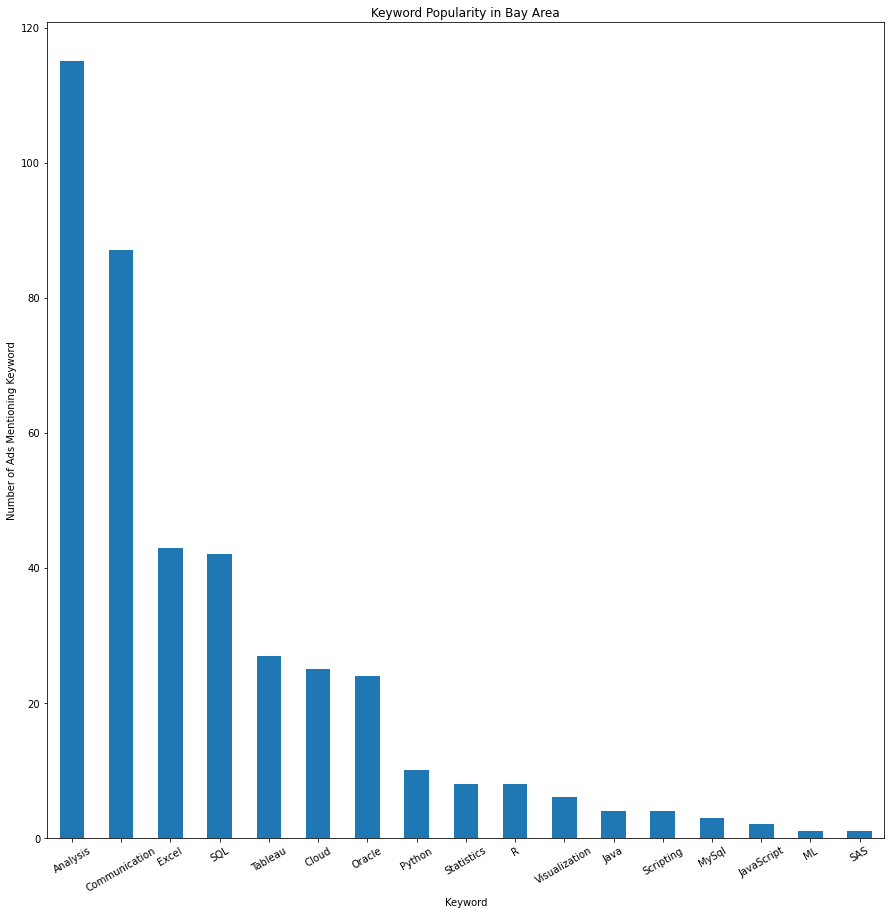

In [216]:
%matplotlib inline

# Get individual keyword counts as percentage of ads mentioning the keyword
fig, ax = plt.subplots(1, 1, figsize=(15,15))
top_words_sf.plot.bar(x='Keyword', rot=30, ax=ax, legend=False)
ax.set_ylabel('Number of Ads Mentioning Keyword')
ax.set_title('Keyword Popularity in Bay Area');

## Data Analyst

In [207]:
# This saves letters, and the numbers 
delete_matching = "[^a-zA-Z0-9]"  

lines = (line.strip() for line in sf_job_description_da.splitlines())

# Break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))

# Remove all blank lines and ends of line
text = ''.join(chunk + ' ' for chunk in chunks if chunk).encode('utf-8')

# Clean all of the unicode
text = text.decode('unicode_escape')

# Remove any terms that aren't words
text = re.sub(delete_matching, " ", text)

# Lower case everything and split them apart
text = text.lower().split()  

# Set up stop words to remove the stop words 
stop_words = set(stopwords.words("english"))

# Lower case the analyst skills
keywords_lower = [x.lower() for x in analyst_skills]

# Save all words in a list
words = list()
for w in text:
    if w not in keywords_lower:
        w = w.replace('.', '')
    if w not in stop_words and len(w) > 0:
        words.append(w)

print(words)

['0', 'business', 'data', 'analyst', 'company', 'alphonso', 'inc', 'location', 'mountain', 'view', 'ca', 'position', 'type', 'full', 'time', 'experience', 'see', 'details', 'education', 'see', 'details', 'opening', 'business', 'data', 'analyst', 'mountain', 'view', 'ca', 'alphonso', 'inc', 'make', 'test', 'modifications', 'database', 'structure', 'manage', 'query', 'build', 'reports', 'database', 'understand', 'customer', 'behavior', 'using', 'big', 'data', 'tools', 'write', 'scripts', 'queries', 'sql', 'measure', 'performance', 'metric', 'ctr', 'completion', 'rate', 'req', 'ms', 'degree', 'cs', 'mgt', 'information', 'system', 'related', 'exp', 'software', 'development', 'sql', 'server', '2yr', 'exps', 'database', 'administrator', 'technologist', 'related', 'send', 'resume', 'hr', 'alphonso', 'tv', '1', 'introduction', 'ibm', 'cloud', 'pak', 'data', 'fully', 'integrated', 'data', 'ai', 'platform', 'modernizes', 'businesses', 'collect', 'organize', 'analyze', 'data', 'infuse', 'ai', 'th

In [208]:
# Count the frequency
freqs = Counter(words)

# What are the top keywords
out_dict = dict([(x, freqs[x.lower()]) for x in analyst_skills])
top_words_sf = pd.DataFrame.from_dict(out_dict, orient='index', columns=['Frequency']).reset_index()
top_words_sf = top_words_sf.rename(columns={'index': 'Keyword'}).sort_values(by='Frequency', ascending=False).reset_index(drop=True)
top_words_sf = top_words_sf.loc[top_words_sf['Frequency'] > 0]
top_words_sf

,Keyword,Frequency
0,Analysis,203
1,SQL,96
2,Communication,68
3,Tableau,65
4,Visualization,57
5,Excel,51
6,Python,48
7,Statistics,48
8,R,38
9,Cloud,35


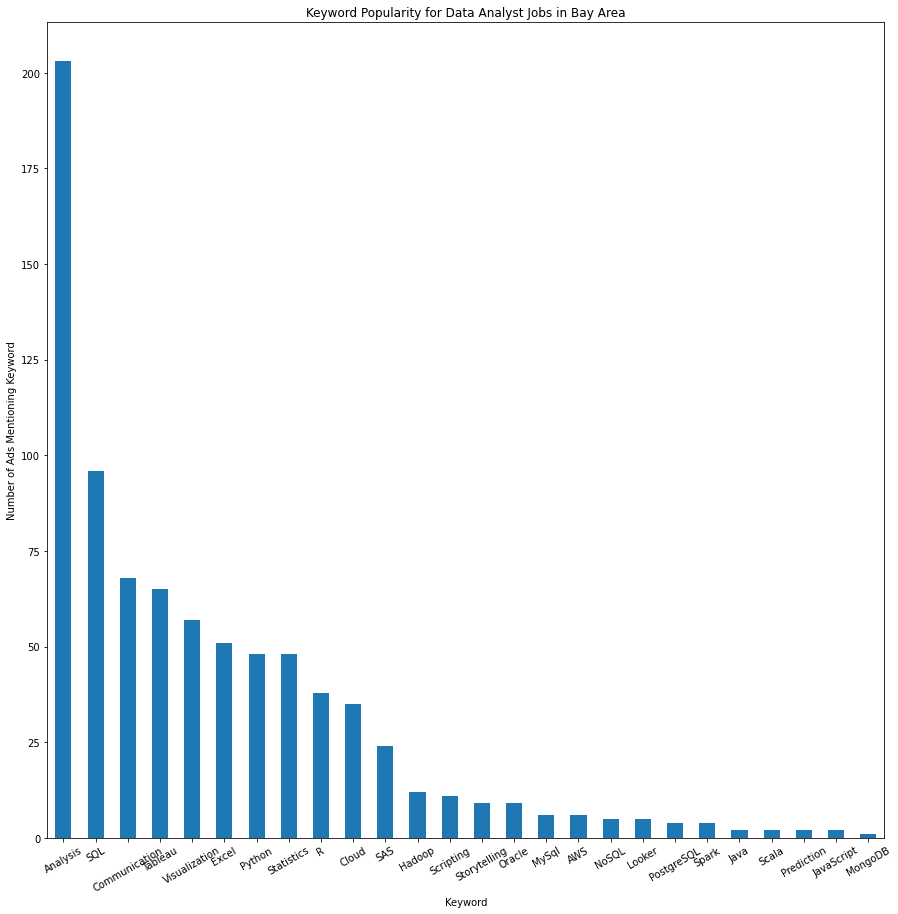

In [209]:
%matplotlib inline

# Get individual keyword counts as percentage of ads mentioning the keyword
fig, ax = plt.subplots(1, 1, figsize=(15,15))
top_words_sf.plot.bar(x='Keyword', rot=30, ax=ax, legend=False)
ax.set_ylabel('Number of Ads Mentioning Keyword')
ax.set_title('Keyword Popularity for Data Analyst Jobs in Bay Area');

## Data Scientist

In [210]:
# This saves letters, and the numbers 
delete_matching = "[^a-zA-Z0-9]"  

lines = (line.strip() for line in sf_job_description_ds.splitlines())

# Break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))

# Remove all blank lines and ends of line
text = ''.join(chunk + ' ' for chunk in chunks if chunk).encode('utf-8')

# Clean all of the unicode
text = text.decode('unicode_escape')

# Remove any terms that aren't words
text = re.sub(delete_matching, " ", text)

# Lower case everything and split them apart
text = text.lower().split()  

# Set up stop words to remove the stop words 
stop_words = set(stopwords.words("english"))

# Lower case the analyst skills
keywords_lower = [x.lower() for x in analyst_skills]

# Save all words in a list
words = list()
for w in text:
    if w not in keywords_lower:
        w = w.replace('.', '')
    if w not in stop_words and len(w) > 0:
        words.append(w)

print(words)

['0', 'description', 'performs', 'advanced', 'data', 'design', 'analysis', 'using', 'electronic', 'medical', 'record', 'emr', 'create', 'new', 'knowledge', 'useful', 'kp', 'outside', 'organizations', 'extracts', 'cleans', 'large', 'volumes', 'healthcare', 'data', 'across', 'dozens', 'sources', 'applies', 'expert', 'statistical', 'methodologies', 'clinical', 'outcomes', 'partners', 'effectively', 'physicians', 'clinicians', 'software', 'engineers', 'business', 'managers', 'communicate', 'findings', 'using', 'data', 'visualization', 'techniques', 'essential', 'responsibilities', 'works', 'physicians', 'epidemiologists', 'statisticians', 'business', 'managers', 'software', 'engineers', 'formulate', 'scope', 'questions', 'translate', 'knowledge', 'care', 'transformation', 'develops', 'algorithms', 'predictive', 'models', 'solve', 'critical', 'health', 'service', 'problems', 'influences', 'general', 'audience', 'understand', 'quality', 'completeness', 'appropriate', 'use', 'data', 'provides

In [211]:
# Count the frequency
freqs = Counter(words)

# What are the top keywords
out_dict = dict([(x, freqs[x.lower()]) for x in analyst_skills])
top_words_sf = pd.DataFrame.from_dict(out_dict, orient='index', columns=['Frequency']).reset_index()
top_words_sf = top_words_sf.rename(columns={'index': 'Keyword'}).sort_values(by='Frequency', ascending=False).reset_index(drop=True)
top_words_sf = top_words_sf.loc[top_words_sf['Frequency'] > 0]
top_words_sf

,Keyword,Frequency
0,Analysis,151
1,Python,118
2,SQL,78
3,Statistics,72
4,R,71
5,Cloud,69
6,ML,41
7,Communication,41
8,Spark,36
9,Hadoop,23


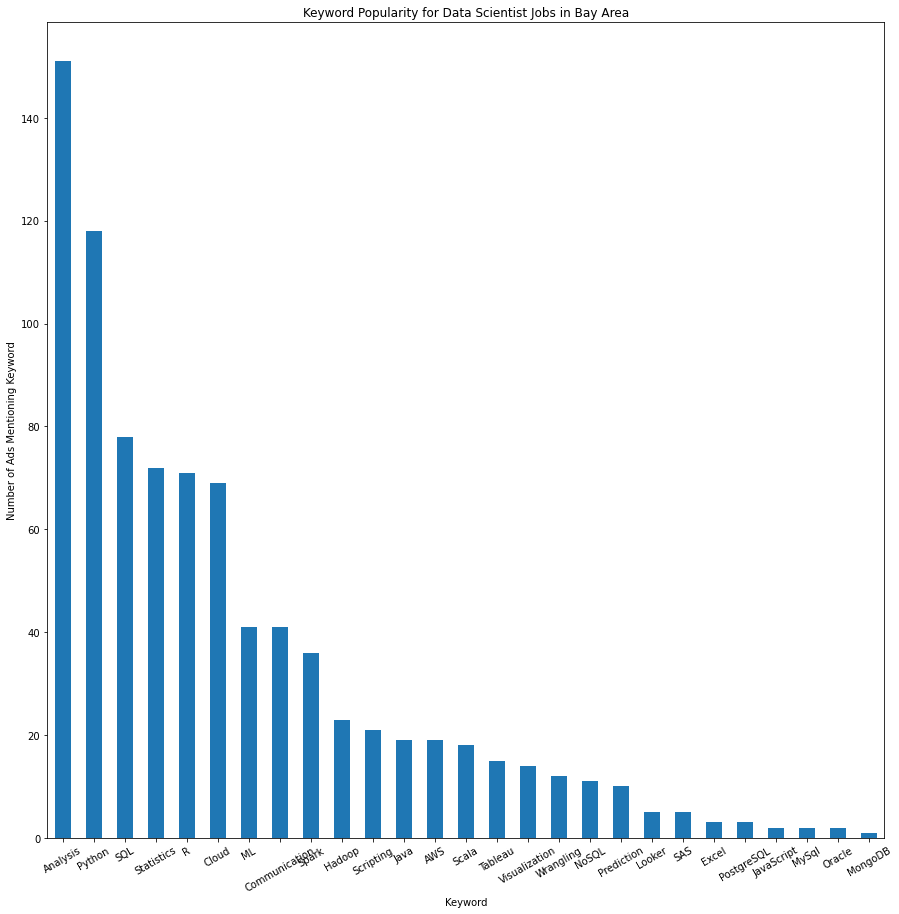

In [212]:
%matplotlib inline

# Get individual keyword counts as percentage of ads mentioning the keyword
fig, ax = plt.subplots(1, 1, figsize=(15,15))
top_words_sf.plot.bar(x='Keyword', rot=30, ax=ax, legend=False)
ax.set_ylabel('Number of Ads Mentioning Keyword')
ax.set_title('Keyword Popularity for Data Scientist Jobs in Bay Area');